In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 9iotn5sk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-9iotn5sk:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5867 [00:00<?, ?it/s]

  0%|                                                                     | 1/5867 [00:00<58:18,  1.68it/s]

  0%|                                                                     | 3/5867 [00:00<18:54,  5.17it/s]

  0%|                                                                     | 5/5867 [00:00<11:50,  8.26it/s]

  0%|                                                                     | 7/5867 [00:00<09:00, 10.84it/s]

  0%|                                                                     | 9/5867 [00:01<07:33, 12.91it/s]

  0%|▏                                                                   | 11/5867 [00:01<06:43, 14.51it/s]

  0%|▏                                                                   | 13/5867 [00:01<06:12, 15.72it/s]

  0%|▏                                                                   | 15/5867 [00:01<05:52, 16.61it/s]

  0%|▏                                                                   | 17/5867 [00:01<05:38, 17.27it/s]

  0%|▏                                                                   | 19/5867 [00:01<05:29, 17.74it/s]

  0%|▏                                                                   | 21/5867 [00:01<05:23, 18.08it/s]

  0%|▎                                                                   | 23/5867 [00:01<05:19, 18.31it/s]

  0%|▎                                                                   | 25/5867 [00:01<05:16, 18.48it/s]

  0%|▎                                                                   | 27/5867 [00:01<05:14, 18.59it/s]

  0%|▎                                                                   | 29/5867 [00:02<05:23, 18.05it/s]

  1%|▎                                                                   | 31/5867 [00:02<05:39, 17.17it/s]

  1%|▍                                                                   | 33/5867 [00:02<05:50, 16.65it/s]

  1%|▍                                                                   | 35/5867 [00:02<05:55, 16.39it/s]

  1%|▍                                                                   | 37/5867 [00:02<06:00, 16.17it/s]

  1%|▍                                                                   | 39/5867 [00:02<06:08, 15.80it/s]

  1%|▍                                                                   | 41/5867 [00:02<06:14, 15.57it/s]

  1%|▍                                                                   | 43/5867 [00:03<06:16, 15.45it/s]

  1%|▌                                                                   | 45/5867 [00:03<06:14, 15.56it/s]

  1%|▌                                                                   | 47/5867 [00:03<06:14, 15.53it/s]

  1%|▌                                                                   | 49/5867 [00:03<06:10, 15.69it/s]

  1%|▌                                                                   | 51/5867 [00:03<06:38, 14.61it/s]

  1%|▌                                                                   | 53/5867 [00:03<07:58, 12.14it/s]

  1%|▋                                                                   | 55/5867 [00:03<08:55, 10.86it/s]

  1%|▋                                                                   | 57/5867 [00:04<09:32, 10.15it/s]

  1%|▋                                                                   | 59/5867 [00:04<10:00,  9.68it/s]

  1%|▋                                                                   | 61/5867 [00:04<10:19,  9.37it/s]

  1%|▋                                                                   | 62/5867 [00:04<10:28,  9.23it/s]

  1%|▋                                                                   | 63/5867 [00:04<10:37,  9.10it/s]

  1%|▋                                                                   | 64/5867 [00:05<10:42,  9.03it/s]

  1%|▊                                                                   | 65/5867 [00:05<10:49,  8.93it/s]

  1%|▊                                                                   | 66/5867 [00:05<10:51,  8.90it/s]

  1%|▊                                                                   | 67/5867 [00:05<10:57,  8.83it/s]

  1%|▊                                                                   | 68/5867 [00:05<10:57,  8.82it/s]

  1%|▊                                                                   | 69/5867 [00:05<11:01,  8.77it/s]

  1%|▊                                                                   | 70/5867 [00:05<11:00,  8.78it/s]

  1%|▊                                                                   | 72/5867 [00:05<10:37,  9.10it/s]

  1%|▊                                                                   | 73/5867 [00:06<10:45,  8.98it/s]

  1%|▊                                                                   | 74/5867 [00:06<10:51,  8.89it/s]

  1%|▊                                                                   | 75/5867 [00:06<10:53,  8.86it/s]

  1%|▉                                                                   | 76/5867 [00:06<10:58,  8.80it/s]

  1%|▉                                                                   | 77/5867 [00:06<10:57,  8.80it/s]

  1%|▉                                                                   | 78/5867 [00:06<10:57,  8.80it/s]

  1%|▉                                                                   | 79/5867 [00:06<10:57,  8.80it/s]

  1%|▉                                                                   | 80/5867 [00:06<10:57,  8.80it/s]

  1%|▉                                                                   | 81/5867 [00:06<11:01,  8.75it/s]

  1%|▉                                                                   | 82/5867 [00:07<11:00,  8.76it/s]

  1%|▉                                                                   | 83/5867 [00:07<10:59,  8.77it/s]

  1%|▉                                                                   | 84/5867 [00:07<11:02,  8.73it/s]

  1%|▉                                                                   | 85/5867 [00:07<11:04,  8.70it/s]

  1%|▉                                                                   | 86/5867 [00:07<11:02,  8.73it/s]

  1%|█                                                                   | 87/5867 [00:07<11:00,  8.75it/s]

  1%|█                                                                   | 88/5867 [00:07<10:58,  8.77it/s]

  2%|█                                                                   | 89/5867 [00:07<10:58,  8.78it/s]

  2%|█                                                                   | 90/5867 [00:07<10:57,  8.79it/s]

  2%|█                                                                   | 91/5867 [00:08<10:56,  8.79it/s]

  2%|█                                                                   | 92/5867 [00:08<10:40,  9.02it/s]

  2%|█                                                                   | 93/5867 [00:08<10:48,  8.90it/s]

  2%|█                                                                   | 94/5867 [00:08<10:54,  8.82it/s]

  2%|█                                                                   | 95/5867 [00:08<10:54,  8.82it/s]

  2%|█                                                                   | 96/5867 [00:08<10:54,  8.81it/s]

  2%|█                                                                   | 97/5867 [00:08<10:58,  8.76it/s]

  2%|█▏                                                                  | 98/5867 [00:08<10:57,  8.77it/s]

  2%|█▏                                                                  | 99/5867 [00:09<10:56,  8.78it/s]

  2%|█▏                                                                 | 100/5867 [00:09<10:56,  8.79it/s]

  2%|█▏                                                                 | 101/5867 [00:09<10:55,  8.79it/s]

  2%|█▏                                                                 | 102/5867 [00:09<10:55,  8.79it/s]

  2%|█▏                                                                 | 103/5867 [00:09<10:55,  8.79it/s]

  2%|█▏                                                                 | 104/5867 [00:09<10:55,  8.80it/s]

  2%|█▏                                                                 | 105/5867 [00:09<10:58,  8.75it/s]

  2%|█▏                                                                 | 106/5867 [00:09<11:01,  8.71it/s]

  2%|█▏                                                                 | 107/5867 [00:09<11:02,  8.69it/s]

  2%|█▏                                                                 | 108/5867 [00:10<11:00,  8.72it/s]

  2%|█▏                                                                 | 109/5867 [00:10<10:58,  8.75it/s]

  2%|█▎                                                                 | 110/5867 [00:10<11:00,  8.72it/s]

  2%|█▎                                                                 | 112/5867 [00:10<08:32, 11.22it/s]

  2%|█▎                                                                 | 114/5867 [00:10<07:32, 12.72it/s]

  2%|█▎                                                                 | 116/5867 [00:10<06:58, 13.75it/s]

  2%|█▎                                                                 | 118/5867 [00:10<06:37, 14.47it/s]

  2%|█▎                                                                 | 120/5867 [00:10<06:24, 14.95it/s]

  2%|█▍                                                                 | 122/5867 [00:11<06:15, 15.29it/s]

  2%|█▍                                                                 | 124/5867 [00:11<06:09, 15.53it/s]

  2%|█▍                                                                 | 126/5867 [00:11<06:05, 15.69it/s]

  2%|█▍                                                                 | 128/5867 [00:11<06:06, 15.68it/s]

  2%|█▍                                                                 | 130/5867 [00:11<06:04, 15.75it/s]

  2%|█▌                                                                 | 132/5867 [00:11<06:03, 15.78it/s]

  2%|█▌                                                                 | 134/5867 [00:11<06:02, 15.83it/s]

  2%|█▌                                                                 | 136/5867 [00:11<06:01, 15.85it/s]

  2%|█▌                                                                 | 138/5867 [00:12<06:01, 15.86it/s]

  2%|█▌                                                                 | 140/5867 [00:12<06:00, 15.87it/s]

  2%|█▌                                                                 | 142/5867 [00:12<06:00, 15.87it/s]

  2%|█▋                                                                 | 144/5867 [00:12<06:00, 15.88it/s]

  2%|█▋                                                                 | 146/5867 [00:12<06:00, 15.88it/s]

  3%|█▋                                                                 | 148/5867 [00:12<05:59, 15.89it/s]

  3%|█▋                                                                 | 150/5867 [00:12<05:59, 15.89it/s]

  3%|█▋                                                                 | 152/5867 [00:12<05:59, 15.88it/s]

  3%|█▊                                                                 | 154/5867 [00:13<05:59, 15.88it/s]

  3%|█▊                                                                 | 156/5867 [00:13<05:59, 15.87it/s]

  3%|█▊                                                                 | 158/5867 [00:13<05:59, 15.88it/s]

  3%|█▊                                                                 | 160/5867 [00:13<05:59, 15.88it/s]

  3%|█▊                                                                 | 162/5867 [00:13<05:59, 15.87it/s]

  3%|█▊                                                                 | 164/5867 [00:13<05:59, 15.86it/s]

  3%|█▉                                                                 | 166/5867 [00:13<05:59, 15.87it/s]

  3%|█▉                                                                 | 168/5867 [00:13<05:59, 15.87it/s]

  3%|█▉                                                                 | 170/5867 [00:14<05:58, 15.87it/s]

  3%|█▉                                                                 | 172/5867 [00:14<05:58, 15.87it/s]

  3%|█▉                                                                 | 174/5867 [00:14<05:58, 15.88it/s]

  3%|██                                                                 | 176/5867 [00:14<05:58, 15.88it/s]

  3%|██                                                                 | 178/5867 [00:14<05:58, 15.88it/s]

  3%|██                                                                 | 180/5867 [00:14<05:58, 15.88it/s]

  3%|██                                                                 | 182/5867 [00:14<05:57, 15.89it/s]

  3%|██                                                                 | 184/5867 [00:14<05:57, 15.90it/s]

  3%|██                                                                 | 186/5867 [00:15<05:57, 15.91it/s]

  3%|██▏                                                                | 188/5867 [00:15<05:57, 15.90it/s]

  3%|██▏                                                                | 190/5867 [00:15<05:56, 15.90it/s]

  3%|██▏                                                                | 192/5867 [00:15<05:56, 15.91it/s]

  3%|██▏                                                                | 194/5867 [00:15<05:56, 15.91it/s]

  3%|██▏                                                                | 196/5867 [00:15<05:56, 15.89it/s]

  3%|██▎                                                                | 198/5867 [00:15<05:56, 15.90it/s]

  3%|██▎                                                                | 200/5867 [00:15<05:56, 15.90it/s]

  3%|██▎                                                                | 202/5867 [00:16<05:56, 15.89it/s]

  3%|██▎                                                                | 204/5867 [00:16<05:55, 15.91it/s]

  4%|██▎                                                                | 206/5867 [00:16<05:55, 15.91it/s]

  4%|██▍                                                                | 208/5867 [00:16<05:56, 15.90it/s]

  4%|██▍                                                                | 210/5867 [00:16<05:55, 15.90it/s]

  4%|██▍                                                                | 212/5867 [00:16<05:55, 15.90it/s]

  4%|██▍                                                                | 214/5867 [00:16<05:55, 15.89it/s]

  4%|██▍                                                                | 216/5867 [00:16<05:55, 15.90it/s]

  4%|██▍                                                                | 218/5867 [00:17<05:55, 15.90it/s]

  4%|██▌                                                                | 220/5867 [00:17<05:55, 15.91it/s]

  4%|██▌                                                                | 222/5867 [00:17<05:54, 15.90it/s]

  4%|██▌                                                                | 224/5867 [00:17<05:55, 15.89it/s]

  4%|██▌                                                                | 226/5867 [00:17<05:54, 15.91it/s]

  4%|██▌                                                                | 228/5867 [00:17<05:54, 15.92it/s]

  4%|██▋                                                                | 230/5867 [00:17<05:54, 15.92it/s]

  4%|██▋                                                                | 232/5867 [00:17<05:54, 15.91it/s]

  4%|██▋                                                                | 234/5867 [00:18<05:53, 15.92it/s]

  4%|██▋                                                                | 236/5867 [00:18<05:54, 15.90it/s]

  4%|██▋                                                                | 238/5867 [00:18<05:53, 15.91it/s]

  4%|██▋                                                                | 240/5867 [00:18<05:53, 15.92it/s]

  4%|██▊                                                                | 242/5867 [00:18<05:53, 15.92it/s]

  4%|██▊                                                                | 244/5867 [00:18<05:53, 15.91it/s]

  4%|██▊                                                                | 246/5867 [00:18<05:53, 15.91it/s]

  4%|██▊                                                                | 248/5867 [00:18<05:53, 15.91it/s]

  4%|██▊                                                                | 250/5867 [00:19<05:53, 15.90it/s]

  4%|██▉                                                                | 252/5867 [00:19<05:53, 15.91it/s]

  4%|██▉                                                                | 254/5867 [00:19<05:52, 15.92it/s]

  4%|██▉                                                                | 256/5867 [00:19<05:52, 15.91it/s]

  4%|██▉                                                                | 258/5867 [00:19<05:52, 15.91it/s]

  4%|██▉                                                                | 260/5867 [00:19<05:52, 15.92it/s]

  4%|██▉                                                                | 262/5867 [00:19<05:52, 15.92it/s]

  4%|███                                                                | 264/5867 [00:19<05:51, 15.93it/s]

  5%|███                                                                | 266/5867 [00:20<05:51, 15.93it/s]

  5%|███                                                                | 268/5867 [00:20<05:51, 15.93it/s]

  5%|███                                                                | 270/5867 [00:20<05:52, 15.88it/s]

  5%|███                                                                | 272/5867 [00:20<05:52, 15.87it/s]

  5%|███▏                                                               | 274/5867 [00:20<05:52, 15.86it/s]

  5%|███▏                                                               | 276/5867 [00:20<05:52, 15.85it/s]

  5%|███▏                                                               | 278/5867 [00:20<05:52, 15.86it/s]

  5%|███▏                                                               | 280/5867 [00:20<05:52, 15.84it/s]

  5%|███▏                                                               | 282/5867 [00:21<05:52, 15.82it/s]

  5%|███▏                                                               | 284/5867 [00:21<05:53, 15.81it/s]

  5%|███▎                                                               | 286/5867 [00:21<05:52, 15.81it/s]

  5%|███▎                                                               | 288/5867 [00:21<05:53, 15.80it/s]

  5%|███▎                                                               | 290/5867 [00:21<05:53, 15.79it/s]

  5%|███▎                                                               | 292/5867 [00:21<05:53, 15.78it/s]

  5%|███▎                                                               | 294/5867 [00:21<05:52, 15.79it/s]

  5%|███▍                                                               | 296/5867 [00:21<05:52, 15.80it/s]

  5%|███▍                                                               | 298/5867 [00:22<05:52, 15.80it/s]

  5%|███▍                                                               | 300/5867 [00:22<05:52, 15.80it/s]

  5%|███▍                                                               | 302/5867 [00:22<05:52, 15.81it/s]

  5%|███▍                                                               | 304/5867 [00:22<05:51, 15.82it/s]

  5%|███▍                                                               | 306/5867 [00:22<05:51, 15.81it/s]

  5%|███▌                                                               | 308/5867 [00:22<05:51, 15.82it/s]

  5%|███▌                                                               | 310/5867 [00:22<05:51, 15.83it/s]

  5%|███▌                                                               | 312/5867 [00:22<05:50, 15.83it/s]

  5%|███▌                                                               | 314/5867 [00:23<05:50, 15.83it/s]

  5%|███▌                                                               | 316/5867 [00:23<05:50, 15.83it/s]

  5%|███▋                                                               | 318/5867 [00:23<05:50, 15.82it/s]

  5%|███▋                                                               | 320/5867 [00:23<05:50, 15.82it/s]

  5%|███▋                                                               | 322/5867 [00:23<05:50, 15.82it/s]

  6%|███▋                                                               | 324/5867 [00:23<05:50, 15.82it/s]

  6%|███▋                                                               | 326/5867 [00:23<05:50, 15.81it/s]

  6%|███▋                                                               | 328/5867 [00:23<05:50, 15.80it/s]

  6%|███▊                                                               | 330/5867 [00:24<05:50, 15.80it/s]

  6%|███▊                                                               | 332/5867 [00:24<05:50, 15.80it/s]

  6%|███▊                                                               | 334/5867 [00:24<05:50, 15.80it/s]

  6%|███▊                                                               | 336/5867 [00:24<05:50, 15.79it/s]

  6%|███▊                                                               | 338/5867 [00:24<05:50, 15.79it/s]

  6%|███▉                                                               | 340/5867 [00:24<05:49, 15.79it/s]

  6%|███▉                                                               | 342/5867 [00:24<05:49, 15.79it/s]

  6%|███▉                                                               | 344/5867 [00:24<05:49, 15.79it/s]

  6%|███▉                                                               | 346/5867 [00:25<05:49, 15.79it/s]

  6%|███▉                                                               | 348/5867 [00:25<05:49, 15.80it/s]

  6%|███▉                                                               | 350/5867 [00:25<05:49, 15.80it/s]

  6%|████                                                               | 352/5867 [00:25<05:48, 15.81it/s]

  6%|████                                                               | 354/5867 [00:25<05:48, 15.81it/s]

  6%|████                                                               | 356/5867 [00:25<05:48, 15.80it/s]

  6%|████                                                               | 358/5867 [00:25<05:48, 15.79it/s]

  6%|████                                                               | 360/5867 [00:26<05:48, 15.81it/s]

  6%|████▏                                                              | 362/5867 [00:26<05:48, 15.80it/s]

  6%|████▏                                                              | 364/5867 [00:26<05:48, 15.80it/s]

  6%|████▏                                                              | 366/5867 [00:26<05:48, 15.81it/s]

  6%|████▏                                                              | 368/5867 [00:26<05:47, 15.80it/s]

  6%|████▏                                                              | 370/5867 [00:26<05:48, 15.79it/s]

  6%|████▏                                                              | 372/5867 [00:26<05:47, 15.80it/s]

  6%|████▎                                                              | 374/5867 [00:26<05:47, 15.79it/s]

  6%|████▎                                                              | 376/5867 [00:27<05:47, 15.79it/s]

  6%|████▎                                                              | 378/5867 [00:27<05:47, 15.78it/s]

  6%|████▎                                                              | 380/5867 [00:27<05:47, 15.79it/s]

  7%|████▎                                                              | 382/5867 [00:27<05:47, 15.80it/s]

  7%|████▍                                                              | 384/5867 [00:27<05:47, 15.79it/s]

  7%|████▍                                                              | 386/5867 [00:27<05:47, 15.78it/s]

  7%|████▍                                                              | 388/5867 [00:27<05:46, 15.79it/s]

  7%|████▍                                                              | 390/5867 [00:27<05:46, 15.80it/s]

  7%|████▍                                                              | 392/5867 [00:28<05:46, 15.79it/s]

  7%|████▍                                                              | 394/5867 [00:28<05:46, 15.79it/s]

  7%|████▌                                                              | 396/5867 [00:28<05:46, 15.78it/s]

  7%|████▌                                                              | 398/5867 [00:28<05:46, 15.78it/s]

  7%|████▌                                                              | 400/5867 [00:28<05:46, 15.77it/s]

  7%|████▌                                                              | 402/5867 [00:28<05:46, 15.77it/s]

  7%|████▌                                                              | 404/5867 [00:28<05:46, 15.78it/s]

  7%|████▋                                                              | 406/5867 [00:28<05:46, 15.78it/s]

  7%|████▋                                                              | 408/5867 [00:29<05:45, 15.78it/s]

  7%|████▋                                                              | 410/5867 [00:29<05:45, 15.79it/s]

  7%|████▋                                                              | 412/5867 [00:29<05:45, 15.80it/s]

  7%|████▋                                                              | 414/5867 [00:29<05:44, 15.81it/s]

  7%|████▊                                                              | 416/5867 [00:29<05:44, 15.81it/s]

  7%|████▊                                                              | 418/5867 [00:29<05:44, 15.80it/s]

  7%|████▊                                                              | 420/5867 [00:29<05:44, 15.80it/s]

  7%|████▊                                                              | 422/5867 [00:29<05:37, 16.12it/s]

  7%|████▊                                                              | 424/5867 [00:30<05:28, 16.58it/s]

  7%|████▊                                                              | 426/5867 [00:30<06:00, 15.11it/s]

  7%|████▉                                                              | 428/5867 [00:30<05:54, 15.36it/s]

  7%|████▉                                                              | 430/5867 [00:30<05:49, 15.56it/s]

  7%|████▉                                                              | 432/5867 [00:30<05:46, 15.69it/s]

  7%|████▉                                                              | 434/5867 [00:30<05:44, 15.79it/s]

  7%|████▉                                                              | 436/5867 [00:30<05:42, 15.86it/s]

  7%|█████                                                              | 438/5867 [00:30<05:41, 15.92it/s]

  7%|█████                                                              | 440/5867 [00:31<05:40, 15.95it/s]

  8%|█████                                                              | 442/5867 [00:31<05:40, 15.95it/s]

  8%|█████                                                              | 444/5867 [00:31<05:40, 15.93it/s]

  8%|█████                                                              | 446/5867 [00:31<05:40, 15.92it/s]

  8%|█████                                                              | 448/5867 [00:31<05:40, 15.90it/s]

  8%|█████▏                                                             | 450/5867 [00:31<05:41, 15.87it/s]

  8%|█████▏                                                             | 452/5867 [00:31<05:41, 15.88it/s]

  8%|█████▏                                                             | 454/5867 [00:31<05:40, 15.88it/s]

  8%|█████▏                                                             | 456/5867 [00:32<05:40, 15.87it/s]

  8%|█████▏                                                             | 458/5867 [00:32<05:40, 15.87it/s]

  8%|█████▎                                                             | 460/5867 [00:32<05:40, 15.88it/s]

  8%|█████▎                                                             | 462/5867 [00:32<05:40, 15.87it/s]

  8%|█████▎                                                             | 464/5867 [00:32<05:40, 15.86it/s]

  8%|█████▎                                                             | 466/5867 [00:32<05:40, 15.87it/s]

  8%|█████▎                                                             | 468/5867 [00:32<05:40, 15.87it/s]

  8%|█████▎                                                             | 470/5867 [00:32<05:39, 15.88it/s]

  8%|█████▍                                                             | 472/5867 [00:33<05:39, 15.88it/s]

  8%|█████▍                                                             | 474/5867 [00:33<05:39, 15.88it/s]

  8%|█████▍                                                             | 476/5867 [00:33<05:39, 15.88it/s]

  8%|█████▍                                                             | 478/5867 [00:33<05:39, 15.88it/s]

  8%|█████▍                                                             | 480/5867 [00:33<05:39, 15.89it/s]

  8%|█████▌                                                             | 482/5867 [00:33<05:38, 15.90it/s]

  8%|█████▌                                                             | 484/5867 [00:33<05:38, 15.89it/s]

  8%|█████▌                                                             | 486/5867 [00:33<05:38, 15.91it/s]

  8%|█████▌                                                             | 488/5867 [00:34<05:38, 15.89it/s]

  8%|█████▌                                                             | 490/5867 [00:34<05:38, 15.90it/s]

  8%|█████▌                                                             | 492/5867 [00:34<05:38, 15.89it/s]

  8%|█████▋                                                             | 494/5867 [00:34<05:38, 15.89it/s]

  8%|█████▋                                                             | 496/5867 [00:34<05:38, 15.88it/s]

  8%|█████▋                                                             | 498/5867 [00:34<05:37, 15.89it/s]

  9%|█████▋                                                             | 500/5867 [00:34<05:37, 15.89it/s]

  9%|█████▋                                                             | 502/5867 [00:34<05:37, 15.89it/s]

  9%|█████▊                                                             | 504/5867 [00:35<05:37, 15.90it/s]

  9%|█████▊                                                             | 506/5867 [00:35<05:36, 15.91it/s]

  9%|█████▊                                                             | 508/5867 [00:35<05:36, 15.90it/s]

  9%|█████▊                                                             | 510/5867 [00:35<05:37, 15.88it/s]

  9%|█████▊                                                             | 512/5867 [00:35<05:37, 15.86it/s]

  9%|█████▊                                                             | 514/5867 [00:35<05:37, 15.84it/s]

  9%|█████▉                                                             | 516/5867 [00:35<05:38, 15.83it/s]

  9%|█████▉                                                             | 518/5867 [00:35<05:38, 15.82it/s]

  9%|█████▉                                                             | 520/5867 [00:36<05:38, 15.81it/s]

  9%|█████▉                                                             | 522/5867 [00:36<05:38, 15.80it/s]

  9%|█████▉                                                             | 524/5867 [00:36<05:38, 15.78it/s]

  9%|██████                                                             | 526/5867 [00:36<05:38, 15.78it/s]

  9%|██████                                                             | 528/5867 [00:36<05:38, 15.79it/s]

  9%|██████                                                             | 530/5867 [00:36<05:38, 15.78it/s]

  9%|██████                                                             | 532/5867 [00:36<05:38, 15.78it/s]

  9%|██████                                                             | 534/5867 [00:37<05:37, 15.79it/s]

  9%|██████                                                             | 536/5867 [00:37<05:37, 15.79it/s]

  9%|██████▏                                                            | 538/5867 [00:37<05:37, 15.79it/s]

  9%|██████▏                                                            | 540/5867 [00:37<05:37, 15.78it/s]

  9%|██████▏                                                            | 542/5867 [00:37<05:37, 15.79it/s]

  9%|██████▏                                                            | 544/5867 [00:37<05:36, 15.80it/s]

  9%|██████▏                                                            | 546/5867 [00:37<05:36, 15.80it/s]

  9%|██████▎                                                            | 548/5867 [00:37<05:36, 15.78it/s]

  9%|██████▎                                                            | 550/5867 [00:38<05:36, 15.80it/s]

  9%|██████▎                                                            | 552/5867 [00:38<05:36, 15.79it/s]

  9%|██████▎                                                            | 554/5867 [00:38<05:36, 15.79it/s]

  9%|██████▎                                                            | 556/5867 [00:38<05:36, 15.79it/s]

 10%|██████▎                                                            | 558/5867 [00:38<05:36, 15.80it/s]

 10%|██████▍                                                            | 560/5867 [00:38<05:35, 15.80it/s]

 10%|██████▍                                                            | 562/5867 [00:38<05:35, 15.79it/s]

 10%|██████▍                                                            | 564/5867 [00:38<05:35, 15.80it/s]

 10%|██████▍                                                            | 566/5867 [00:39<05:35, 15.80it/s]

 10%|██████▍                                                            | 568/5867 [00:39<05:35, 15.80it/s]

 10%|██████▌                                                            | 570/5867 [00:39<05:35, 15.79it/s]

 10%|██████▌                                                            | 572/5867 [00:39<05:35, 15.80it/s]

 10%|██████▌                                                            | 574/5867 [00:39<05:35, 15.79it/s]

 10%|██████▌                                                            | 576/5867 [00:39<05:35, 15.79it/s]

 10%|██████▌                                                            | 578/5867 [00:39<05:34, 15.80it/s]

 10%|██████▌                                                            | 580/5867 [00:39<05:35, 15.78it/s]

 10%|██████▋                                                            | 582/5867 [00:40<05:34, 15.79it/s]

 10%|██████▋                                                            | 584/5867 [00:40<05:34, 15.79it/s]

 10%|██████▋                                                            | 586/5867 [00:40<05:34, 15.78it/s]

 10%|██████▋                                                            | 588/5867 [00:40<05:34, 15.77it/s]

 10%|██████▋                                                            | 590/5867 [00:40<05:34, 15.77it/s]

 10%|██████▊                                                            | 592/5867 [00:40<05:34, 15.78it/s]

 10%|██████▊                                                            | 594/5867 [00:40<05:34, 15.79it/s]

 10%|██████▊                                                            | 596/5867 [00:40<05:33, 15.80it/s]

 10%|██████▊                                                            | 598/5867 [00:41<05:33, 15.81it/s]

 10%|██████▊                                                            | 600/5867 [00:41<05:33, 15.81it/s]

 10%|██████▊                                                            | 602/5867 [00:41<05:33, 15.80it/s]

 10%|██████▉                                                            | 604/5867 [00:41<05:33, 15.79it/s]

 10%|██████▉                                                            | 606/5867 [00:41<05:32, 15.80it/s]

 10%|██████▉                                                            | 608/5867 [00:41<05:32, 15.81it/s]

 10%|██████▉                                                            | 610/5867 [00:41<05:32, 15.81it/s]

 10%|██████▉                                                            | 612/5867 [00:41<05:32, 15.81it/s]

 10%|███████                                                            | 614/5867 [00:42<05:32, 15.80it/s]

 10%|███████                                                            | 616/5867 [00:42<05:32, 15.79it/s]

 11%|███████                                                            | 618/5867 [00:42<05:32, 15.78it/s]

 11%|███████                                                            | 620/5867 [00:42<05:32, 15.79it/s]

 11%|███████                                                            | 622/5867 [00:42<05:32, 15.79it/s]

 11%|███████▏                                                           | 624/5867 [00:42<05:32, 15.79it/s]

 11%|███████▏                                                           | 626/5867 [00:42<05:31, 15.81it/s]

 11%|███████▏                                                           | 628/5867 [00:42<05:31, 15.80it/s]

 11%|███████▏                                                           | 630/5867 [00:43<05:31, 15.79it/s]

 11%|███████▏                                                           | 632/5867 [00:43<05:31, 15.79it/s]

 11%|███████▏                                                           | 634/5867 [00:43<05:31, 15.79it/s]

 11%|███████▎                                                           | 636/5867 [00:43<05:31, 15.80it/s]

 11%|███████▎                                                           | 638/5867 [00:43<05:30, 15.80it/s]

 11%|███████▎                                                           | 640/5867 [00:43<05:30, 15.80it/s]

 11%|███████▎                                                           | 642/5867 [00:43<05:30, 15.79it/s]

 11%|███████▎                                                           | 644/5867 [00:43<05:30, 15.78it/s]

 11%|███████▍                                                           | 646/5867 [00:44<05:30, 15.78it/s]

 11%|███████▍                                                           | 648/5867 [00:44<05:30, 15.80it/s]

 11%|███████▍                                                           | 650/5867 [00:44<05:30, 15.81it/s]

 11%|███████▍                                                           | 652/5867 [00:44<05:29, 15.82it/s]

 11%|███████▍                                                           | 654/5867 [00:44<05:29, 15.81it/s]

 11%|███████▍                                                           | 656/5867 [00:44<05:29, 15.80it/s]

 11%|███████▌                                                           | 658/5867 [00:44<05:29, 15.80it/s]

 11%|███████▌                                                           | 660/5867 [00:44<05:29, 15.79it/s]

 11%|███████▌                                                           | 662/5867 [00:45<05:29, 15.79it/s]

 11%|███████▌                                                           | 664/5867 [00:45<05:29, 15.80it/s]

 11%|███████▌                                                           | 666/5867 [00:45<05:28, 15.81it/s]

 11%|███████▋                                                           | 668/5867 [00:45<05:28, 15.81it/s]

 11%|███████▋                                                           | 670/5867 [00:45<05:28, 15.80it/s]

 11%|███████▋                                                           | 672/5867 [00:45<05:28, 15.80it/s]

 11%|███████▋                                                           | 674/5867 [00:45<05:28, 15.79it/s]

 12%|███████▋                                                           | 676/5867 [00:45<05:28, 15.80it/s]

 12%|███████▋                                                           | 678/5867 [00:46<05:28, 15.79it/s]

 12%|███████▊                                                           | 680/5867 [00:46<05:28, 15.78it/s]

 12%|███████▊                                                           | 682/5867 [00:46<05:28, 15.79it/s]

 12%|███████▊                                                           | 684/5867 [00:46<05:28, 15.78it/s]

 12%|███████▊                                                           | 686/5867 [00:46<05:28, 15.78it/s]

 12%|███████▊                                                           | 688/5867 [00:46<05:27, 15.79it/s]

 12%|███████▉                                                           | 690/5867 [00:46<05:27, 15.79it/s]

 12%|███████▉                                                           | 692/5867 [00:47<05:27, 15.79it/s]

 12%|███████▉                                                           | 694/5867 [00:47<05:27, 15.79it/s]

 12%|███████▉                                                           | 696/5867 [00:47<05:27, 15.79it/s]

 12%|███████▉                                                           | 698/5867 [00:47<05:27, 15.78it/s]

 12%|███████▉                                                           | 700/5867 [00:47<05:27, 15.78it/s]

 12%|████████                                                           | 702/5867 [00:47<05:27, 15.79it/s]

 12%|████████                                                           | 704/5867 [00:47<05:26, 15.80it/s]

 12%|████████                                                           | 706/5867 [00:47<05:26, 15.80it/s]

 12%|████████                                                           | 708/5867 [00:48<05:26, 15.79it/s]

 12%|████████                                                           | 710/5867 [00:48<05:26, 15.79it/s]

 12%|████████▏                                                          | 712/5867 [00:48<05:26, 15.78it/s]

 12%|████████▏                                                          | 714/5867 [00:48<05:26, 15.79it/s]

 12%|████████▏                                                          | 716/5867 [00:48<05:26, 15.79it/s]

 12%|████████▏                                                          | 718/5867 [00:48<05:25, 15.83it/s]

 12%|████████▏                                                          | 720/5867 [00:48<05:24, 15.84it/s]

 12%|████████▏                                                          | 722/5867 [00:48<05:24, 15.86it/s]

 12%|████████▎                                                          | 724/5867 [00:49<05:23, 15.88it/s]

 12%|████████▎                                                          | 726/5867 [00:49<05:09, 16.64it/s]

 12%|████████▎                                                          | 728/5867 [00:49<04:58, 17.23it/s]

 12%|████████▎                                                          | 730/5867 [00:49<04:50, 17.70it/s]

 12%|████████▎                                                          | 732/5867 [00:49<04:44, 18.04it/s]

 13%|████████▍                                                          | 734/5867 [00:49<04:40, 18.28it/s]

 13%|████████▍                                                          | 736/5867 [00:49<04:38, 18.43it/s]

 13%|████████▍                                                          | 738/5867 [00:49<04:36, 18.52it/s]

 13%|████████▍                                                          | 740/5867 [00:49<04:35, 18.60it/s]

 13%|████████▍                                                          | 742/5867 [00:49<04:34, 18.66it/s]

 13%|████████▍                                                          | 744/5867 [00:50<04:33, 18.70it/s]

 13%|████████▌                                                          | 746/5867 [00:50<04:33, 18.73it/s]

 13%|████████▌                                                          | 748/5867 [00:50<04:33, 18.73it/s]

 13%|████████▌                                                          | 750/5867 [00:50<04:33, 18.74it/s]

 13%|████████▌                                                          | 752/5867 [00:50<04:32, 18.76it/s]

 13%|████████▌                                                          | 754/5867 [00:50<04:32, 18.77it/s]

 13%|████████▋                                                          | 756/5867 [00:50<04:32, 18.76it/s]

 13%|████████▋                                                          | 758/5867 [00:50<04:32, 18.77it/s]

 13%|████████▋                                                          | 760/5867 [00:50<04:31, 18.78it/s]

 13%|████████▋                                                          | 762/5867 [00:51<04:31, 18.78it/s]

 13%|████████▋                                                          | 764/5867 [00:51<04:31, 18.78it/s]

 13%|████████▋                                                          | 766/5867 [00:51<04:32, 18.75it/s]

 13%|████████▊                                                          | 768/5867 [00:51<04:31, 18.76it/s]

 13%|████████▊                                                          | 770/5867 [00:51<04:31, 18.76it/s]

 13%|████████▊                                                          | 772/5867 [00:51<04:31, 18.76it/s]

 13%|████████▊                                                          | 774/5867 [00:51<04:31, 18.76it/s]

 13%|████████▊                                                          | 776/5867 [00:51<04:31, 18.76it/s]

 13%|████████▉                                                          | 778/5867 [00:51<04:31, 18.75it/s]

 13%|████████▉                                                          | 780/5867 [00:52<04:31, 18.75it/s]

 13%|████████▉                                                          | 782/5867 [00:52<04:31, 18.75it/s]

 13%|████████▉                                                          | 784/5867 [00:52<04:31, 18.74it/s]

 13%|████████▉                                                          | 786/5867 [00:52<04:31, 18.75it/s]

 13%|████████▉                                                          | 788/5867 [00:52<04:30, 18.75it/s]

 13%|█████████                                                          | 790/5867 [00:52<04:30, 18.74it/s]

 13%|█████████                                                          | 792/5867 [00:52<04:30, 18.74it/s]

 14%|█████████                                                          | 794/5867 [00:52<04:30, 18.73it/s]

 14%|█████████                                                          | 796/5867 [00:52<04:30, 18.72it/s]

 14%|█████████                                                          | 798/5867 [00:52<04:30, 18.73it/s]

 14%|█████████▏                                                         | 800/5867 [00:53<04:30, 18.74it/s]

 14%|█████████▏                                                         | 802/5867 [00:53<04:30, 18.73it/s]

 14%|█████████▏                                                         | 804/5867 [00:53<04:30, 18.74it/s]

 14%|█████████▏                                                         | 806/5867 [00:53<04:29, 18.75it/s]

 14%|█████████▏                                                         | 808/5867 [00:53<04:29, 18.74it/s]

 14%|█████████▎                                                         | 810/5867 [00:53<04:29, 18.74it/s]

 14%|█████████▎                                                         | 812/5867 [00:53<04:29, 18.75it/s]

 14%|█████████▎                                                         | 814/5867 [00:53<04:29, 18.76it/s]

 14%|█████████▎                                                         | 816/5867 [00:53<04:29, 18.76it/s]

 14%|█████████▎                                                         | 818/5867 [00:54<04:29, 18.74it/s]

 14%|█████████▎                                                         | 820/5867 [00:54<04:29, 18.73it/s]

 14%|█████████▍                                                         | 822/5867 [00:54<04:29, 18.73it/s]

 14%|█████████▍                                                         | 824/5867 [00:54<04:29, 18.73it/s]

 14%|█████████▍                                                         | 826/5867 [00:54<04:29, 18.74it/s]

 14%|█████████▍                                                         | 828/5867 [00:54<04:28, 18.74it/s]

 14%|█████████▍                                                         | 830/5867 [00:54<04:28, 18.75it/s]

 14%|█████████▌                                                         | 832/5867 [00:54<04:28, 18.75it/s]

 14%|█████████▌                                                         | 834/5867 [00:54<04:28, 18.75it/s]

 14%|█████████▌                                                         | 836/5867 [00:54<04:28, 18.74it/s]

 14%|█████████▌                                                         | 838/5867 [00:55<04:28, 18.74it/s]

 14%|█████████▌                                                         | 840/5867 [00:55<04:28, 18.74it/s]

 14%|█████████▌                                                         | 842/5867 [00:55<04:28, 18.74it/s]

 14%|█████████▋                                                         | 844/5867 [00:55<04:27, 18.75it/s]

 14%|█████████▋                                                         | 846/5867 [00:55<04:27, 18.75it/s]

 14%|█████████▋                                                         | 848/5867 [00:55<04:27, 18.75it/s]

 14%|█████████▋                                                         | 850/5867 [00:55<04:27, 18.74it/s]

 15%|█████████▋                                                         | 852/5867 [00:55<04:27, 18.74it/s]

 15%|█████████▊                                                         | 854/5867 [00:55<04:27, 18.74it/s]

 15%|█████████▊                                                         | 856/5867 [00:56<04:27, 18.73it/s]

 15%|█████████▊                                                         | 858/5867 [00:56<04:27, 18.73it/s]

 15%|█████████▊                                                         | 860/5867 [00:56<04:27, 18.73it/s]

 15%|█████████▊                                                         | 862/5867 [00:56<04:27, 18.73it/s]

 15%|█████████▊                                                         | 864/5867 [00:56<04:27, 18.74it/s]

 15%|█████████▉                                                         | 866/5867 [00:56<04:26, 18.75it/s]

 15%|█████████▉                                                         | 868/5867 [00:56<04:26, 18.75it/s]

 15%|█████████▉                                                         | 870/5867 [00:56<04:26, 18.74it/s]

 15%|█████████▉                                                         | 872/5867 [00:56<04:26, 18.74it/s]

 15%|█████████▉                                                         | 874/5867 [00:57<04:26, 18.73it/s]

 15%|██████████                                                         | 876/5867 [00:57<04:26, 18.73it/s]

 15%|██████████                                                         | 878/5867 [00:57<04:26, 18.72it/s]

 15%|██████████                                                         | 880/5867 [00:57<04:26, 18.72it/s]

 15%|██████████                                                         | 882/5867 [00:57<04:26, 18.73it/s]

 15%|██████████                                                         | 884/5867 [00:57<04:26, 18.73it/s]

 15%|██████████                                                         | 886/5867 [00:57<04:25, 18.74it/s]

 15%|██████████▏                                                        | 888/5867 [00:57<04:25, 18.74it/s]

 15%|██████████▏                                                        | 890/5867 [00:57<04:25, 18.74it/s]

 15%|██████████▏                                                        | 892/5867 [00:57<04:25, 18.74it/s]

 15%|██████████▏                                                        | 894/5867 [00:58<04:25, 18.73it/s]

 15%|██████████▏                                                        | 896/5867 [00:58<04:25, 18.72it/s]

 15%|██████████▎                                                        | 898/5867 [00:58<04:25, 18.72it/s]

 15%|██████████▎                                                        | 900/5867 [00:58<04:25, 18.72it/s]

 15%|██████████▎                                                        | 902/5867 [00:58<04:25, 18.73it/s]

 15%|██████████▎                                                        | 904/5867 [00:58<04:24, 18.73it/s]

 15%|██████████▎                                                        | 906/5867 [00:58<04:24, 18.74it/s]

 15%|██████████▎                                                        | 908/5867 [00:58<04:24, 18.74it/s]

 16%|██████████▍                                                        | 910/5867 [00:58<04:24, 18.72it/s]

 16%|██████████▍                                                        | 912/5867 [00:59<04:24, 18.72it/s]

 16%|██████████▍                                                        | 914/5867 [00:59<04:24, 18.73it/s]

 16%|██████████▍                                                        | 916/5867 [00:59<04:24, 18.73it/s]

 16%|██████████▍                                                        | 918/5867 [00:59<04:24, 18.73it/s]

 16%|██████████▌                                                        | 920/5867 [00:59<04:24, 18.73it/s]

 16%|██████████▌                                                        | 922/5867 [00:59<04:24, 18.69it/s]

 16%|██████████▌                                                        | 924/5867 [00:59<04:24, 18.70it/s]

 16%|██████████▌                                                        | 926/5867 [00:59<04:23, 18.72it/s]

 16%|██████████▌                                                        | 928/5867 [00:59<04:23, 18.73it/s]

 16%|██████████▌                                                        | 930/5867 [01:00<04:23, 18.73it/s]

 16%|██████████▋                                                        | 932/5867 [01:00<04:23, 18.74it/s]

 16%|██████████▋                                                        | 934/5867 [01:00<04:23, 18.71it/s]

 16%|██████████▋                                                        | 936/5867 [01:00<04:23, 18.73it/s]

 16%|██████████▋                                                        | 938/5867 [01:00<04:23, 18.73it/s]

 16%|██████████▋                                                        | 940/5867 [01:00<04:23, 18.73it/s]

 16%|██████████▊                                                        | 942/5867 [01:00<04:22, 18.74it/s]

 16%|██████████▊                                                        | 944/5867 [01:00<04:22, 18.73it/s]

 16%|██████████▊                                                        | 946/5867 [01:00<04:22, 18.73it/s]

 16%|██████████▊                                                        | 948/5867 [01:00<04:22, 18.72it/s]

 16%|██████████▊                                                        | 950/5867 [01:01<04:22, 18.73it/s]

 16%|██████████▊                                                        | 952/5867 [01:01<04:22, 18.73it/s]

 16%|██████████▉                                                        | 954/5867 [01:01<04:22, 18.73it/s]

 16%|██████████▉                                                        | 956/5867 [01:01<04:22, 18.74it/s]

 16%|██████████▉                                                        | 958/5867 [01:01<04:22, 18.74it/s]

 16%|██████████▉                                                        | 960/5867 [01:01<04:21, 18.73it/s]

 16%|██████████▉                                                        | 962/5867 [01:01<04:21, 18.74it/s]

 16%|███████████                                                        | 964/5867 [01:01<04:21, 18.74it/s]

 16%|███████████                                                        | 966/5867 [01:01<04:21, 18.75it/s]

 16%|███████████                                                        | 968/5867 [01:02<04:21, 18.74it/s]

 17%|███████████                                                        | 970/5867 [01:02<04:21, 18.74it/s]

 17%|███████████                                                        | 972/5867 [01:02<04:21, 18.74it/s]

 17%|███████████                                                        | 974/5867 [01:02<04:21, 18.73it/s]

 17%|███████████▏                                                       | 976/5867 [01:02<04:21, 18.73it/s]

 17%|███████████▏                                                       | 978/5867 [01:02<04:20, 18.74it/s]

 17%|███████████▏                                                       | 980/5867 [01:02<04:20, 18.73it/s]

 17%|███████████▏                                                       | 982/5867 [01:02<04:20, 18.73it/s]

 17%|███████████▏                                                       | 984/5867 [01:02<04:20, 18.74it/s]

 17%|███████████▎                                                       | 986/5867 [01:03<04:20, 18.74it/s]

 17%|███████████▎                                                       | 988/5867 [01:03<04:20, 18.73it/s]

 17%|███████████▎                                                       | 990/5867 [01:03<04:20, 18.74it/s]

 17%|███████████▎                                                       | 992/5867 [01:03<04:20, 18.73it/s]

 17%|███████████▎                                                       | 994/5867 [01:03<04:20, 18.73it/s]

 17%|███████████▎                                                       | 996/5867 [01:03<04:20, 18.73it/s]

 17%|███████████▍                                                       | 998/5867 [01:03<04:19, 18.73it/s]

 17%|███████████▏                                                      | 1000/5867 [01:03<04:19, 18.73it/s]

 17%|███████████▎                                                      | 1002/5867 [01:03<04:19, 18.72it/s]

 17%|███████████▎                                                      | 1004/5867 [01:03<04:19, 18.73it/s]

 17%|███████████▎                                                      | 1006/5867 [01:04<04:19, 18.73it/s]

 17%|███████████▎                                                      | 1008/5867 [01:04<04:19, 18.72it/s]

 17%|███████████▎                                                      | 1010/5867 [01:04<04:19, 18.74it/s]

 17%|███████████▍                                                      | 1012/5867 [01:04<04:19, 18.74it/s]

 17%|███████████▍                                                      | 1014/5867 [01:04<04:18, 18.75it/s]

 17%|███████████▍                                                      | 1016/5867 [01:04<04:18, 18.74it/s]

 17%|███████████▍                                                      | 1018/5867 [01:04<04:18, 18.73it/s]

 17%|███████████▍                                                      | 1020/5867 [01:04<04:18, 18.74it/s]

 17%|███████████▍                                                      | 1022/5867 [01:04<04:18, 18.74it/s]

 17%|███████████▌                                                      | 1024/5867 [01:05<04:18, 18.74it/s]

 17%|███████████▌                                                      | 1026/5867 [01:05<04:18, 18.74it/s]

 18%|███████████▌                                                      | 1028/5867 [01:05<04:18, 18.74it/s]

 18%|███████████▌                                                      | 1030/5867 [01:05<04:18, 18.74it/s]

 18%|███████████▌                                                      | 1032/5867 [01:05<04:17, 18.75it/s]

 18%|███████████▋                                                      | 1034/5867 [01:05<04:17, 18.74it/s]

 18%|███████████▋                                                      | 1036/5867 [01:05<04:17, 18.74it/s]

 18%|███████████▋                                                      | 1038/5867 [01:05<04:18, 18.71it/s]

 18%|███████████▋                                                      | 1040/5867 [01:05<04:17, 18.72it/s]

 18%|███████████▋                                                      | 1042/5867 [01:05<04:17, 18.72it/s]

 18%|███████████▋                                                      | 1044/5867 [01:06<04:17, 18.73it/s]

 18%|███████████▊                                                      | 1046/5867 [01:06<04:17, 18.73it/s]

 18%|███████████▊                                                      | 1048/5867 [01:06<04:17, 18.73it/s]

 18%|███████████▊                                                      | 1050/5867 [01:06<04:17, 18.74it/s]

 18%|███████████▊                                                      | 1052/5867 [01:06<04:16, 18.74it/s]

 18%|███████████▊                                                      | 1054/5867 [01:06<04:16, 18.75it/s]

 18%|███████████▉                                                      | 1056/5867 [01:06<04:16, 18.74it/s]

 18%|███████████▉                                                      | 1058/5867 [01:06<04:16, 18.74it/s]

 18%|███████████▉                                                      | 1060/5867 [01:06<04:16, 18.75it/s]

 18%|███████████▉                                                      | 1062/5867 [01:07<04:16, 18.75it/s]

 18%|███████████▉                                                      | 1064/5867 [01:07<04:16, 18.74it/s]

 18%|███████████▉                                                      | 1066/5867 [01:07<04:16, 18.74it/s]

 18%|████████████                                                      | 1068/5867 [01:07<04:16, 18.74it/s]

 18%|████████████                                                      | 1070/5867 [01:07<04:15, 18.74it/s]

 18%|████████████                                                      | 1072/5867 [01:07<04:15, 18.74it/s]

 18%|████████████                                                      | 1074/5867 [01:07<04:16, 18.66it/s]

 18%|████████████                                                      | 1076/5867 [01:07<04:16, 18.68it/s]

 18%|████████████▏                                                     | 1078/5867 [01:07<04:16, 18.70it/s]

 18%|████████████▏                                                     | 1080/5867 [01:08<04:15, 18.73it/s]

 18%|████████████▏                                                     | 1082/5867 [01:08<04:15, 18.73it/s]

 18%|████████████▏                                                     | 1084/5867 [01:08<04:15, 18.74it/s]

 19%|████████████▏                                                     | 1086/5867 [01:08<04:15, 18.73it/s]

 19%|████████████▏                                                     | 1088/5867 [01:08<04:15, 18.74it/s]

 19%|████████████▎                                                     | 1090/5867 [01:08<04:14, 18.74it/s]

 19%|████████████▎                                                     | 1092/5867 [01:08<04:14, 18.75it/s]

 19%|████████████▎                                                     | 1094/5867 [01:08<04:14, 18.75it/s]

 19%|████████████▎                                                     | 1096/5867 [01:08<04:14, 18.74it/s]

 19%|████████████▎                                                     | 1098/5867 [01:08<04:14, 18.74it/s]

 19%|████████████▎                                                     | 1100/5867 [01:09<04:14, 18.74it/s]

 19%|████████████▍                                                     | 1102/5867 [01:09<04:14, 18.74it/s]

 19%|████████████▍                                                     | 1104/5867 [01:09<04:14, 18.75it/s]

 19%|████████████▍                                                     | 1106/5867 [01:09<04:13, 18.75it/s]

 19%|████████████▍                                                     | 1108/5867 [01:09<04:13, 18.75it/s]

 19%|████████████▍                                                     | 1110/5867 [01:09<04:13, 18.75it/s]

 19%|████████████▌                                                     | 1112/5867 [01:09<04:13, 18.74it/s]

 19%|████████████▌                                                     | 1114/5867 [01:09<04:13, 18.73it/s]

 19%|████████████▌                                                     | 1116/5867 [01:09<04:13, 18.73it/s]

 19%|████████████▌                                                     | 1118/5867 [01:10<04:13, 18.73it/s]

 19%|████████████▌                                                     | 1120/5867 [01:10<04:13, 18.72it/s]

 19%|████████████▌                                                     | 1122/5867 [01:10<04:13, 18.72it/s]

 19%|████████████▋                                                     | 1124/5867 [01:10<04:13, 18.72it/s]

 19%|████████████▋                                                     | 1126/5867 [01:10<04:13, 18.73it/s]

 19%|████████████▋                                                     | 1128/5867 [01:10<04:12, 18.73it/s]

 19%|████████████▋                                                     | 1130/5867 [01:10<04:12, 18.73it/s]

 19%|████████████▋                                                     | 1132/5867 [01:10<04:12, 18.74it/s]

 19%|████████████▊                                                     | 1134/5867 [01:10<04:12, 18.74it/s]

 19%|████████████▊                                                     | 1136/5867 [01:11<04:12, 18.74it/s]

 19%|████████████▊                                                     | 1138/5867 [01:11<04:12, 18.74it/s]

 19%|████████████▊                                                     | 1140/5867 [01:11<04:12, 18.74it/s]

 19%|████████████▊                                                     | 1142/5867 [01:11<04:12, 18.74it/s]

 19%|████████████▊                                                     | 1144/5867 [01:11<04:11, 18.75it/s]

 20%|████████████▉                                                     | 1146/5867 [01:11<04:11, 18.75it/s]

 20%|████████████▉                                                     | 1148/5867 [01:11<04:11, 18.75it/s]

 20%|████████████▉                                                     | 1150/5867 [01:11<04:11, 18.76it/s]

 20%|████████████▉                                                     | 1152/5867 [01:11<04:11, 18.75it/s]

 20%|████████████▉                                                     | 1154/5867 [01:11<04:11, 18.75it/s]

 20%|█████████████                                                     | 1156/5867 [01:12<04:11, 18.73it/s]

 20%|█████████████                                                     | 1158/5867 [01:12<04:11, 18.74it/s]

 20%|█████████████                                                     | 1160/5867 [01:12<04:11, 18.74it/s]

 20%|█████████████                                                     | 1162/5867 [01:12<04:11, 18.73it/s]

 20%|█████████████                                                     | 1164/5867 [01:12<04:10, 18.74it/s]

 20%|█████████████                                                     | 1166/5867 [01:12<04:10, 18.74it/s]

 20%|█████████████▏                                                    | 1168/5867 [01:12<04:11, 18.68it/s]

 20%|█████████████▏                                                    | 1170/5867 [01:12<04:11, 18.69it/s]

 20%|█████████████▏                                                    | 1172/5867 [01:12<04:11, 18.69it/s]

 20%|█████████████▏                                                    | 1174/5867 [01:13<04:10, 18.70it/s]

 20%|█████████████▏                                                    | 1176/5867 [01:13<04:10, 18.72it/s]

 20%|█████████████▎                                                    | 1178/5867 [01:13<04:10, 18.72it/s]

 20%|█████████████▎                                                    | 1180/5867 [01:13<04:10, 18.73it/s]

 20%|█████████████▎                                                    | 1182/5867 [01:13<04:10, 18.73it/s]

 20%|█████████████▎                                                    | 1184/5867 [01:13<04:09, 18.74it/s]

 20%|█████████████▎                                                    | 1186/5867 [01:13<04:09, 18.74it/s]

 20%|█████████████▎                                                    | 1188/5867 [01:13<04:09, 18.75it/s]

 20%|█████████████▍                                                    | 1190/5867 [01:13<04:09, 18.75it/s]

 20%|█████████████▍                                                    | 1192/5867 [01:14<04:09, 18.76it/s]

 20%|█████████████▍                                                    | 1194/5867 [01:14<04:09, 18.76it/s]

 20%|█████████████▍                                                    | 1196/5867 [01:14<04:09, 18.75it/s]

 20%|█████████████▍                                                    | 1198/5867 [01:14<04:08, 18.76it/s]

 20%|█████████████▍                                                    | 1200/5867 [01:14<04:08, 18.76it/s]

 20%|█████████████▌                                                    | 1202/5867 [01:14<04:08, 18.75it/s]

 21%|█████████████▌                                                    | 1204/5867 [01:14<04:08, 18.74it/s]

 21%|█████████████▌                                                    | 1206/5867 [01:14<04:08, 18.74it/s]

 21%|█████████████▌                                                    | 1208/5867 [01:14<04:08, 18.75it/s]

 21%|█████████████▌                                                    | 1210/5867 [01:14<04:08, 18.73it/s]

 21%|█████████████▋                                                    | 1212/5867 [01:15<04:08, 18.73it/s]

 21%|█████████████▋                                                    | 1214/5867 [01:15<04:08, 18.74it/s]

 21%|█████████████▋                                                    | 1216/5867 [01:15<04:08, 18.75it/s]

 21%|█████████████▋                                                    | 1218/5867 [01:15<04:08, 18.75it/s]

 21%|█████████████▋                                                    | 1220/5867 [01:15<04:07, 18.74it/s]

 21%|█████████████▋                                                    | 1222/5867 [01:15<04:07, 18.74it/s]

 21%|█████████████▊                                                    | 1224/5867 [01:15<04:07, 18.74it/s]

 21%|█████████████▊                                                    | 1226/5867 [01:15<04:07, 18.74it/s]

 21%|█████████████▊                                                    | 1228/5867 [01:15<04:07, 18.73it/s]

 21%|█████████████▊                                                    | 1230/5867 [01:16<04:07, 18.74it/s]

 21%|█████████████▊                                                    | 1232/5867 [01:16<04:07, 18.75it/s]

 21%|█████████████▉                                                    | 1234/5867 [01:16<04:07, 18.74it/s]

 21%|█████████████▉                                                    | 1236/5867 [01:16<04:07, 18.73it/s]

 21%|█████████████▉                                                    | 1238/5867 [01:16<04:06, 18.74it/s]

 21%|█████████████▉                                                    | 1240/5867 [01:16<04:06, 18.74it/s]

 21%|█████████████▉                                                    | 1242/5867 [01:16<04:06, 18.74it/s]

 21%|█████████████▉                                                    | 1244/5867 [01:16<04:06, 18.73it/s]

 21%|██████████████                                                    | 1246/5867 [01:16<04:06, 18.74it/s]

 21%|██████████████                                                    | 1248/5867 [01:16<04:06, 18.74it/s]

 21%|██████████████                                                    | 1250/5867 [01:17<04:06, 18.75it/s]

 21%|██████████████                                                    | 1252/5867 [01:17<04:06, 18.74it/s]

 21%|██████████████                                                    | 1254/5867 [01:17<04:06, 18.74it/s]

 21%|██████████████▏                                                   | 1256/5867 [01:17<04:06, 18.73it/s]

 21%|██████████████▏                                                   | 1258/5867 [01:17<04:05, 18.75it/s]

 21%|██████████████▏                                                   | 1260/5867 [01:17<04:05, 18.78it/s]

 22%|██████████████▏                                                   | 1262/5867 [01:17<04:04, 18.81it/s]

 22%|██████████████▏                                                   | 1264/5867 [01:17<04:04, 18.82it/s]

 22%|██████████████▏                                                   | 1266/5867 [01:17<04:04, 18.84it/s]

 22%|██████████████▎                                                   | 1268/5867 [01:18<04:04, 18.84it/s]

 22%|██████████████▎                                                   | 1270/5867 [01:18<04:03, 18.85it/s]

 22%|██████████████▎                                                   | 1272/5867 [01:18<04:03, 18.86it/s]

 22%|██████████████▎                                                   | 1274/5867 [01:18<04:03, 18.86it/s]

 22%|██████████████▎                                                   | 1276/5867 [01:18<04:03, 18.86it/s]

 22%|██████████████▍                                                   | 1278/5867 [01:18<04:03, 18.86it/s]

 22%|██████████████▍                                                   | 1280/5867 [01:18<04:03, 18.86it/s]

 22%|██████████████▍                                                   | 1282/5867 [01:18<04:03, 18.86it/s]

 22%|██████████████▍                                                   | 1284/5867 [01:18<04:02, 18.86it/s]

 22%|██████████████▍                                                   | 1286/5867 [01:19<04:02, 18.86it/s]

 22%|██████████████▍                                                   | 1288/5867 [01:19<04:03, 18.82it/s]

 22%|██████████████▌                                                   | 1290/5867 [01:19<04:03, 18.79it/s]

 22%|██████████████▌                                                   | 1292/5867 [01:19<04:03, 18.77it/s]

 22%|██████████████▌                                                   | 1294/5867 [01:19<04:03, 18.76it/s]

 22%|██████████████▌                                                   | 1296/5867 [01:19<04:03, 18.76it/s]

 22%|██████████████▌                                                   | 1298/5867 [01:19<04:03, 18.75it/s]

 22%|██████████████▌                                                   | 1300/5867 [01:19<04:03, 18.75it/s]

 22%|██████████████▋                                                   | 1302/5867 [01:19<04:03, 18.74it/s]

 22%|██████████████▋                                                   | 1304/5867 [01:19<04:03, 18.73it/s]

 22%|██████████████▋                                                   | 1306/5867 [01:20<04:03, 18.73it/s]

 22%|██████████████▋                                                   | 1308/5867 [01:20<04:03, 18.73it/s]

 22%|██████████████▋                                                   | 1310/5867 [01:20<04:03, 18.74it/s]

 22%|██████████████▊                                                   | 1312/5867 [01:20<04:03, 18.73it/s]

 22%|██████████████▊                                                   | 1314/5867 [01:20<04:03, 18.68it/s]

 22%|██████████████▊                                                   | 1316/5867 [01:20<04:03, 18.70it/s]

 22%|██████████████▊                                                   | 1318/5867 [01:20<04:03, 18.72it/s]

 22%|██████████████▊                                                   | 1320/5867 [01:20<04:02, 18.72it/s]

 23%|██████████████▊                                                   | 1322/5867 [01:20<04:02, 18.73it/s]

 23%|██████████████▉                                                   | 1324/5867 [01:21<04:02, 18.74it/s]

 23%|██████████████▉                                                   | 1326/5867 [01:21<04:02, 18.74it/s]

 23%|██████████████▉                                                   | 1328/5867 [01:21<04:02, 18.74it/s]

 23%|██████████████▉                                                   | 1330/5867 [01:21<04:01, 18.75it/s]

 23%|██████████████▉                                                   | 1332/5867 [01:21<04:01, 18.75it/s]

 23%|███████████████                                                   | 1334/5867 [01:21<04:01, 18.75it/s]

 23%|███████████████                                                   | 1336/5867 [01:21<04:01, 18.76it/s]

 23%|███████████████                                                   | 1338/5867 [01:21<04:01, 18.76it/s]

 23%|███████████████                                                   | 1340/5867 [01:21<04:01, 18.76it/s]

 23%|███████████████                                                   | 1342/5867 [01:21<04:01, 18.76it/s]

 23%|███████████████                                                   | 1344/5867 [01:22<04:01, 18.76it/s]

 23%|███████████████▏                                                  | 1346/5867 [01:22<04:01, 18.76it/s]

 23%|███████████████▏                                                  | 1348/5867 [01:22<04:01, 18.75it/s]

 23%|███████████████▏                                                  | 1350/5867 [01:22<04:00, 18.75it/s]

 23%|███████████████▏                                                  | 1352/5867 [01:22<04:00, 18.75it/s]

 23%|███████████████▏                                                  | 1354/5867 [01:22<04:00, 18.75it/s]

 23%|███████████████▎                                                  | 1356/5867 [01:22<04:00, 18.75it/s]

 23%|███████████████▎                                                  | 1358/5867 [01:22<04:00, 18.74it/s]

 23%|███████████████▎                                                  | 1360/5867 [01:22<04:00, 18.74it/s]

 23%|███████████████▎                                                  | 1362/5867 [01:23<04:00, 18.74it/s]

 23%|███████████████▎                                                  | 1364/5867 [01:23<04:00, 18.74it/s]

 23%|███████████████▎                                                  | 1366/5867 [01:23<04:00, 18.74it/s]

 23%|███████████████▍                                                  | 1368/5867 [01:23<04:00, 18.74it/s]

 23%|███████████████▍                                                  | 1370/5867 [01:23<03:59, 18.74it/s]

 23%|███████████████▍                                                  | 1372/5867 [01:23<03:59, 18.74it/s]

 23%|███████████████▍                                                  | 1374/5867 [01:23<03:59, 18.74it/s]

 23%|███████████████▍                                                  | 1376/5867 [01:23<03:59, 18.74it/s]

 23%|███████████████▌                                                  | 1378/5867 [01:23<03:59, 18.74it/s]

 24%|███████████████▌                                                  | 1380/5867 [01:24<03:59, 18.74it/s]

 24%|███████████████▌                                                  | 1382/5867 [01:24<03:59, 18.73it/s]

 24%|███████████████▌                                                  | 1384/5867 [01:24<03:59, 18.72it/s]

 24%|███████████████▌                                                  | 1386/5867 [01:24<03:59, 18.72it/s]

 24%|███████████████▌                                                  | 1388/5867 [01:24<03:59, 18.73it/s]

 24%|███████████████▋                                                  | 1390/5867 [01:24<03:59, 18.73it/s]

 24%|███████████████▋                                                  | 1392/5867 [01:24<03:58, 18.73it/s]

 24%|███████████████▋                                                  | 1394/5867 [01:24<03:58, 18.73it/s]

 24%|███████████████▋                                                  | 1396/5867 [01:24<03:58, 18.73it/s]

 24%|███████████████▋                                                  | 1398/5867 [01:24<03:59, 18.70it/s]

 24%|███████████████▋                                                  | 1400/5867 [01:25<03:59, 18.64it/s]

 24%|███████████████▊                                                  | 1402/5867 [01:25<03:59, 18.61it/s]

 24%|███████████████▊                                                  | 1404/5867 [01:25<04:00, 18.58it/s]

 24%|███████████████▊                                                  | 1406/5867 [01:25<04:00, 18.56it/s]

 24%|███████████████▊                                                  | 1408/5867 [01:25<03:59, 18.61it/s]

 24%|███████████████▊                                                  | 1410/5867 [01:25<03:58, 18.69it/s]

 24%|███████████████▉                                                  | 1412/5867 [01:25<03:57, 18.74it/s]

 24%|███████████████▉                                                  | 1414/5867 [01:25<03:57, 18.78it/s]

 24%|███████████████▉                                                  | 1416/5867 [01:25<03:56, 18.81it/s]

 24%|███████████████▉                                                  | 1418/5867 [01:26<03:56, 18.82it/s]

 24%|███████████████▉                                                  | 1420/5867 [01:26<03:56, 18.79it/s]

 24%|███████████████▉                                                  | 1422/5867 [01:26<03:56, 18.78it/s]

 24%|████████████████                                                  | 1424/5867 [01:26<03:56, 18.77it/s]

 24%|████████████████                                                  | 1426/5867 [01:26<03:56, 18.76it/s]

 24%|████████████████                                                  | 1428/5867 [01:26<03:56, 18.75it/s]

 24%|████████████████                                                  | 1430/5867 [01:26<03:56, 18.74it/s]

 24%|████████████████                                                  | 1432/5867 [01:26<03:56, 18.74it/s]

 24%|████████████████▏                                                 | 1434/5867 [01:26<03:56, 18.74it/s]

 24%|████████████████▏                                                 | 1436/5867 [01:27<03:56, 18.74it/s]

 25%|████████████████▏                                                 | 1438/5867 [01:27<03:56, 18.74it/s]

 25%|████████████████▏                                                 | 1440/5867 [01:27<03:56, 18.74it/s]

 25%|████████████████▏                                                 | 1442/5867 [01:27<03:56, 18.74it/s]

 25%|████████████████▏                                                 | 1444/5867 [01:27<03:56, 18.74it/s]

 25%|████████████████▎                                                 | 1446/5867 [01:27<03:55, 18.74it/s]

 25%|████████████████▎                                                 | 1448/5867 [01:27<03:55, 18.74it/s]

 25%|████████████████▎                                                 | 1450/5867 [01:27<03:55, 18.74it/s]

 25%|████████████████▎                                                 | 1452/5867 [01:27<03:55, 18.74it/s]

 25%|████████████████▎                                                 | 1454/5867 [01:27<03:55, 18.74it/s]

 25%|████████████████▍                                                 | 1456/5867 [01:28<03:55, 18.73it/s]

 25%|████████████████▍                                                 | 1458/5867 [01:28<03:55, 18.73it/s]

 25%|████████████████▍                                                 | 1460/5867 [01:28<03:55, 18.74it/s]

 25%|████████████████▍                                                 | 1462/5867 [01:28<03:55, 18.74it/s]

 25%|████████████████▍                                                 | 1464/5867 [01:28<03:54, 18.74it/s]

 25%|████████████████▍                                                 | 1466/5867 [01:28<03:54, 18.74it/s]

 25%|████████████████▌                                                 | 1468/5867 [01:28<03:54, 18.75it/s]

 25%|████████████████▌                                                 | 1470/5867 [01:28<03:54, 18.75it/s]

 25%|████████████████▌                                                 | 1472/5867 [01:28<03:54, 18.75it/s]

 25%|████████████████▌                                                 | 1474/5867 [01:29<03:54, 18.72it/s]

 25%|████████████████▌                                                 | 1476/5867 [01:29<03:54, 18.70it/s]

 25%|████████████████▋                                                 | 1478/5867 [01:29<03:54, 18.68it/s]

 25%|████████████████▋                                                 | 1480/5867 [01:29<03:54, 18.69it/s]

 25%|████████████████▋                                                 | 1482/5867 [01:29<03:54, 18.71it/s]

 25%|████████████████▋                                                 | 1484/5867 [01:29<03:53, 18.74it/s]

 25%|████████████████▋                                                 | 1486/5867 [01:29<03:53, 18.78it/s]

 25%|████████████████▋                                                 | 1488/5867 [01:29<03:53, 18.77it/s]

 25%|████████████████▊                                                 | 1490/5867 [01:29<03:53, 18.75it/s]

 25%|████████████████▊                                                 | 1492/5867 [01:30<03:53, 18.74it/s]

 25%|████████████████▊                                                 | 1494/5867 [01:30<03:53, 18.73it/s]

 25%|████████████████▊                                                 | 1496/5867 [01:30<03:53, 18.72it/s]

 26%|████████████████▊                                                 | 1498/5867 [01:30<03:53, 18.72it/s]

 26%|████████████████▊                                                 | 1500/5867 [01:30<03:53, 18.72it/s]

 26%|████████████████▉                                                 | 1502/5867 [01:30<03:53, 18.73it/s]

 26%|████████████████▉                                                 | 1504/5867 [01:30<03:52, 18.74it/s]

 26%|████████████████▉                                                 | 1506/5867 [01:30<03:52, 18.73it/s]

 26%|████████████████▉                                                 | 1508/5867 [01:30<03:52, 18.73it/s]

 26%|████████████████▉                                                 | 1510/5867 [01:30<03:52, 18.74it/s]

 26%|█████████████████                                                 | 1512/5867 [01:31<03:52, 18.75it/s]

 26%|█████████████████                                                 | 1514/5867 [01:31<03:52, 18.75it/s]

 26%|█████████████████                                                 | 1516/5867 [01:31<03:52, 18.74it/s]

 26%|█████████████████                                                 | 1518/5867 [01:31<03:52, 18.74it/s]

 26%|█████████████████                                                 | 1520/5867 [01:31<03:51, 18.75it/s]

 26%|█████████████████                                                 | 1522/5867 [01:31<03:51, 18.75it/s]

 26%|█████████████████▏                                                | 1524/5867 [01:31<03:51, 18.75it/s]

 26%|█████████████████▏                                                | 1526/5867 [01:31<03:51, 18.76it/s]

 26%|█████████████████▏                                                | 1528/5867 [01:31<03:51, 18.75it/s]

 26%|█████████████████▏                                                | 1530/5867 [01:32<03:51, 18.75it/s]

 26%|█████████████████▏                                                | 1532/5867 [01:32<03:51, 18.74it/s]

 26%|█████████████████▎                                                | 1534/5867 [01:32<03:51, 18.74it/s]

 26%|█████████████████▎                                                | 1536/5867 [01:32<03:51, 18.74it/s]

 26%|█████████████████▎                                                | 1538/5867 [01:32<03:51, 18.74it/s]

 26%|█████████████████▎                                                | 1540/5867 [01:32<03:50, 18.74it/s]

 26%|█████████████████▎                                                | 1542/5867 [01:32<03:50, 18.74it/s]

 26%|█████████████████▎                                                | 1544/5867 [01:32<03:50, 18.74it/s]

 26%|█████████████████▍                                                | 1546/5867 [01:32<03:50, 18.74it/s]

 26%|█████████████████▍                                                | 1548/5867 [01:32<03:50, 18.74it/s]

 26%|█████████████████▍                                                | 1550/5867 [01:33<03:50, 18.73it/s]

 26%|█████████████████▍                                                | 1552/5867 [01:33<03:50, 18.73it/s]

 26%|█████████████████▍                                                | 1554/5867 [01:33<03:50, 18.74it/s]

 27%|█████████████████▌                                                | 1556/5867 [01:33<03:50, 18.74it/s]

 27%|█████████████████▌                                                | 1558/5867 [01:33<03:49, 18.74it/s]

 27%|█████████████████▌                                                | 1560/5867 [01:33<03:49, 18.74it/s]

 27%|█████████████████▌                                                | 1562/5867 [01:33<03:49, 18.75it/s]

 27%|█████████████████▌                                                | 1564/5867 [01:33<03:49, 18.74it/s]

 27%|█████████████████▌                                                | 1566/5867 [01:33<03:49, 18.75it/s]

 27%|█████████████████▋                                                | 1568/5867 [01:34<03:49, 18.75it/s]

 27%|█████████████████▋                                                | 1570/5867 [01:34<03:49, 18.75it/s]

 27%|█████████████████▋                                                | 1572/5867 [01:34<03:49, 18.74it/s]

 27%|█████████████████▋                                                | 1574/5867 [01:34<03:49, 18.74it/s]

 27%|█████████████████▋                                                | 1576/5867 [01:34<03:48, 18.74it/s]

 27%|█████████████████▊                                                | 1578/5867 [01:34<03:48, 18.74it/s]

 27%|█████████████████▊                                                | 1580/5867 [01:34<03:48, 18.74it/s]

 27%|█████████████████▊                                                | 1582/5867 [01:34<03:48, 18.74it/s]

 27%|█████████████████▊                                                | 1584/5867 [01:34<03:48, 18.73it/s]

 27%|█████████████████▊                                                | 1586/5867 [01:35<03:48, 18.74it/s]

 27%|█████████████████▊                                                | 1588/5867 [01:35<03:48, 18.74it/s]

 27%|█████████████████▉                                                | 1590/5867 [01:35<03:48, 18.74it/s]

 27%|█████████████████▉                                                | 1592/5867 [01:35<03:48, 18.74it/s]

 27%|█████████████████▉                                                | 1594/5867 [01:35<03:48, 18.73it/s]

 27%|█████████████████▉                                                | 1596/5867 [01:35<03:48, 18.73it/s]

 27%|█████████████████▉                                                | 1598/5867 [01:35<03:47, 18.73it/s]

 27%|█████████████████▉                                                | 1600/5867 [01:35<03:47, 18.73it/s]

 27%|██████████████████                                                | 1602/5867 [01:35<03:47, 18.73it/s]

 27%|██████████████████                                                | 1604/5867 [01:35<03:47, 18.74it/s]

 27%|██████████████████                                                | 1606/5867 [01:36<03:47, 18.73it/s]

 27%|██████████████████                                                | 1608/5867 [01:36<03:47, 18.74it/s]

 27%|██████████████████                                                | 1610/5867 [01:36<03:47, 18.74it/s]

 27%|██████████████████▏                                               | 1612/5867 [01:36<03:47, 18.74it/s]

 28%|██████████████████▏                                               | 1614/5867 [01:36<03:47, 18.73it/s]

 28%|██████████████████▏                                               | 1616/5867 [01:36<03:46, 18.74it/s]

 28%|██████████████████▏                                               | 1618/5867 [01:36<03:46, 18.73it/s]

 28%|██████████████████▏                                               | 1620/5867 [01:36<03:46, 18.73it/s]

 28%|██████████████████▏                                               | 1622/5867 [01:36<03:46, 18.72it/s]

 28%|██████████████████▎                                               | 1624/5867 [01:37<03:46, 18.74it/s]

 28%|██████████████████▎                                               | 1626/5867 [01:37<03:46, 18.74it/s]

 28%|██████████████████▎                                               | 1628/5867 [01:37<03:46, 18.74it/s]

 28%|██████████████████▎                                               | 1630/5867 [01:37<03:46, 18.74it/s]

 28%|██████████████████▎                                               | 1632/5867 [01:37<03:45, 18.74it/s]

 28%|██████████████████▍                                               | 1634/5867 [01:37<03:45, 18.74it/s]

 28%|██████████████████▍                                               | 1636/5867 [01:37<03:45, 18.75it/s]

 28%|██████████████████▍                                               | 1638/5867 [01:37<03:45, 18.74it/s]

 28%|██████████████████▍                                               | 1640/5867 [01:37<03:45, 18.73it/s]

 28%|██████████████████▍                                               | 1642/5867 [01:38<03:45, 18.73it/s]

 28%|██████████████████▍                                               | 1644/5867 [01:38<03:45, 18.74it/s]

 28%|██████████████████▌                                               | 1646/5867 [01:38<03:45, 18.74it/s]

 28%|██████████████████▌                                               | 1648/5867 [01:38<03:45, 18.73it/s]

 28%|██████████████████▌                                               | 1650/5867 [01:38<03:45, 18.73it/s]

 28%|██████████████████▌                                               | 1652/5867 [01:38<03:44, 18.74it/s]

 28%|██████████████████▌                                               | 1654/5867 [01:38<03:44, 18.74it/s]

 28%|██████████████████▋                                               | 1656/5867 [01:38<03:44, 18.74it/s]

 28%|██████████████████▋                                               | 1658/5867 [01:38<03:44, 18.74it/s]

 28%|██████████████████▋                                               | 1660/5867 [01:38<03:44, 18.75it/s]

 28%|██████████████████▋                                               | 1662/5867 [01:39<03:44, 18.75it/s]

 28%|██████████████████▋                                               | 1664/5867 [01:39<03:44, 18.71it/s]

 28%|██████████████████▋                                               | 1666/5867 [01:39<03:44, 18.72it/s]

 28%|██████████████████▊                                               | 1668/5867 [01:39<03:44, 18.73it/s]

 28%|██████████████████▊                                               | 1670/5867 [01:39<03:43, 18.74it/s]

 28%|██████████████████▊                                               | 1672/5867 [01:39<03:43, 18.74it/s]

 29%|██████████████████▊                                               | 1674/5867 [01:39<03:43, 18.75it/s]

 29%|██████████████████▊                                               | 1676/5867 [01:39<03:43, 18.74it/s]

 29%|██████████████████▉                                               | 1678/5867 [01:39<03:43, 18.74it/s]

 29%|██████████████████▉                                               | 1680/5867 [01:40<03:43, 18.74it/s]

 29%|██████████████████▉                                               | 1682/5867 [01:40<03:43, 18.75it/s]

 29%|██████████████████▉                                               | 1684/5867 [01:40<03:43, 18.74it/s]

 29%|██████████████████▉                                               | 1686/5867 [01:40<03:43, 18.74it/s]

 29%|██████████████████▉                                               | 1688/5867 [01:40<03:42, 18.75it/s]

 29%|███████████████████                                               | 1690/5867 [01:40<03:43, 18.67it/s]

 29%|███████████████████                                               | 1692/5867 [01:40<03:43, 18.70it/s]

 29%|███████████████████                                               | 1694/5867 [01:40<03:42, 18.72it/s]

 29%|███████████████████                                               | 1696/5867 [01:40<03:42, 18.72it/s]

 29%|███████████████████                                               | 1698/5867 [01:40<03:42, 18.73it/s]

 29%|███████████████████                                               | 1700/5867 [01:41<03:42, 18.73it/s]

 29%|███████████████████▏                                              | 1702/5867 [01:41<03:42, 18.74it/s]

 29%|███████████████████▏                                              | 1704/5867 [01:41<03:42, 18.74it/s]

 29%|███████████████████▏                                              | 1706/5867 [01:41<03:42, 18.74it/s]

 29%|███████████████████▏                                              | 1708/5867 [01:41<03:42, 18.71it/s]

 29%|███████████████████▏                                              | 1710/5867 [01:41<03:42, 18.72it/s]

 29%|███████████████████▎                                              | 1712/5867 [01:41<03:41, 18.72it/s]

 29%|███████████████████▎                                              | 1714/5867 [01:41<03:41, 18.73it/s]

 29%|███████████████████▎                                              | 1716/5867 [01:41<03:41, 18.74it/s]

 29%|███████████████████▎                                              | 1718/5867 [01:42<03:41, 18.74it/s]

 29%|███████████████████▎                                              | 1720/5867 [01:42<03:41, 18.74it/s]

 29%|███████████████████▎                                              | 1722/5867 [01:42<03:41, 18.74it/s]

 29%|███████████████████▍                                              | 1724/5867 [01:42<03:41, 18.74it/s]

 29%|███████████████████▍                                              | 1726/5867 [01:42<03:41, 18.74it/s]

 29%|███████████████████▍                                              | 1728/5867 [01:42<03:40, 18.74it/s]

 29%|███████████████████▍                                              | 1730/5867 [01:42<03:40, 18.74it/s]

 30%|███████████████████▍                                              | 1732/5867 [01:42<03:40, 18.74it/s]

 30%|███████████████████▌                                              | 1734/5867 [01:42<03:40, 18.75it/s]

 30%|███████████████████▌                                              | 1736/5867 [01:43<03:40, 18.75it/s]

 30%|███████████████████▌                                              | 1738/5867 [01:43<03:40, 18.75it/s]

 30%|███████████████████▌                                              | 1740/5867 [01:43<03:40, 18.75it/s]

 30%|███████████████████▌                                              | 1742/5867 [01:43<03:40, 18.74it/s]

 30%|███████████████████▌                                              | 1744/5867 [01:43<03:39, 18.74it/s]

 30%|███████████████████▋                                              | 1746/5867 [01:43<03:39, 18.75it/s]

 30%|███████████████████▋                                              | 1748/5867 [01:43<03:39, 18.75it/s]

 30%|███████████████████▋                                              | 1750/5867 [01:43<03:39, 18.75it/s]

 30%|███████████████████▋                                              | 1752/5867 [01:43<03:39, 18.75it/s]

 30%|███████████████████▋                                              | 1754/5867 [01:43<03:39, 18.74it/s]

 30%|███████████████████▊                                              | 1756/5867 [01:44<03:39, 18.72it/s]

 30%|███████████████████▊                                              | 1758/5867 [01:44<03:39, 18.72it/s]

 30%|███████████████████▊                                              | 1760/5867 [01:44<03:39, 18.73it/s]

 30%|███████████████████▊                                              | 1762/5867 [01:44<03:39, 18.73it/s]

 30%|███████████████████▊                                              | 1764/5867 [01:44<03:39, 18.73it/s]

 30%|███████████████████▊                                              | 1766/5867 [01:44<03:38, 18.73it/s]

 30%|███████████████████▉                                              | 1768/5867 [01:44<03:38, 18.74it/s]

 30%|███████████████████▉                                              | 1770/5867 [01:44<03:38, 18.74it/s]

 30%|███████████████████▉                                              | 1772/5867 [01:44<03:38, 18.75it/s]

 30%|███████████████████▉                                              | 1774/5867 [01:45<03:38, 18.75it/s]

 30%|███████████████████▉                                              | 1776/5867 [01:45<03:38, 18.75it/s]

 30%|████████████████████                                              | 1778/5867 [01:45<03:38, 18.75it/s]

 30%|████████████████████                                              | 1780/5867 [01:45<03:37, 18.75it/s]

 30%|████████████████████                                              | 1782/5867 [01:45<03:37, 18.75it/s]

 30%|████████████████████                                              | 1784/5867 [01:45<03:37, 18.75it/s]

 30%|████████████████████                                              | 1786/5867 [01:45<03:37, 18.75it/s]

 30%|████████████████████                                              | 1788/5867 [01:45<03:37, 18.76it/s]

 31%|████████████████████▏                                             | 1790/5867 [01:45<03:37, 18.76it/s]

 31%|████████████████████▏                                             | 1792/5867 [01:46<03:37, 18.75it/s]

 31%|████████████████████▏                                             | 1794/5867 [01:46<03:37, 18.75it/s]

 31%|████████████████████▏                                             | 1796/5867 [01:46<03:37, 18.75it/s]

 31%|████████████████████▏                                             | 1798/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▏                                             | 1800/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▎                                             | 1802/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▎                                             | 1804/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▎                                             | 1806/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▎                                             | 1808/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▎                                             | 1810/5867 [01:46<03:36, 18.75it/s]

 31%|████████████████████▍                                             | 1812/5867 [01:47<03:36, 18.75it/s]

 31%|████████████████████▍                                             | 1814/5867 [01:47<03:36, 18.75it/s]

 31%|████████████████████▍                                             | 1816/5867 [01:47<03:36, 18.75it/s]

 31%|████████████████████▍                                             | 1818/5867 [01:47<03:35, 18.75it/s]

 31%|████████████████████▍                                             | 1820/5867 [01:47<03:35, 18.74it/s]

 31%|████████████████████▍                                             | 1822/5867 [01:47<03:35, 18.73it/s]

 31%|████████████████████▌                                             | 1824/5867 [01:47<03:35, 18.72it/s]

 31%|████████████████████▌                                             | 1826/5867 [01:47<03:35, 18.73it/s]

 31%|████████████████████▌                                             | 1828/5867 [01:47<03:35, 18.71it/s]

 31%|████████████████████▌                                             | 1830/5867 [01:48<03:35, 18.72it/s]

 31%|████████████████████▌                                             | 1832/5867 [01:48<03:35, 18.72it/s]

 31%|████████████████████▋                                             | 1834/5867 [01:48<03:35, 18.72it/s]

 31%|████████████████████▋                                             | 1836/5867 [01:48<03:35, 18.73it/s]

 31%|████████████████████▋                                             | 1838/5867 [01:48<03:35, 18.74it/s]

 31%|████████████████████▋                                             | 1840/5867 [01:48<03:34, 18.74it/s]

 31%|████████████████████▋                                             | 1842/5867 [01:48<03:34, 18.74it/s]

 31%|████████████████████▋                                             | 1844/5867 [01:48<03:34, 18.74it/s]

 31%|████████████████████▊                                             | 1846/5867 [01:48<03:34, 18.71it/s]

 31%|████████████████████▊                                             | 1848/5867 [01:49<03:34, 18.72it/s]

 32%|████████████████████▊                                             | 1850/5867 [01:49<03:34, 18.73it/s]

 32%|████████████████████▊                                             | 1852/5867 [01:49<03:34, 18.72it/s]

 32%|████████████████████▊                                             | 1854/5867 [01:49<03:34, 18.72it/s]

 32%|████████████████████▉                                             | 1856/5867 [01:49<03:34, 18.72it/s]

 32%|████████████████████▉                                             | 1858/5867 [01:49<03:34, 18.72it/s]

 32%|████████████████████▉                                             | 1860/5867 [01:49<03:34, 18.72it/s]

 32%|████████████████████▉                                             | 1862/5867 [01:49<03:33, 18.73it/s]

 32%|████████████████████▉                                             | 1864/5867 [01:49<03:33, 18.74it/s]

 32%|████████████████████▉                                             | 1866/5867 [01:49<03:33, 18.74it/s]

 32%|█████████████████████                                             | 1868/5867 [01:50<03:33, 18.75it/s]

 32%|█████████████████████                                             | 1870/5867 [01:50<03:33, 18.75it/s]

 32%|█████████████████████                                             | 1872/5867 [01:50<03:35, 18.53it/s]

 32%|█████████████████████                                             | 1874/5867 [01:50<03:34, 18.66it/s]

 32%|█████████████████████                                             | 1876/5867 [01:50<03:32, 18.74it/s]

 32%|█████████████████████▏                                            | 1878/5867 [01:50<03:32, 18.80it/s]

 32%|█████████████████████▏                                            | 1880/5867 [01:50<03:31, 18.84it/s]

 32%|█████████████████████▏                                            | 1882/5867 [01:50<03:31, 18.88it/s]

 32%|█████████████████████▏                                            | 1884/5867 [01:50<03:30, 18.92it/s]

 32%|█████████████████████▏                                            | 1886/5867 [01:51<03:30, 18.93it/s]

 32%|█████████████████████▏                                            | 1888/5867 [01:51<03:30, 18.93it/s]

 32%|█████████████████████▎                                            | 1890/5867 [01:51<03:30, 18.93it/s]

 32%|█████████████████████▎                                            | 1892/5867 [01:51<03:29, 18.94it/s]

 32%|█████████████████████▎                                            | 1894/5867 [01:51<03:29, 18.94it/s]

 32%|█████████████████████▎                                            | 1896/5867 [01:51<03:29, 18.95it/s]

 32%|█████████████████████▎                                            | 1898/5867 [01:51<03:29, 18.95it/s]

 32%|█████████████████████▎                                            | 1900/5867 [01:51<03:29, 18.95it/s]

 32%|█████████████████████▍                                            | 1902/5867 [01:51<03:29, 18.96it/s]

 32%|█████████████████████▍                                            | 1904/5867 [01:51<03:29, 18.95it/s]

 32%|█████████████████████▍                                            | 1906/5867 [01:52<03:28, 18.96it/s]

 33%|█████████████████████▍                                            | 1908/5867 [01:52<03:29, 18.93it/s]

 33%|█████████████████████▍                                            | 1910/5867 [01:52<03:28, 18.93it/s]

 33%|█████████████████████▌                                            | 1912/5867 [01:52<03:28, 18.94it/s]

 33%|█████████████████████▌                                            | 1914/5867 [01:52<03:28, 18.91it/s]

 33%|█████████████████████▌                                            | 1916/5867 [01:52<03:28, 18.92it/s]

 33%|█████████████████████▌                                            | 1918/5867 [01:52<03:28, 18.94it/s]

 33%|█████████████████████▌                                            | 1920/5867 [01:52<03:28, 18.95it/s]

 33%|█████████████████████▌                                            | 1922/5867 [01:52<03:28, 18.91it/s]

 33%|█████████████████████▋                                            | 1924/5867 [01:53<03:28, 18.93it/s]

 33%|█████████████████████▋                                            | 1926/5867 [01:53<03:28, 18.94it/s]

 33%|█████████████████████▋                                            | 1928/5867 [01:53<03:28, 18.91it/s]

 33%|█████████████████████▋                                            | 1930/5867 [01:53<03:28, 18.91it/s]

 33%|█████████████████████▋                                            | 1932/5867 [01:53<03:27, 18.93it/s]

 33%|█████████████████████▊                                            | 1934/5867 [01:53<03:27, 18.94it/s]

 33%|█████████████████████▊                                            | 1936/5867 [01:53<03:27, 18.91it/s]

 33%|█████████████████████▊                                            | 1938/5867 [01:53<03:27, 18.92it/s]

 33%|█████████████████████▊                                            | 1940/5867 [01:53<03:27, 18.93it/s]

 33%|█████████████████████▊                                            | 1942/5867 [01:53<03:27, 18.90it/s]

 33%|█████████████████████▊                                            | 1944/5867 [01:54<03:27, 18.92it/s]

 33%|█████████████████████▉                                            | 1946/5867 [01:54<03:27, 18.93it/s]

 33%|█████████████████████▉                                            | 1948/5867 [01:54<03:26, 18.94it/s]

 33%|█████████████████████▉                                            | 1950/5867 [01:54<03:27, 18.92it/s]

 33%|█████████████████████▉                                            | 1952/5867 [01:54<03:26, 18.93it/s]

 33%|█████████████████████▉                                            | 1954/5867 [01:54<03:26, 18.94it/s]

 33%|██████████████████████                                            | 1956/5867 [01:54<03:26, 18.92it/s]

 33%|██████████████████████                                            | 1958/5867 [01:54<03:26, 18.93it/s]

 33%|██████████████████████                                            | 1960/5867 [01:54<03:26, 18.94it/s]

 33%|██████████████████████                                            | 1962/5867 [01:55<03:26, 18.95it/s]

 33%|██████████████████████                                            | 1964/5867 [01:55<03:26, 18.93it/s]

 34%|██████████████████████                                            | 1966/5867 [01:55<03:25, 18.94it/s]

 34%|██████████████████████▏                                           | 1968/5867 [01:55<03:25, 18.95it/s]

 34%|██████████████████████▏                                           | 1970/5867 [01:55<03:25, 18.92it/s]

 34%|██████████████████████▏                                           | 1972/5867 [01:55<03:25, 18.93it/s]

 34%|██████████████████████▏                                           | 1974/5867 [01:55<03:25, 18.94it/s]

 34%|██████████████████████▏                                           | 1976/5867 [01:55<03:25, 18.95it/s]

 34%|██████████████████████▎                                           | 1978/5867 [01:55<03:25, 18.92it/s]

 34%|██████████████████████▎                                           | 1980/5867 [01:55<03:25, 18.93it/s]

 34%|██████████████████████▎                                           | 1982/5867 [01:56<03:25, 18.94it/s]

 34%|██████████████████████▎                                           | 1984/5867 [01:56<03:25, 18.91it/s]

 34%|██████████████████████▎                                           | 1986/5867 [01:56<03:25, 18.92it/s]

 34%|██████████████████████▎                                           | 1988/5867 [01:56<03:24, 18.93it/s]

 34%|██████████████████████▍                                           | 1990/5867 [01:56<03:24, 18.93it/s]

 34%|██████████████████████▍                                           | 1992/5867 [01:56<03:24, 18.91it/s]

 34%|██████████████████████▍                                           | 1994/5867 [01:56<03:24, 18.93it/s]

 34%|██████████████████████▍                                           | 1996/5867 [01:56<03:24, 18.94it/s]

 34%|██████████████████████▍                                           | 1998/5867 [01:56<03:24, 18.90it/s]

 34%|██████████████████████▍                                           | 2000/5867 [01:57<03:24, 18.91it/s]

 34%|██████████████████████▌                                           | 2002/5867 [01:57<03:24, 18.93it/s]

 34%|██████████████████████▌                                           | 2004/5867 [01:57<03:24, 18.94it/s]

 34%|██████████████████████▌                                           | 2006/5867 [01:57<03:24, 18.91it/s]

 34%|██████████████████████▌                                           | 2008/5867 [01:57<03:23, 18.92it/s]

 34%|██████████████████████▌                                           | 2010/5867 [01:57<03:23, 18.94it/s]

 34%|██████████████████████▋                                           | 2012/5867 [01:57<03:23, 18.92it/s]

 34%|██████████████████████▋                                           | 2014/5867 [01:57<03:23, 18.92it/s]

 34%|██████████████████████▋                                           | 2016/5867 [01:57<03:23, 18.94it/s]

 34%|██████████████████████▋                                           | 2018/5867 [01:57<03:23, 18.95it/s]

 34%|██████████████████████▋                                           | 2020/5867 [01:58<03:23, 18.92it/s]

 34%|██████████████████████▋                                           | 2022/5867 [01:58<03:23, 18.93it/s]

 34%|██████████████████████▊                                           | 2024/5867 [01:58<03:22, 18.94it/s]

 35%|██████████████████████▊                                           | 2026/5867 [01:58<03:23, 18.91it/s]

 35%|██████████████████████▊                                           | 2028/5867 [01:58<03:22, 18.92it/s]

 35%|██████████████████████▊                                           | 2030/5867 [01:58<03:22, 18.94it/s]

 35%|██████████████████████▊                                           | 2032/5867 [01:58<03:22, 18.95it/s]

 35%|██████████████████████▉                                           | 2034/5867 [01:58<03:22, 18.92it/s]

 35%|██████████████████████▉                                           | 2036/5867 [01:58<03:22, 18.93it/s]

 35%|██████████████████████▉                                           | 2038/5867 [01:59<03:22, 18.94it/s]

 35%|██████████████████████▉                                           | 2040/5867 [01:59<03:22, 18.91it/s]

 35%|██████████████████████▉                                           | 2042/5867 [01:59<03:22, 18.92it/s]

 35%|██████████████████████▉                                           | 2044/5867 [01:59<03:21, 18.93it/s]

 35%|███████████████████████                                           | 2046/5867 [01:59<03:21, 18.94it/s]

 35%|███████████████████████                                           | 2048/5867 [01:59<03:21, 18.91it/s]

 35%|███████████████████████                                           | 2050/5867 [01:59<03:21, 18.92it/s]

 35%|███████████████████████                                           | 2052/5867 [01:59<03:21, 18.93it/s]

 35%|███████████████████████                                           | 2054/5867 [01:59<03:21, 18.92it/s]

 35%|███████████████████████▏                                          | 2056/5867 [02:00<03:21, 18.93it/s]

 35%|███████████████████████▏                                          | 2058/5867 [02:00<03:21, 18.93it/s]

 35%|███████████████████████▏                                          | 2060/5867 [02:00<03:21, 18.93it/s]

 35%|███████████████████████▏                                          | 2062/5867 [02:00<03:21, 18.90it/s]

 35%|███████████████████████▏                                          | 2064/5867 [02:00<03:21, 18.90it/s]

 35%|███████████████████████▏                                          | 2066/5867 [02:00<03:20, 18.92it/s]

 35%|███████████████████████▎                                          | 2068/5867 [02:00<03:20, 18.91it/s]

 35%|███████████████████████▎                                          | 2070/5867 [02:00<03:20, 18.91it/s]

 35%|███████████████████████▎                                          | 2072/5867 [02:00<03:20, 18.92it/s]

 35%|███████████████████████▎                                          | 2074/5867 [02:00<03:20, 18.93it/s]

 35%|███████████████████████▎                                          | 2076/5867 [02:01<03:20, 18.91it/s]

 35%|███████████████████████▍                                          | 2078/5867 [02:01<03:20, 18.93it/s]

 35%|███████████████████████▍                                          | 2080/5867 [02:01<03:19, 18.94it/s]

 35%|███████████████████████▍                                          | 2082/5867 [02:01<03:20, 18.91it/s]

 36%|███████████████████████▍                                          | 2084/5867 [02:01<03:19, 18.92it/s]

 36%|███████████████████████▍                                          | 2086/5867 [02:01<03:19, 18.93it/s]

 36%|███████████████████████▍                                          | 2088/5867 [02:01<03:19, 18.95it/s]

 36%|███████████████████████▌                                          | 2090/5867 [02:01<03:19, 18.91it/s]

 36%|███████████████████████▌                                          | 2092/5867 [02:01<03:19, 18.92it/s]

 36%|███████████████████████▌                                          | 2094/5867 [02:02<03:19, 18.93it/s]

 36%|███████████████████████▌                                          | 2096/5867 [02:02<03:19, 18.91it/s]

 36%|███████████████████████▌                                          | 2098/5867 [02:02<03:19, 18.93it/s]

 36%|███████████████████████▌                                          | 2100/5867 [02:02<03:18, 18.94it/s]

 36%|███████████████████████▋                                          | 2102/5867 [02:02<03:18, 18.94it/s]

 36%|███████████████████████▋                                          | 2104/5867 [02:02<03:18, 18.92it/s]

 36%|███████████████████████▋                                          | 2106/5867 [02:02<03:20, 18.79it/s]

 36%|███████████████████████▋                                          | 2108/5867 [02:02<03:19, 18.84it/s]

 36%|███████████████████████▋                                          | 2110/5867 [02:02<03:19, 18.80it/s]

 36%|███████████████████████▊                                          | 2112/5867 [02:02<03:19, 18.79it/s]

 36%|███████████████████████▊                                          | 2114/5867 [02:03<03:19, 18.78it/s]

 36%|███████████████████████▊                                          | 2116/5867 [02:03<03:19, 18.76it/s]

 36%|███████████████████████▊                                          | 2118/5867 [02:03<03:19, 18.75it/s]

 36%|███████████████████████▊                                          | 2120/5867 [02:03<03:19, 18.74it/s]

 36%|███████████████████████▊                                          | 2122/5867 [02:03<03:19, 18.74it/s]

 36%|███████████████████████▉                                          | 2124/5867 [02:03<03:19, 18.74it/s]

 36%|███████████████████████▉                                          | 2126/5867 [02:03<03:19, 18.74it/s]

 36%|███████████████████████▉                                          | 2128/5867 [02:03<03:19, 18.74it/s]

 36%|███████████████████████▉                                          | 2130/5867 [02:03<03:19, 18.74it/s]

 36%|███████████████████████▉                                          | 2132/5867 [02:04<03:19, 18.73it/s]

 36%|████████████████████████                                          | 2134/5867 [02:04<03:19, 18.73it/s]

 36%|████████████████████████                                          | 2136/5867 [02:04<03:19, 18.73it/s]

 36%|████████████████████████                                          | 2138/5867 [02:04<03:19, 18.73it/s]

 36%|████████████████████████                                          | 2140/5867 [02:04<03:19, 18.73it/s]

 37%|████████████████████████                                          | 2142/5867 [02:04<03:18, 18.73it/s]

 37%|████████████████████████                                          | 2144/5867 [02:04<03:18, 18.74it/s]

 37%|████████████████████████▏                                         | 2146/5867 [02:04<03:18, 18.74it/s]

 37%|████████████████████████▏                                         | 2148/5867 [02:04<03:18, 18.74it/s]

 37%|████████████████████████▏                                         | 2150/5867 [02:04<03:18, 18.74it/s]

 37%|████████████████████████▏                                         | 2152/5867 [02:05<03:18, 18.74it/s]

 37%|████████████████████████▏                                         | 2154/5867 [02:05<03:18, 18.74it/s]

 37%|████████████████████████▎                                         | 2156/5867 [02:05<03:18, 18.73it/s]

 37%|████████████████████████▎                                         | 2158/5867 [02:05<03:18, 18.73it/s]

 37%|████████████████████████▎                                         | 2160/5867 [02:05<03:17, 18.73it/s]

 37%|████████████████████████▎                                         | 2162/5867 [02:05<03:17, 18.72it/s]

 37%|████████████████████████▎                                         | 2164/5867 [02:05<03:17, 18.72it/s]

 37%|████████████████████████▎                                         | 2166/5867 [02:05<03:17, 18.72it/s]

 37%|████████████████████████▍                                         | 2168/5867 [02:05<03:17, 18.72it/s]

 37%|████████████████████████▍                                         | 2170/5867 [02:06<03:17, 18.71it/s]

 37%|████████████████████████▍                                         | 2172/5867 [02:06<03:17, 18.71it/s]

 37%|████████████████████████▍                                         | 2174/5867 [02:06<03:17, 18.72it/s]

 37%|████████████████████████▍                                         | 2176/5867 [02:06<03:17, 18.72it/s]

 37%|████████████████████████▌                                         | 2178/5867 [02:06<03:16, 18.73it/s]

 37%|████████████████████████▌                                         | 2180/5867 [02:06<03:16, 18.73it/s]

 37%|████████████████████████▌                                         | 2182/5867 [02:06<03:16, 18.74it/s]

 37%|████████████████████████▌                                         | 2184/5867 [02:06<03:16, 18.74it/s]

 37%|████████████████████████▌                                         | 2186/5867 [02:06<03:16, 18.74it/s]

 37%|████████████████████████▌                                         | 2188/5867 [02:07<03:16, 18.74it/s]

 37%|████████████████████████▋                                         | 2190/5867 [02:07<03:16, 18.74it/s]

 37%|████████████████████████▋                                         | 2192/5867 [02:07<03:16, 18.74it/s]

 37%|████████████████████████▋                                         | 2194/5867 [02:07<03:15, 18.74it/s]

 37%|████████████████████████▋                                         | 2196/5867 [02:07<03:15, 18.75it/s]

 37%|████████████████████████▋                                         | 2198/5867 [02:07<03:15, 18.75it/s]

 37%|████████████████████████▋                                         | 2200/5867 [02:07<03:15, 18.74it/s]

 38%|████████████████████████▊                                         | 2202/5867 [02:07<03:15, 18.75it/s]

 38%|████████████████████████▊                                         | 2204/5867 [02:07<03:15, 18.74it/s]

 38%|████████████████████████▊                                         | 2206/5867 [02:07<03:15, 18.74it/s]

 38%|████████████████████████▊                                         | 2208/5867 [02:08<03:15, 18.74it/s]

 38%|████████████████████████▊                                         | 2210/5867 [02:08<03:15, 18.73it/s]

 38%|████████████████████████▉                                         | 2212/5867 [02:08<03:15, 18.74it/s]

 38%|████████████████████████▉                                         | 2214/5867 [02:08<03:14, 18.74it/s]

 38%|████████████████████████▉                                         | 2216/5867 [02:08<03:14, 18.74it/s]

 38%|████████████████████████▉                                         | 2218/5867 [02:08<03:14, 18.75it/s]

 38%|████████████████████████▉                                         | 2220/5867 [02:08<03:14, 18.75it/s]

 38%|████████████████████████▉                                         | 2222/5867 [02:08<03:14, 18.75it/s]

 38%|█████████████████████████                                         | 2224/5867 [02:08<03:14, 18.75it/s]

 38%|█████████████████████████                                         | 2226/5867 [02:09<03:14, 18.74it/s]

 38%|█████████████████████████                                         | 2228/5867 [02:09<03:14, 18.74it/s]

 38%|█████████████████████████                                         | 2230/5867 [02:09<03:14, 18.74it/s]

 38%|█████████████████████████                                         | 2232/5867 [02:09<03:13, 18.74it/s]

 38%|█████████████████████████▏                                        | 2234/5867 [02:09<03:13, 18.75it/s]

 38%|█████████████████████████▏                                        | 2236/5867 [02:09<03:13, 18.74it/s]

 38%|█████████████████████████▏                                        | 2238/5867 [02:09<03:13, 18.75it/s]

 38%|█████████████████████████▏                                        | 2240/5867 [02:09<03:13, 18.75it/s]

 38%|█████████████████████████▏                                        | 2242/5867 [02:09<03:13, 18.74it/s]

 38%|█████████████████████████▏                                        | 2244/5867 [02:10<03:13, 18.74it/s]

 38%|█████████████████████████▎                                        | 2246/5867 [02:10<03:13, 18.68it/s]

 38%|█████████████████████████▎                                        | 2248/5867 [02:10<03:13, 18.66it/s]

 38%|█████████████████████████▎                                        | 2250/5867 [02:10<03:13, 18.68it/s]

 38%|█████████████████████████▎                                        | 2252/5867 [02:10<03:13, 18.70it/s]

 38%|█████████████████████████▎                                        | 2254/5867 [02:10<03:13, 18.72it/s]

 38%|█████████████████████████▍                                        | 2256/5867 [02:10<03:12, 18.73it/s]

 38%|█████████████████████████▍                                        | 2258/5867 [02:10<03:12, 18.73it/s]

 39%|█████████████████████████▍                                        | 2260/5867 [02:10<03:12, 18.73it/s]

 39%|█████████████████████████▍                                        | 2262/5867 [02:10<03:12, 18.71it/s]

 39%|█████████████████████████▍                                        | 2264/5867 [02:11<03:12, 18.72it/s]

 39%|█████████████████████████▍                                        | 2266/5867 [02:11<03:12, 18.72it/s]

 39%|█████████████████████████▌                                        | 2268/5867 [02:11<03:12, 18.73it/s]

 39%|█████████████████████████▌                                        | 2270/5867 [02:11<03:12, 18.73it/s]

 39%|█████████████████████████▌                                        | 2272/5867 [02:11<03:11, 18.73it/s]

 39%|█████████████████████████▌                                        | 2274/5867 [02:11<03:11, 18.73it/s]

 39%|█████████████████████████▌                                        | 2276/5867 [02:11<03:11, 18.73it/s]

 39%|█████████████████████████▋                                        | 2278/5867 [02:11<03:11, 18.73it/s]

 39%|█████████████████████████▋                                        | 2280/5867 [02:11<03:11, 18.73it/s]

 39%|█████████████████████████▋                                        | 2282/5867 [02:12<03:11, 18.73it/s]

 39%|█████████████████████████▋                                        | 2284/5867 [02:12<03:11, 18.73it/s]

 39%|█████████████████████████▋                                        | 2286/5867 [02:12<03:11, 18.73it/s]

 39%|█████████████████████████▋                                        | 2288/5867 [02:12<03:11, 18.74it/s]

 39%|█████████████████████████▊                                        | 2290/5867 [02:12<03:10, 18.74it/s]

 39%|█████████████████████████▊                                        | 2292/5867 [02:12<03:10, 18.74it/s]

 39%|█████████████████████████▊                                        | 2294/5867 [02:12<03:10, 18.74it/s]

 39%|█████████████████████████▊                                        | 2296/5867 [02:12<03:10, 18.75it/s]

 39%|█████████████████████████▊                                        | 2298/5867 [02:12<03:10, 18.75it/s]

 39%|█████████████████████████▊                                        | 2300/5867 [02:13<03:10, 18.75it/s]

 39%|█████████████████████████▉                                        | 2302/5867 [02:13<03:10, 18.75it/s]

 39%|█████████████████████████▉                                        | 2304/5867 [02:13<03:10, 18.74it/s]

 39%|█████████████████████████▉                                        | 2306/5867 [02:13<03:09, 18.74it/s]

 39%|█████████████████████████▉                                        | 2308/5867 [02:13<03:09, 18.74it/s]

 39%|█████████████████████████▉                                        | 2310/5867 [02:13<03:09, 18.75it/s]

 39%|██████████████████████████                                        | 2312/5867 [02:13<03:09, 18.74it/s]

 39%|██████████████████████████                                        | 2314/5867 [02:13<03:09, 18.74it/s]

 39%|██████████████████████████                                        | 2316/5867 [02:13<03:09, 18.73it/s]

 40%|██████████████████████████                                        | 2318/5867 [02:13<03:09, 18.73it/s]

 40%|██████████████████████████                                        | 2320/5867 [02:14<03:09, 18.73it/s]

 40%|██████████████████████████                                        | 2322/5867 [02:14<03:09, 18.72it/s]

 40%|██████████████████████████▏                                       | 2324/5867 [02:14<03:09, 18.73it/s]

 40%|██████████████████████████▏                                       | 2326/5867 [02:14<03:09, 18.73it/s]

 40%|██████████████████████████▏                                       | 2328/5867 [02:14<03:08, 18.74it/s]

 40%|██████████████████████████▏                                       | 2330/5867 [02:14<03:08, 18.74it/s]

 40%|██████████████████████████▏                                       | 2332/5867 [02:14<03:08, 18.74it/s]

 40%|██████████████████████████▎                                       | 2334/5867 [02:14<03:08, 18.74it/s]

 40%|██████████████████████████▎                                       | 2336/5867 [02:14<03:08, 18.74it/s]

 40%|██████████████████████████▎                                       | 2338/5867 [02:15<03:08, 18.74it/s]

 40%|██████████████████████████▎                                       | 2340/5867 [02:15<03:08, 18.74it/s]

 40%|██████████████████████████▎                                       | 2342/5867 [02:15<03:08, 18.74it/s]

 40%|██████████████████████████▎                                       | 2344/5867 [02:15<03:08, 18.74it/s]

 40%|██████████████████████████▍                                       | 2346/5867 [02:15<03:07, 18.73it/s]

 40%|██████████████████████████▍                                       | 2348/5867 [02:15<03:07, 18.73it/s]

 40%|██████████████████████████▍                                       | 2350/5867 [02:15<03:07, 18.73it/s]

 40%|██████████████████████████▍                                       | 2352/5867 [02:15<03:07, 18.74it/s]

 40%|██████████████████████████▍                                       | 2354/5867 [02:15<03:07, 18.77it/s]

 40%|██████████████████████████▌                                       | 2356/5867 [02:15<03:06, 18.80it/s]

 40%|██████████████████████████▌                                       | 2358/5867 [02:16<03:06, 18.78it/s]

 40%|██████████████████████████▌                                       | 2360/5867 [02:16<03:06, 18.77it/s]

 40%|██████████████████████████▌                                       | 2362/5867 [02:16<03:06, 18.80it/s]

 40%|██████████████████████████▌                                       | 2364/5867 [02:16<03:06, 18.82it/s]

 40%|██████████████████████████▌                                       | 2366/5867 [02:16<03:05, 18.83it/s]

 40%|██████████████████████████▋                                       | 2368/5867 [02:16<03:05, 18.85it/s]

 40%|██████████████████████████▋                                       | 2370/5867 [02:16<03:06, 18.75it/s]

 40%|██████████████████████████▋                                       | 2372/5867 [02:16<03:05, 18.82it/s]

 40%|██████████████████████████▋                                       | 2374/5867 [02:16<03:05, 18.82it/s]

 40%|██████████████████████████▋                                       | 2376/5867 [02:17<03:05, 18.79it/s]

 41%|██████████████████████████▊                                       | 2378/5867 [02:17<03:05, 18.78it/s]

 41%|██████████████████████████▊                                       | 2380/5867 [02:17<03:05, 18.77it/s]

 41%|██████████████████████████▊                                       | 2382/5867 [02:17<03:05, 18.77it/s]

 41%|██████████████████████████▊                                       | 2384/5867 [02:17<03:05, 18.76it/s]

 41%|██████████████████████████▊                                       | 2386/5867 [02:17<03:05, 18.76it/s]

 41%|██████████████████████████▊                                       | 2388/5867 [02:17<03:05, 18.75it/s]

 41%|██████████████████████████▉                                       | 2390/5867 [02:17<03:05, 18.75it/s]

 41%|██████████████████████████▉                                       | 2392/5867 [02:17<03:06, 18.68it/s]

 41%|██████████████████████████▉                                       | 2394/5867 [02:18<03:05, 18.69it/s]

 41%|██████████████████████████▉                                       | 2396/5867 [02:18<03:05, 18.71it/s]

 41%|██████████████████████████▉                                       | 2398/5867 [02:18<03:05, 18.71it/s]

 41%|██████████████████████████▉                                       | 2400/5867 [02:18<03:05, 18.71it/s]

 41%|███████████████████████████                                       | 2402/5867 [02:18<03:05, 18.72it/s]

 41%|███████████████████████████                                       | 2404/5867 [02:18<03:04, 18.73it/s]

 41%|███████████████████████████                                       | 2406/5867 [02:18<03:04, 18.73it/s]

 41%|███████████████████████████                                       | 2408/5867 [02:18<03:04, 18.74it/s]

 41%|███████████████████████████                                       | 2410/5867 [02:18<03:04, 18.74it/s]

 41%|███████████████████████████▏                                      | 2412/5867 [02:18<03:04, 18.74it/s]

 41%|███████████████████████████▏                                      | 2414/5867 [02:19<03:04, 18.75it/s]

 41%|███████████████████████████▏                                      | 2416/5867 [02:19<03:04, 18.75it/s]

 41%|███████████████████████████▏                                      | 2418/5867 [02:19<03:03, 18.75it/s]

 41%|███████████████████████████▏                                      | 2420/5867 [02:19<03:03, 18.74it/s]

 41%|███████████████████████████▏                                      | 2422/5867 [02:19<03:03, 18.74it/s]

 41%|███████████████████████████▎                                      | 2424/5867 [02:19<03:03, 18.75it/s]

 41%|███████████████████████████▎                                      | 2426/5867 [02:19<03:03, 18.75it/s]

 41%|███████████████████████████▎                                      | 2428/5867 [02:19<03:03, 18.75it/s]

 41%|███████████████████████████▎                                      | 2430/5867 [02:19<03:03, 18.75it/s]

 41%|███████████████████████████▎                                      | 2432/5867 [02:20<03:03, 18.75it/s]

 41%|███████████████████████████▍                                      | 2434/5867 [02:20<03:03, 18.74it/s]

 42%|███████████████████████████▍                                      | 2436/5867 [02:20<03:03, 18.72it/s]

 42%|███████████████████████████▍                                      | 2438/5867 [02:20<03:03, 18.72it/s]

 42%|███████████████████████████▍                                      | 2440/5867 [02:20<03:03, 18.72it/s]

 42%|███████████████████████████▍                                      | 2442/5867 [02:20<03:02, 18.73it/s]

 42%|███████████████████████████▍                                      | 2444/5867 [02:20<03:02, 18.74it/s]

 42%|███████████████████████████▌                                      | 2446/5867 [02:20<03:02, 18.74it/s]

 42%|███████████████████████████▌                                      | 2448/5867 [02:20<03:02, 18.73it/s]

 42%|███████████████████████████▌                                      | 2450/5867 [02:21<03:02, 18.73it/s]

 42%|███████████████████████████▌                                      | 2452/5867 [02:21<03:02, 18.73it/s]

 42%|███████████████████████████▌                                      | 2454/5867 [02:21<03:02, 18.73it/s]

 42%|███████████████████████████▋                                      | 2456/5867 [02:21<03:02, 18.73it/s]

 42%|███████████████████████████▋                                      | 2458/5867 [02:21<03:01, 18.74it/s]

 42%|███████████████████████████▋                                      | 2460/5867 [02:21<03:01, 18.73it/s]

 42%|███████████████████████████▋                                      | 2462/5867 [02:21<03:01, 18.73it/s]

 42%|███████████████████████████▋                                      | 2464/5867 [02:21<03:01, 18.73it/s]

 42%|███████████████████████████▋                                      | 2466/5867 [02:21<03:01, 18.73it/s]

 42%|███████████████████████████▊                                      | 2468/5867 [02:21<03:01, 18.73it/s]

 42%|███████████████████████████▊                                      | 2470/5867 [02:22<03:01, 18.74it/s]

 42%|███████████████████████████▊                                      | 2472/5867 [02:22<03:01, 18.74it/s]

 42%|███████████████████████████▊                                      | 2474/5867 [02:22<03:01, 18.74it/s]

 42%|███████████████████████████▊                                      | 2476/5867 [02:22<03:00, 18.74it/s]

 42%|███████████████████████████▉                                      | 2478/5867 [02:22<03:00, 18.75it/s]

 42%|███████████████████████████▉                                      | 2480/5867 [02:22<03:00, 18.75it/s]

 42%|███████████████████████████▉                                      | 2482/5867 [02:22<03:00, 18.75it/s]

 42%|███████████████████████████▉                                      | 2484/5867 [02:22<03:00, 18.75it/s]

 42%|███████████████████████████▉                                      | 2486/5867 [02:22<03:00, 18.75it/s]

 42%|███████████████████████████▉                                      | 2488/5867 [02:23<03:00, 18.75it/s]

 42%|████████████████████████████                                      | 2490/5867 [02:23<03:00, 18.76it/s]

 42%|████████████████████████████                                      | 2492/5867 [02:23<02:59, 18.76it/s]

 43%|████████████████████████████                                      | 2494/5867 [02:23<02:59, 18.76it/s]

 43%|████████████████████████████                                      | 2496/5867 [02:23<02:59, 18.75it/s]

 43%|████████████████████████████                                      | 2498/5867 [02:23<02:59, 18.75it/s]

 43%|████████████████████████████                                      | 2500/5867 [02:23<02:59, 18.76it/s]

 43%|████████████████████████████▏                                     | 2502/5867 [02:23<02:59, 18.76it/s]

 43%|████████████████████████████▏                                     | 2504/5867 [02:23<02:59, 18.76it/s]

 43%|████████████████████████████▏                                     | 2506/5867 [02:23<02:59, 18.76it/s]

 43%|████████████████████████████▏                                     | 2508/5867 [02:24<02:58, 18.77it/s]

 43%|████████████████████████████▏                                     | 2510/5867 [02:24<02:58, 18.76it/s]

 43%|████████████████████████████▎                                     | 2512/5867 [02:24<02:58, 18.75it/s]

 43%|████████████████████████████▎                                     | 2514/5867 [02:24<02:58, 18.75it/s]

 43%|████████████████████████████▎                                     | 2516/5867 [02:24<02:58, 18.76it/s]

 43%|████████████████████████████▎                                     | 2518/5867 [02:24<02:59, 18.68it/s]

 43%|████████████████████████████▎                                     | 2520/5867 [02:24<02:59, 18.69it/s]

 43%|████████████████████████████▎                                     | 2522/5867 [02:24<02:58, 18.72it/s]

 43%|████████████████████████████▍                                     | 2524/5867 [02:24<02:58, 18.72it/s]

 43%|████████████████████████████▍                                     | 2526/5867 [02:25<02:58, 18.73it/s]

 43%|████████████████████████████▍                                     | 2528/5867 [02:25<02:58, 18.75it/s]

 43%|████████████████████████████▍                                     | 2530/5867 [02:25<02:58, 18.75it/s]

 43%|████████████████████████████▍                                     | 2532/5867 [02:25<02:57, 18.74it/s]

 43%|████████████████████████████▌                                     | 2534/5867 [02:25<02:57, 18.73it/s]

 43%|████████████████████████████▌                                     | 2536/5867 [02:25<02:57, 18.73it/s]

 43%|████████████████████████████▌                                     | 2538/5867 [02:25<02:57, 18.74it/s]

 43%|████████████████████████████▌                                     | 2540/5867 [02:25<02:57, 18.75it/s]

 43%|████████████████████████████▌                                     | 2542/5867 [02:25<02:57, 18.75it/s]

 43%|████████████████████████████▌                                     | 2544/5867 [02:26<02:57, 18.75it/s]

 43%|████████████████████████████▋                                     | 2546/5867 [02:26<02:57, 18.76it/s]

 43%|████████████████████████████▋                                     | 2548/5867 [02:26<02:57, 18.74it/s]

 43%|████████████████████████████▋                                     | 2550/5867 [02:26<02:57, 18.74it/s]

 43%|████████████████████████████▋                                     | 2552/5867 [02:26<02:56, 18.74it/s]

 44%|████████████████████████████▋                                     | 2554/5867 [02:26<02:56, 18.74it/s]

 44%|████████████████████████████▊                                     | 2556/5867 [02:26<02:56, 18.74it/s]

 44%|████████████████████████████▊                                     | 2558/5867 [02:26<02:56, 18.74it/s]

 44%|████████████████████████████▊                                     | 2560/5867 [02:26<02:56, 18.71it/s]

 44%|████████████████████████████▊                                     | 2562/5867 [02:26<02:57, 18.65it/s]

 44%|████████████████████████████▊                                     | 2564/5867 [02:27<02:57, 18.61it/s]

 44%|████████████████████████████▊                                     | 2566/5867 [02:27<02:57, 18.58it/s]

 44%|████████████████████████████▉                                     | 2568/5867 [02:27<02:57, 18.57it/s]

 44%|████████████████████████████▉                                     | 2570/5867 [02:27<02:57, 18.59it/s]

 44%|████████████████████████████▉                                     | 2572/5867 [02:27<02:56, 18.65it/s]

 44%|████████████████████████████▉                                     | 2574/5867 [02:27<02:55, 18.71it/s]

 44%|████████████████████████████▉                                     | 2576/5867 [02:27<02:55, 18.76it/s]

 44%|█████████████████████████████                                     | 2578/5867 [02:27<02:55, 18.79it/s]

 44%|█████████████████████████████                                     | 2580/5867 [02:27<02:54, 18.81it/s]

 44%|█████████████████████████████                                     | 2582/5867 [02:28<02:54, 18.78it/s]

 44%|█████████████████████████████                                     | 2584/5867 [02:28<02:54, 18.77it/s]

 44%|█████████████████████████████                                     | 2586/5867 [02:28<02:54, 18.75it/s]

 44%|█████████████████████████████                                     | 2588/5867 [02:28<02:54, 18.75it/s]

 44%|█████████████████████████████▏                                    | 2590/5867 [02:28<02:54, 18.74it/s]

 44%|█████████████████████████████▏                                    | 2592/5867 [02:28<02:54, 18.75it/s]

 44%|█████████████████████████████▏                                    | 2594/5867 [02:28<02:54, 18.75it/s]

 44%|█████████████████████████████▏                                    | 2596/5867 [02:28<02:54, 18.75it/s]

 44%|█████████████████████████████▏                                    | 2598/5867 [02:28<02:54, 18.74it/s]

 44%|█████████████████████████████▏                                    | 2600/5867 [02:29<02:54, 18.74it/s]

 44%|█████████████████████████████▎                                    | 2602/5867 [02:29<02:54, 18.75it/s]

 44%|█████████████████████████████▎                                    | 2604/5867 [02:29<02:54, 18.74it/s]

 44%|█████████████████████████████▎                                    | 2606/5867 [02:29<02:54, 18.74it/s]

 44%|█████████████████████████████▎                                    | 2608/5867 [02:29<02:53, 18.74it/s]

 44%|█████████████████████████████▎                                    | 2610/5867 [02:29<02:53, 18.75it/s]

 45%|█████████████████████████████▍                                    | 2612/5867 [02:29<02:53, 18.75it/s]

 45%|█████████████████████████████▍                                    | 2614/5867 [02:29<02:53, 18.75it/s]

 45%|█████████████████████████████▍                                    | 2616/5867 [02:29<02:53, 18.74it/s]

 45%|█████████████████████████████▍                                    | 2618/5867 [02:29<02:53, 18.74it/s]

 45%|█████████████████████████████▍                                    | 2620/5867 [02:30<02:53, 18.74it/s]

 45%|█████████████████████████████▍                                    | 2622/5867 [02:30<02:53, 18.73it/s]

 45%|█████████████████████████████▌                                    | 2624/5867 [02:30<02:53, 18.73it/s]

 45%|█████████████████████████████▌                                    | 2626/5867 [02:30<02:52, 18.73it/s]

 45%|█████████████████████████████▌                                    | 2628/5867 [02:30<02:53, 18.71it/s]

 45%|█████████████████████████████▌                                    | 2630/5867 [02:30<02:52, 18.72it/s]

 45%|█████████████████████████████▌                                    | 2632/5867 [02:30<02:52, 18.72it/s]

 45%|█████████████████████████████▋                                    | 2634/5867 [02:30<02:52, 18.72it/s]

 45%|█████████████████████████████▋                                    | 2636/5867 [02:30<02:52, 18.73it/s]

 45%|█████████████████████████████▋                                    | 2638/5867 [02:31<02:52, 18.73it/s]

 45%|█████████████████████████████▋                                    | 2640/5867 [02:31<02:52, 18.73it/s]

 45%|█████████████████████████████▋                                    | 2642/5867 [02:31<02:52, 18.73it/s]

 45%|█████████████████████████████▋                                    | 2644/5867 [02:31<02:52, 18.72it/s]

 45%|█████████████████████████████▊                                    | 2646/5867 [02:31<02:51, 18.73it/s]

 45%|█████████████████████████████▊                                    | 2648/5867 [02:31<02:51, 18.74it/s]

 45%|█████████████████████████████▊                                    | 2650/5867 [02:31<02:51, 18.74it/s]

 45%|█████████████████████████████▊                                    | 2652/5867 [02:31<02:51, 18.75it/s]

 45%|█████████████████████████████▊                                    | 2654/5867 [02:31<02:51, 18.73it/s]

 45%|█████████████████████████████▉                                    | 2656/5867 [02:32<02:51, 18.73it/s]

 45%|█████████████████████████████▉                                    | 2658/5867 [02:32<02:51, 18.74it/s]

 45%|█████████████████████████████▉                                    | 2660/5867 [02:32<02:51, 18.74it/s]

 45%|█████████████████████████████▉                                    | 2662/5867 [02:32<02:50, 18.75it/s]

 45%|█████████████████████████████▉                                    | 2664/5867 [02:32<02:50, 18.74it/s]

 45%|█████████████████████████████▉                                    | 2666/5867 [02:32<02:52, 18.51it/s]

 45%|██████████████████████████████                                    | 2668/5867 [02:32<02:51, 18.69it/s]

 46%|██████████████████████████████                                    | 2670/5867 [02:32<02:50, 18.75it/s]

 46%|██████████████████████████████                                    | 2672/5867 [02:32<02:50, 18.76it/s]

 46%|██████████████████████████████                                    | 2674/5867 [02:32<02:50, 18.76it/s]

 46%|██████████████████████████████                                    | 2676/5867 [02:33<02:50, 18.76it/s]

 46%|██████████████████████████████▏                                   | 2678/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▏                                   | 2680/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▏                                   | 2682/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▏                                   | 2684/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▏                                   | 2686/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▏                                   | 2688/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▎                                   | 2690/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▎                                   | 2692/5867 [02:33<02:49, 18.76it/s]

 46%|██████████████████████████████▎                                   | 2694/5867 [02:34<02:49, 18.75it/s]

 46%|██████████████████████████████▎                                   | 2696/5867 [02:34<02:49, 18.75it/s]

 46%|██████████████████████████████▎                                   | 2698/5867 [02:34<02:48, 18.75it/s]

 46%|██████████████████████████████▎                                   | 2700/5867 [02:34<02:48, 18.75it/s]

 46%|██████████████████████████████▍                                   | 2702/5867 [02:34<02:48, 18.76it/s]

 46%|██████████████████████████████▍                                   | 2704/5867 [02:34<02:48, 18.76it/s]

 46%|██████████████████████████████▍                                   | 2706/5867 [02:34<02:48, 18.76it/s]

 46%|██████████████████████████████▍                                   | 2708/5867 [02:34<02:48, 18.75it/s]

 46%|██████████████████████████████▍                                   | 2710/5867 [02:34<02:48, 18.75it/s]

 46%|██████████████████████████████▌                                   | 2712/5867 [02:34<02:48, 18.74it/s]

 46%|██████████████████████████████▌                                   | 2714/5867 [02:35<02:48, 18.74it/s]

 46%|██████████████████████████████▌                                   | 2716/5867 [02:35<02:48, 18.73it/s]

 46%|██████████████████████████████▌                                   | 2718/5867 [02:35<02:48, 18.73it/s]

 46%|██████████████████████████████▌                                   | 2720/5867 [02:35<02:48, 18.73it/s]

 46%|██████████████████████████████▌                                   | 2722/5867 [02:35<02:47, 18.74it/s]

 46%|██████████████████████████████▋                                   | 2724/5867 [02:35<02:47, 18.74it/s]

 46%|██████████████████████████████▋                                   | 2726/5867 [02:35<02:47, 18.74it/s]

 46%|██████████████████████████████▋                                   | 2728/5867 [02:35<02:47, 18.74it/s]

 47%|██████████████████████████████▋                                   | 2730/5867 [02:35<02:47, 18.74it/s]

 47%|██████████████████████████████▋                                   | 2732/5867 [02:36<02:47, 18.74it/s]

 47%|██████████████████████████████▊                                   | 2734/5867 [02:36<02:47, 18.74it/s]

 47%|██████████████████████████████▊                                   | 2736/5867 [02:36<02:47, 18.74it/s]

 47%|██████████████████████████████▊                                   | 2738/5867 [02:36<02:46, 18.74it/s]

 47%|██████████████████████████████▊                                   | 2740/5867 [02:36<02:46, 18.74it/s]

 47%|██████████████████████████████▊                                   | 2742/5867 [02:36<02:46, 18.73it/s]

 47%|██████████████████████████████▊                                   | 2744/5867 [02:36<02:46, 18.74it/s]

 47%|██████████████████████████████▉                                   | 2746/5867 [02:36<02:46, 18.73it/s]

 47%|██████████████████████████████▉                                   | 2748/5867 [02:36<02:46, 18.74it/s]

 47%|██████████████████████████████▉                                   | 2750/5867 [02:37<02:46, 18.74it/s]

 47%|██████████████████████████████▉                                   | 2752/5867 [02:37<02:46, 18.72it/s]

 47%|██████████████████████████████▉                                   | 2754/5867 [02:37<02:46, 18.72it/s]

 47%|███████████████████████████████                                   | 2756/5867 [02:37<02:46, 18.72it/s]

 47%|███████████████████████████████                                   | 2758/5867 [02:37<02:45, 18.74it/s]

 47%|███████████████████████████████                                   | 2760/5867 [02:37<02:45, 18.74it/s]

 47%|███████████████████████████████                                   | 2762/5867 [02:37<02:45, 18.75it/s]

 47%|███████████████████████████████                                   | 2764/5867 [02:37<02:45, 18.75it/s]

 47%|███████████████████████████████                                   | 2766/5867 [02:37<02:45, 18.76it/s]

 47%|███████████████████████████████▏                                  | 2768/5867 [02:37<02:45, 18.76it/s]

 47%|███████████████████████████████▏                                  | 2770/5867 [02:38<02:45, 18.76it/s]

 47%|███████████████████████████████▏                                  | 2772/5867 [02:38<02:45, 18.75it/s]

 47%|███████████████████████████████▏                                  | 2774/5867 [02:38<02:44, 18.75it/s]

 47%|███████████████████████████████▏                                  | 2776/5867 [02:38<02:44, 18.75it/s]

 47%|███████████████████████████████▎                                  | 2778/5867 [02:38<02:44, 18.74it/s]

 47%|███████████████████████████████▎                                  | 2780/5867 [02:38<02:44, 18.74it/s]

 47%|███████████████████████████████▎                                  | 2782/5867 [02:38<02:44, 18.75it/s]

 47%|███████████████████████████████▎                                  | 2784/5867 [02:38<02:44, 18.75it/s]

 47%|███████████████████████████████▎                                  | 2786/5867 [02:38<02:44, 18.75it/s]

 48%|███████████████████████████████▎                                  | 2788/5867 [02:39<02:44, 18.74it/s]

 48%|███████████████████████████████▍                                  | 2790/5867 [02:39<02:44, 18.74it/s]

 48%|███████████████████████████████▍                                  | 2792/5867 [02:39<02:44, 18.74it/s]

 48%|███████████████████████████████▍                                  | 2794/5867 [02:39<02:44, 18.73it/s]

 48%|███████████████████████████████▍                                  | 2796/5867 [02:39<02:43, 18.73it/s]

 48%|███████████████████████████████▍                                  | 2798/5867 [02:39<02:43, 18.74it/s]

 48%|███████████████████████████████▍                                  | 2800/5867 [02:39<02:43, 18.74it/s]

 48%|███████████████████████████████▌                                  | 2802/5867 [02:39<02:43, 18.74it/s]

 48%|███████████████████████████████▌                                  | 2804/5867 [02:39<02:43, 18.76it/s]

 48%|███████████████████████████████▌                                  | 2806/5867 [02:40<02:43, 18.76it/s]

 48%|███████████████████████████████▌                                  | 2808/5867 [02:40<02:43, 18.76it/s]

 48%|███████████████████████████████▌                                  | 2810/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▋                                  | 2812/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▋                                  | 2814/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▋                                  | 2816/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▋                                  | 2818/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▋                                  | 2820/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▋                                  | 2822/5867 [02:40<02:42, 18.75it/s]

 48%|███████████████████████████████▊                                  | 2824/5867 [02:40<02:42, 18.76it/s]

 48%|███████████████████████████████▊                                  | 2826/5867 [02:41<02:41, 18.78it/s]

 48%|███████████████████████████████▊                                  | 2828/5867 [02:41<02:41, 18.79it/s]

 48%|███████████████████████████████▊                                  | 2830/5867 [02:41<02:41, 18.80it/s]

 48%|███████████████████████████████▊                                  | 2832/5867 [02:41<02:41, 18.76it/s]

 48%|███████████████████████████████▉                                  | 2834/5867 [02:41<02:41, 18.77it/s]

 48%|███████████████████████████████▉                                  | 2836/5867 [02:41<02:41, 18.77it/s]

 48%|███████████████████████████████▉                                  | 2838/5867 [02:41<02:41, 18.76it/s]

 48%|███████████████████████████████▉                                  | 2840/5867 [02:41<02:41, 18.76it/s]

 48%|███████████████████████████████▉                                  | 2842/5867 [02:41<02:41, 18.76it/s]

 48%|███████████████████████████████▉                                  | 2844/5867 [02:42<02:41, 18.75it/s]

 49%|████████████████████████████████                                  | 2846/5867 [02:42<02:41, 18.74it/s]

 49%|████████████████████████████████                                  | 2848/5867 [02:42<02:41, 18.75it/s]

 49%|████████████████████████████████                                  | 2850/5867 [02:42<02:40, 18.74it/s]

 49%|████████████████████████████████                                  | 2852/5867 [02:42<02:40, 18.75it/s]

 49%|████████████████████████████████                                  | 2854/5867 [02:42<02:40, 18.76it/s]

 49%|████████████████████████████████▏                                 | 2856/5867 [02:42<02:40, 18.76it/s]

 49%|████████████████████████████████▏                                 | 2858/5867 [02:42<02:40, 18.77it/s]

 49%|████████████████████████████████▏                                 | 2860/5867 [02:42<02:40, 18.76it/s]

 49%|████████████████████████████████▏                                 | 2862/5867 [02:42<02:40, 18.76it/s]

 49%|████████████████████████████████▏                                 | 2864/5867 [02:43<02:40, 18.77it/s]

 49%|████████████████████████████████▏                                 | 2866/5867 [02:43<02:39, 18.76it/s]

 49%|████████████████████████████████▎                                 | 2868/5867 [02:43<02:39, 18.76it/s]

 49%|████████████████████████████████▎                                 | 2870/5867 [02:43<02:39, 18.77it/s]

 49%|████████████████████████████████▎                                 | 2872/5867 [02:43<02:39, 18.77it/s]

 49%|████████████████████████████████▎                                 | 2874/5867 [02:43<02:39, 18.76it/s]

 49%|████████████████████████████████▎                                 | 2876/5867 [02:43<02:39, 18.75it/s]

 49%|████████████████████████████████▍                                 | 2878/5867 [02:43<02:39, 18.75it/s]

 49%|████████████████████████████████▍                                 | 2880/5867 [02:43<02:39, 18.75it/s]

 49%|████████████████████████████████▍                                 | 2882/5867 [02:44<02:39, 18.75it/s]

 49%|████████████████████████████████▍                                 | 2884/5867 [02:44<02:39, 18.75it/s]

 49%|████████████████████████████████▍                                 | 2886/5867 [02:44<02:39, 18.75it/s]

 49%|████████████████████████████████▍                                 | 2888/5867 [02:44<02:38, 18.75it/s]

 49%|████████████████████████████████▌                                 | 2890/5867 [02:44<02:38, 18.75it/s]

 49%|████████████████████████████████▌                                 | 2892/5867 [02:44<02:38, 18.76it/s]

 49%|████████████████████████████████▌                                 | 2894/5867 [02:44<02:38, 18.77it/s]

 49%|████████████████████████████████▌                                 | 2896/5867 [02:44<02:38, 18.78it/s]

 49%|████████████████████████████████▌                                 | 2898/5867 [02:44<02:38, 18.79it/s]

 49%|████████████████████████████████▌                                 | 2900/5867 [02:45<02:37, 18.79it/s]

 49%|████████████████████████████████▋                                 | 2902/5867 [02:45<02:37, 18.79it/s]

 49%|████████████████████████████████▋                                 | 2904/5867 [02:45<02:37, 18.79it/s]

 50%|████████████████████████████████▋                                 | 2906/5867 [02:45<02:37, 18.80it/s]

 50%|████████████████████████████████▋                                 | 2908/5867 [02:45<02:37, 18.79it/s]

 50%|████████████████████████████████▋                                 | 2910/5867 [02:45<02:37, 18.79it/s]

 50%|████████████████████████████████▊                                 | 2912/5867 [02:45<02:37, 18.79it/s]

 50%|████████████████████████████████▊                                 | 2914/5867 [02:45<02:37, 18.79it/s]

 50%|████████████████████████████████▊                                 | 2916/5867 [02:45<02:37, 18.79it/s]

 50%|████████████████████████████████▊                                 | 2918/5867 [02:45<02:36, 18.79it/s]

 50%|████████████████████████████████▊                                 | 2920/5867 [02:46<02:36, 18.79it/s]

 50%|████████████████████████████████▊                                 | 2922/5867 [02:46<02:36, 18.79it/s]

 50%|████████████████████████████████▉                                 | 2924/5867 [02:46<02:36, 18.78it/s]

 50%|████████████████████████████████▉                                 | 2926/5867 [02:46<02:36, 18.76it/s]

 50%|████████████████████████████████▉                                 | 2928/5867 [02:46<02:36, 18.77it/s]

 50%|████████████████████████████████▉                                 | 2930/5867 [02:46<02:36, 18.78it/s]

 50%|████████████████████████████████▉                                 | 2932/5867 [02:46<02:36, 18.77it/s]

 50%|█████████████████████████████████                                 | 2934/5867 [02:46<02:36, 18.76it/s]

 50%|█████████████████████████████████                                 | 2936/5867 [02:46<02:36, 18.75it/s]

 50%|█████████████████████████████████                                 | 2938/5867 [02:47<02:36, 18.74it/s]

 50%|█████████████████████████████████                                 | 2940/5867 [02:47<02:36, 18.74it/s]

 50%|█████████████████████████████████                                 | 2942/5867 [02:47<02:36, 18.74it/s]

 50%|█████████████████████████████████                                 | 2944/5867 [02:47<02:35, 18.74it/s]

 50%|█████████████████████████████████▏                                | 2946/5867 [02:47<02:35, 18.74it/s]

 50%|█████████████████████████████████▏                                | 2948/5867 [02:47<02:35, 18.74it/s]

 50%|█████████████████████████████████▏                                | 2950/5867 [02:47<02:35, 18.74it/s]

 50%|█████████████████████████████████▏                                | 2952/5867 [02:47<02:35, 18.74it/s]

 50%|█████████████████████████████████▏                                | 2954/5867 [02:47<02:35, 18.75it/s]

 50%|█████████████████████████████████▎                                | 2956/5867 [02:48<02:35, 18.76it/s]

 50%|█████████████████████████████████▎                                | 2958/5867 [02:48<02:35, 18.76it/s]

 50%|█████████████████████████████████▎                                | 2960/5867 [02:48<02:35, 18.75it/s]

 50%|█████████████████████████████████▎                                | 2962/5867 [02:48<02:34, 18.75it/s]

 51%|█████████████████████████████████▎                                | 2964/5867 [02:48<02:34, 18.75it/s]

 51%|█████████████████████████████████▎                                | 2966/5867 [02:48<02:34, 18.76it/s]

 51%|█████████████████████████████████▍                                | 2968/5867 [02:48<02:34, 18.76it/s]

 51%|█████████████████████████████████▍                                | 2970/5867 [02:48<02:34, 18.75it/s]

 51%|█████████████████████████████████▍                                | 2972/5867 [02:48<02:34, 18.75it/s]

 51%|█████████████████████████████████▍                                | 2974/5867 [02:48<02:34, 18.75it/s]

 51%|█████████████████████████████████▍                                | 2976/5867 [02:49<02:34, 18.76it/s]

 51%|█████████████████████████████████▌                                | 2978/5867 [02:49<02:34, 18.76it/s]

 51%|█████████████████████████████████▌                                | 2980/5867 [02:49<02:33, 18.76it/s]

 51%|█████████████████████████████████▌                                | 2982/5867 [02:49<02:33, 18.75it/s]

 51%|█████████████████████████████████▌                                | 2984/5867 [02:49<02:33, 18.75it/s]

 51%|█████████████████████████████████▌                                | 2986/5867 [02:49<02:33, 18.75it/s]

 51%|█████████████████████████████████▌                                | 2988/5867 [02:49<02:33, 18.75it/s]

 51%|█████████████████████████████████▋                                | 2990/5867 [02:49<02:33, 18.75it/s]

 51%|█████████████████████████████████▋                                | 2992/5867 [02:49<02:33, 18.75it/s]

 51%|█████████████████████████████████▋                                | 2994/5867 [02:50<02:33, 18.75it/s]

 51%|█████████████████████████████████▋                                | 2996/5867 [02:50<02:33, 18.75it/s]

 51%|█████████████████████████████████▋                                | 2998/5867 [02:50<02:32, 18.76it/s]

 51%|█████████████████████████████████▋                                | 3000/5867 [02:50<02:34, 18.51it/s]

 51%|█████████████████████████████████▊                                | 3002/5867 [02:50<02:33, 18.65it/s]

 51%|█████████████████████████████████▊                                | 3004/5867 [02:50<02:33, 18.69it/s]

 51%|█████████████████████████████████▊                                | 3006/5867 [02:50<02:32, 18.75it/s]

 51%|█████████████████████████████████▊                                | 3008/5867 [02:50<02:32, 18.75it/s]

 51%|█████████████████████████████████▊                                | 3010/5867 [02:50<02:32, 18.75it/s]

 51%|█████████████████████████████████▉                                | 3012/5867 [02:50<02:32, 18.75it/s]

 51%|█████████████████████████████████▉                                | 3014/5867 [02:51<02:32, 18.75it/s]

 51%|█████████████████████████████████▉                                | 3016/5867 [02:51<02:32, 18.65it/s]

 51%|█████████████████████████████████▉                                | 3018/5867 [02:51<02:32, 18.69it/s]

 51%|█████████████████████████████████▉                                | 3020/5867 [02:51<02:32, 18.72it/s]

 52%|█████████████████████████████████▉                                | 3022/5867 [02:51<02:31, 18.74it/s]

 52%|██████████████████████████████████                                | 3024/5867 [02:51<02:31, 18.74it/s]

 52%|██████████████████████████████████                                | 3026/5867 [02:51<02:31, 18.75it/s]

 52%|██████████████████████████████████                                | 3028/5867 [02:51<02:31, 18.74it/s]

 52%|██████████████████████████████████                                | 3030/5867 [02:51<02:31, 18.75it/s]

 52%|██████████████████████████████████                                | 3032/5867 [02:52<02:31, 18.75it/s]

 52%|██████████████████████████████████▏                               | 3034/5867 [02:52<02:31, 18.75it/s]

 52%|██████████████████████████████████▏                               | 3036/5867 [02:52<02:30, 18.75it/s]

 52%|██████████████████████████████████▏                               | 3038/5867 [02:52<02:30, 18.75it/s]

 52%|██████████████████████████████████▏                               | 3040/5867 [02:52<02:30, 18.75it/s]

 52%|██████████████████████████████████▏                               | 3042/5867 [02:52<02:30, 18.75it/s]

 52%|██████████████████████████████████▏                               | 3044/5867 [02:52<02:30, 18.74it/s]

 52%|██████████████████████████████████▎                               | 3046/5867 [02:52<02:30, 18.75it/s]

 52%|██████████████████████████████████▎                               | 3048/5867 [02:52<02:30, 18.75it/s]

 52%|██████████████████████████████████▎                               | 3050/5867 [02:53<02:30, 18.75it/s]

 52%|██████████████████████████████████▎                               | 3052/5867 [02:53<02:30, 18.74it/s]

 52%|██████████████████████████████████▎                               | 3054/5867 [02:53<02:30, 18.74it/s]

 52%|██████████████████████████████████▍                               | 3056/5867 [02:53<02:30, 18.74it/s]

 52%|██████████████████████████████████▍                               | 3058/5867 [02:53<02:29, 18.74it/s]

 52%|██████████████████████████████████▍                               | 3060/5867 [02:53<02:29, 18.74it/s]

 52%|██████████████████████████████████▍                               | 3062/5867 [02:53<02:29, 18.74it/s]

 52%|██████████████████████████████████▍                               | 3064/5867 [02:53<02:29, 18.75it/s]

 52%|██████████████████████████████████▍                               | 3066/5867 [02:53<02:29, 18.76it/s]

 52%|██████████████████████████████████▌                               | 3068/5867 [02:53<02:29, 18.76it/s]

 52%|██████████████████████████████████▌                               | 3070/5867 [02:54<02:29, 18.76it/s]

 52%|██████████████████████████████████▌                               | 3072/5867 [02:54<02:28, 18.76it/s]

 52%|██████████████████████████████████▌                               | 3074/5867 [02:54<02:28, 18.77it/s]

 52%|██████████████████████████████████▌                               | 3076/5867 [02:54<02:28, 18.77it/s]

 52%|██████████████████████████████████▋                               | 3078/5867 [02:54<02:28, 18.76it/s]

 52%|██████████████████████████████████▋                               | 3080/5867 [02:54<02:28, 18.76it/s]

 53%|██████████████████████████████████▋                               | 3082/5867 [02:54<02:28, 18.74it/s]

 53%|██████████████████████████████████▋                               | 3084/5867 [02:54<02:28, 18.74it/s]

 53%|██████████████████████████████████▋                               | 3086/5867 [02:54<02:28, 18.74it/s]

 53%|██████████████████████████████████▋                               | 3088/5867 [02:55<02:28, 18.75it/s]

 53%|██████████████████████████████████▊                               | 3090/5867 [02:55<02:28, 18.75it/s]

 53%|██████████████████████████████████▊                               | 3092/5867 [02:55<02:27, 18.75it/s]

 53%|██████████████████████████████████▊                               | 3094/5867 [02:55<02:27, 18.76it/s]

 53%|██████████████████████████████████▊                               | 3096/5867 [02:55<02:27, 18.76it/s]

 53%|██████████████████████████████████▊                               | 3098/5867 [02:55<02:27, 18.76it/s]

 53%|██████████████████████████████████▊                               | 3100/5867 [02:55<02:27, 18.77it/s]

 53%|██████████████████████████████████▉                               | 3102/5867 [02:55<02:27, 18.77it/s]

 53%|██████████████████████████████████▉                               | 3104/5867 [02:55<02:27, 18.77it/s]

 53%|██████████████████████████████████▉                               | 3106/5867 [02:56<02:27, 18.77it/s]

 53%|██████████████████████████████████▉                               | 3108/5867 [02:56<02:26, 18.77it/s]

 53%|██████████████████████████████████▉                               | 3110/5867 [02:56<02:26, 18.77it/s]

 53%|███████████████████████████████████                               | 3112/5867 [02:56<02:26, 18.77it/s]

 53%|███████████████████████████████████                               | 3114/5867 [02:56<02:26, 18.76it/s]

 53%|███████████████████████████████████                               | 3116/5867 [02:56<02:26, 18.77it/s]

 53%|███████████████████████████████████                               | 3118/5867 [02:56<02:26, 18.76it/s]

 53%|███████████████████████████████████                               | 3120/5867 [02:56<02:26, 18.76it/s]

 53%|███████████████████████████████████                               | 3122/5867 [02:56<02:26, 18.76it/s]

 53%|███████████████████████████████████▏                              | 3124/5867 [02:56<02:26, 18.76it/s]

 53%|███████████████████████████████████▏                              | 3126/5867 [02:57<02:26, 18.77it/s]

 53%|███████████████████████████████████▏                              | 3128/5867 [02:57<02:25, 18.77it/s]

 53%|███████████████████████████████████▏                              | 3130/5867 [02:57<02:25, 18.76it/s]

 53%|███████████████████████████████████▏                              | 3132/5867 [02:57<02:25, 18.76it/s]

 53%|███████████████████████████████████▎                              | 3134/5867 [02:57<02:25, 18.76it/s]

 53%|███████████████████████████████████▎                              | 3136/5867 [02:57<02:25, 18.76it/s]

 53%|███████████████████████████████████▎                              | 3138/5867 [02:57<02:25, 18.76it/s]

 54%|███████████████████████████████████▎                              | 3140/5867 [02:57<02:25, 18.76it/s]

 54%|███████████████████████████████████▎                              | 3142/5867 [02:57<02:25, 18.75it/s]

 54%|███████████████████████████████████▎                              | 3144/5867 [02:58<02:25, 18.75it/s]

 54%|███████████████████████████████████▍                              | 3146/5867 [02:58<02:25, 18.74it/s]

 54%|███████████████████████████████████▍                              | 3148/5867 [02:58<02:25, 18.75it/s]

 54%|███████████████████████████████████▍                              | 3150/5867 [02:58<02:24, 18.75it/s]

 54%|███████████████████████████████████▍                              | 3152/5867 [02:58<02:24, 18.75it/s]

 54%|███████████████████████████████████▍                              | 3154/5867 [02:58<02:24, 18.75it/s]

 54%|███████████████████████████████████▌                              | 3156/5867 [02:58<02:24, 18.75it/s]

 54%|███████████████████████████████████▌                              | 3158/5867 [02:58<02:24, 18.73it/s]

 54%|███████████████████████████████████▌                              | 3160/5867 [02:58<02:24, 18.74it/s]

 54%|███████████████████████████████████▌                              | 3162/5867 [02:58<02:24, 18.75it/s]

 54%|███████████████████████████████████▌                              | 3164/5867 [02:59<02:24, 18.75it/s]

 54%|███████████████████████████████████▌                              | 3166/5867 [02:59<02:24, 18.75it/s]

 54%|███████████████████████████████████▋                              | 3168/5867 [02:59<02:23, 18.75it/s]

 54%|███████████████████████████████████▋                              | 3170/5867 [02:59<02:23, 18.74it/s]

 54%|███████████████████████████████████▋                              | 3172/5867 [02:59<02:23, 18.74it/s]

 54%|███████████████████████████████████▋                              | 3174/5867 [02:59<02:23, 18.74it/s]

 54%|███████████████████████████████████▋                              | 3176/5867 [02:59<02:23, 18.75it/s]

 54%|███████████████████████████████████▊                              | 3178/5867 [02:59<02:23, 18.74it/s]

 54%|███████████████████████████████████▊                              | 3180/5867 [02:59<02:23, 18.75it/s]

 54%|███████████████████████████████████▊                              | 3182/5867 [03:00<02:23, 18.75it/s]

 54%|███████████████████████████████████▊                              | 3184/5867 [03:00<02:23, 18.76it/s]

 54%|███████████████████████████████████▊                              | 3186/5867 [03:00<02:22, 18.77it/s]

 54%|███████████████████████████████████▊                              | 3188/5867 [03:00<02:22, 18.76it/s]

 54%|███████████████████████████████████▉                              | 3190/5867 [03:00<02:22, 18.76it/s]

 54%|███████████████████████████████████▉                              | 3192/5867 [03:00<02:22, 18.76it/s]

 54%|███████████████████████████████████▉                              | 3194/5867 [03:00<02:22, 18.76it/s]

 54%|███████████████████████████████████▉                              | 3196/5867 [03:00<02:22, 18.76it/s]

 55%|███████████████████████████████████▉                              | 3198/5867 [03:00<02:22, 18.76it/s]

 55%|███████████████████████████████████▉                              | 3200/5867 [03:01<02:22, 18.77it/s]

 55%|████████████████████████████████████                              | 3202/5867 [03:01<02:21, 18.77it/s]

 55%|████████████████████████████████████                              | 3204/5867 [03:01<02:21, 18.76it/s]

 55%|████████████████████████████████████                              | 3206/5867 [03:01<02:21, 18.75it/s]

 55%|████████████████████████████████████                              | 3208/5867 [03:01<02:21, 18.75it/s]

 55%|████████████████████████████████████                              | 3210/5867 [03:01<02:21, 18.75it/s]

 55%|████████████████████████████████████▏                             | 3212/5867 [03:01<02:21, 18.75it/s]

 55%|████████████████████████████████████▏                             | 3214/5867 [03:01<02:21, 18.75it/s]

 55%|████████████████████████████████████▏                             | 3216/5867 [03:01<02:21, 18.74it/s]

 55%|████████████████████████████████████▏                             | 3218/5867 [03:01<02:21, 18.75it/s]

 55%|████████████████████████████████████▏                             | 3220/5867 [03:02<02:21, 18.74it/s]

 55%|████████████████████████████████████▏                             | 3222/5867 [03:02<02:21, 18.74it/s]

 55%|████████████████████████████████████▎                             | 3224/5867 [03:02<02:21, 18.74it/s]

 55%|████████████████████████████████████▎                             | 3226/5867 [03:02<02:20, 18.74it/s]

 55%|████████████████████████████████████▎                             | 3228/5867 [03:02<02:20, 18.74it/s]

 55%|████████████████████████████████████▎                             | 3230/5867 [03:02<02:20, 18.75it/s]

 55%|████████████████████████████████████▎                             | 3232/5867 [03:02<02:20, 18.75it/s]

 55%|████████████████████████████████████▍                             | 3234/5867 [03:02<02:20, 18.75it/s]

 55%|████████████████████████████████████▍                             | 3236/5867 [03:02<02:20, 18.76it/s]

 55%|████████████████████████████████████▍                             | 3238/5867 [03:03<02:20, 18.76it/s]

 55%|████████████████████████████████████▍                             | 3240/5867 [03:03<02:20, 18.76it/s]

 55%|████████████████████████████████████▍                             | 3242/5867 [03:03<02:19, 18.76it/s]

 55%|████████████████████████████████████▍                             | 3244/5867 [03:03<02:19, 18.75it/s]

 55%|████████████████████████████████████▌                             | 3246/5867 [03:03<02:19, 18.75it/s]

 55%|████████████████████████████████████▌                             | 3248/5867 [03:03<02:19, 18.75it/s]

 55%|████████████████████████████████████▌                             | 3250/5867 [03:03<02:19, 18.75it/s]

 55%|████████████████████████████████████▌                             | 3252/5867 [03:03<02:19, 18.76it/s]

 55%|████████████████████████████████████▌                             | 3254/5867 [03:03<02:19, 18.76it/s]

 55%|████████████████████████████████████▋                             | 3256/5867 [03:04<02:19, 18.75it/s]

 56%|████████████████████████████████████▋                             | 3258/5867 [03:04<02:19, 18.75it/s]

 56%|████████████████████████████████████▋                             | 3260/5867 [03:04<02:18, 18.76it/s]

 56%|████████████████████████████████████▋                             | 3262/5867 [03:04<02:18, 18.76it/s]

 56%|████████████████████████████████████▋                             | 3264/5867 [03:04<02:18, 18.76it/s]

 56%|████████████████████████████████████▋                             | 3266/5867 [03:04<02:18, 18.75it/s]

 56%|████████████████████████████████████▊                             | 3268/5867 [03:04<02:18, 18.74it/s]

 56%|████████████████████████████████████▊                             | 3270/5867 [03:04<02:18, 18.76it/s]

 56%|████████████████████████████████████▊                             | 3272/5867 [03:04<02:18, 18.79it/s]

 56%|████████████████████████████████████▊                             | 3274/5867 [03:04<02:17, 18.81it/s]

 56%|████████████████████████████████████▊                             | 3276/5867 [03:05<02:17, 18.82it/s]

 56%|████████████████████████████████████▉                             | 3278/5867 [03:05<02:17, 18.83it/s]

 56%|████████████████████████████████████▉                             | 3280/5867 [03:05<02:17, 18.84it/s]

 56%|████████████████████████████████████▉                             | 3282/5867 [03:05<02:17, 18.85it/s]

 56%|████████████████████████████████████▉                             | 3284/5867 [03:05<02:17, 18.84it/s]

 56%|████████████████████████████████████▉                             | 3286/5867 [03:05<02:16, 18.85it/s]

 56%|████████████████████████████████████▉                             | 3288/5867 [03:05<02:16, 18.85it/s]

 56%|█████████████████████████████████████                             | 3290/5867 [03:05<02:16, 18.85it/s]

 56%|█████████████████████████████████████                             | 3292/5867 [03:05<02:16, 18.85it/s]

 56%|█████████████████████████████████████                             | 3294/5867 [03:06<02:16, 18.85it/s]

 56%|█████████████████████████████████████                             | 3296/5867 [03:06<02:16, 18.85it/s]

 56%|█████████████████████████████████████                             | 3298/5867 [03:06<02:16, 18.85it/s]

 56%|█████████████████████████████████████                             | 3300/5867 [03:06<02:16, 18.85it/s]

 56%|█████████████████████████████████████▏                            | 3302/5867 [03:06<02:16, 18.85it/s]

 56%|█████████████████████████████████████▏                            | 3304/5867 [03:06<02:17, 18.71it/s]

 56%|█████████████████████████████████████▏                            | 3306/5867 [03:06<02:16, 18.75it/s]

 56%|█████████████████████████████████████▏                            | 3308/5867 [03:06<02:16, 18.78it/s]

 56%|█████████████████████████████████████▏                            | 3310/5867 [03:06<02:16, 18.80it/s]

 56%|█████████████████████████████████████▎                            | 3312/5867 [03:06<02:15, 18.81it/s]

 56%|█████████████████████████████████████▎                            | 3314/5867 [03:07<02:15, 18.82it/s]

 57%|█████████████████████████████████████▎                            | 3316/5867 [03:07<02:15, 18.83it/s]

 57%|█████████████████████████████████████▎                            | 3318/5867 [03:07<02:15, 18.84it/s]

 57%|█████████████████████████████████████▎                            | 3320/5867 [03:07<02:15, 18.85it/s]

 57%|█████████████████████████████████████▎                            | 3322/5867 [03:07<02:14, 18.85it/s]

 57%|█████████████████████████████████████▍                            | 3324/5867 [03:07<02:14, 18.85it/s]

 57%|█████████████████████████████████████▍                            | 3326/5867 [03:07<02:14, 18.85it/s]

 57%|█████████████████████████████████████▍                            | 3328/5867 [03:07<02:14, 18.85it/s]

 57%|█████████████████████████████████████▍                            | 3330/5867 [03:07<02:14, 18.85it/s]

 57%|█████████████████████████████████████▍                            | 3332/5867 [03:08<02:14, 18.85it/s]

 57%|█████████████████████████████████████▌                            | 3334/5867 [03:08<02:14, 18.84it/s]

 57%|█████████████████████████████████████▌                            | 3336/5867 [03:08<02:14, 18.84it/s]

 57%|█████████████████████████████████████▌                            | 3338/5867 [03:08<02:14, 18.85it/s]

 57%|█████████████████████████████████████▌                            | 3340/5867 [03:08<02:14, 18.85it/s]

 57%|█████████████████████████████████████▌                            | 3342/5867 [03:08<02:13, 18.85it/s]

 57%|█████████████████████████████████████▌                            | 3344/5867 [03:08<02:13, 18.85it/s]

 57%|█████████████████████████████████████▋                            | 3346/5867 [03:08<02:13, 18.85it/s]

 57%|█████████████████████████████████████▋                            | 3348/5867 [03:08<02:13, 18.85it/s]

 57%|█████████████████████████████████████▋                            | 3350/5867 [03:08<02:13, 18.85it/s]

 57%|█████████████████████████████████████▋                            | 3352/5867 [03:09<02:13, 18.85it/s]

 57%|█████████████████████████████████████▋                            | 3354/5867 [03:09<02:13, 18.85it/s]

 57%|█████████████████████████████████████▊                            | 3356/5867 [03:09<02:13, 18.85it/s]

 57%|█████████████████████████████████████▊                            | 3358/5867 [03:09<02:13, 18.85it/s]

 57%|█████████████████████████████████████▊                            | 3360/5867 [03:09<02:12, 18.85it/s]

 57%|█████████████████████████████████████▊                            | 3362/5867 [03:09<02:12, 18.85it/s]

 57%|█████████████████████████████████████▊                            | 3364/5867 [03:09<02:12, 18.85it/s]

 57%|█████████████████████████████████████▊                            | 3366/5867 [03:09<02:12, 18.85it/s]

 57%|█████████████████████████████████████▉                            | 3368/5867 [03:09<02:12, 18.85it/s]

 57%|█████████████████████████████████████▉                            | 3370/5867 [03:10<02:12, 18.85it/s]

 57%|█████████████████████████████████████▉                            | 3372/5867 [03:10<02:12, 18.85it/s]

 58%|█████████████████████████████████████▉                            | 3374/5867 [03:10<02:12, 18.85it/s]

 58%|█████████████████████████████████████▉                            | 3376/5867 [03:10<02:13, 18.63it/s]

 58%|██████████████████████████████████████                            | 3378/5867 [03:10<02:12, 18.75it/s]

 58%|██████████████████████████████████████                            | 3380/5867 [03:10<02:12, 18.78it/s]

 58%|██████████████████████████████████████                            | 3382/5867 [03:10<02:12, 18.81it/s]

 58%|██████████████████████████████████████                            | 3384/5867 [03:10<02:11, 18.82it/s]

 58%|██████████████████████████████████████                            | 3386/5867 [03:10<02:11, 18.83it/s]

 58%|██████████████████████████████████████                            | 3388/5867 [03:11<02:11, 18.84it/s]

 58%|██████████████████████████████████████▏                           | 3390/5867 [03:11<02:11, 18.85it/s]

 58%|██████████████████████████████████████▏                           | 3392/5867 [03:11<02:11, 18.85it/s]

 58%|██████████████████████████████████████▏                           | 3394/5867 [03:11<02:11, 18.85it/s]

 58%|██████████████████████████████████████▏                           | 3396/5867 [03:11<02:11, 18.85it/s]

 58%|██████████████████████████████████████▏                           | 3398/5867 [03:11<02:10, 18.85it/s]

 58%|██████████████████████████████████████▏                           | 3400/5867 [03:11<02:10, 18.85it/s]

 58%|██████████████████████████████████████▎                           | 3402/5867 [03:11<02:10, 18.85it/s]

 58%|██████████████████████████████████████▎                           | 3404/5867 [03:11<02:10, 18.85it/s]

 58%|██████████████████████████████████████▎                           | 3406/5867 [03:11<02:10, 18.85it/s]

 58%|██████████████████████████████████████▎                           | 3408/5867 [03:12<02:10, 18.84it/s]

 58%|██████████████████████████████████████▎                           | 3410/5867 [03:12<02:10, 18.81it/s]

 58%|██████████████████████████████████████▍                           | 3412/5867 [03:12<02:10, 18.77it/s]

 58%|██████████████████████████████████████▍                           | 3414/5867 [03:12<02:10, 18.76it/s]

 58%|██████████████████████████████████████▍                           | 3416/5867 [03:12<02:10, 18.75it/s]

 58%|██████████████████████████████████████▍                           | 3418/5867 [03:12<02:10, 18.76it/s]

 58%|██████████████████████████████████████▍                           | 3420/5867 [03:12<02:10, 18.76it/s]

 58%|██████████████████████████████████████▍                           | 3422/5867 [03:12<02:10, 18.76it/s]

 58%|██████████████████████████████████████▌                           | 3424/5867 [03:12<02:10, 18.76it/s]

 58%|██████████████████████████████████████▌                           | 3426/5867 [03:13<02:10, 18.76it/s]

 58%|██████████████████████████████████████▌                           | 3428/5867 [03:13<02:10, 18.75it/s]

 58%|██████████████████████████████████████▌                           | 3430/5867 [03:13<02:10, 18.74it/s]

 58%|██████████████████████████████████████▌                           | 3432/5867 [03:13<02:09, 18.75it/s]

 59%|██████████████████████████████████████▋                           | 3434/5867 [03:13<02:09, 18.75it/s]

 59%|██████████████████████████████████████▋                           | 3436/5867 [03:13<02:09, 18.75it/s]

 59%|██████████████████████████████████████▋                           | 3438/5867 [03:13<02:09, 18.76it/s]

 59%|██████████████████████████████████████▋                           | 3440/5867 [03:13<02:09, 18.76it/s]

 59%|██████████████████████████████████████▋                           | 3442/5867 [03:13<02:09, 18.75it/s]

 59%|██████████████████████████████████████▋                           | 3444/5867 [03:13<02:09, 18.76it/s]

 59%|██████████████████████████████████████▊                           | 3446/5867 [03:14<02:09, 18.76it/s]

 59%|██████████████████████████████████████▊                           | 3448/5867 [03:14<02:08, 18.76it/s]

 59%|██████████████████████████████████████▊                           | 3450/5867 [03:14<02:08, 18.76it/s]

 59%|██████████████████████████████████████▊                           | 3452/5867 [03:14<02:08, 18.76it/s]

 59%|██████████████████████████████████████▊                           | 3454/5867 [03:14<02:08, 18.76it/s]

 59%|██████████████████████████████████████▉                           | 3456/5867 [03:14<02:08, 18.76it/s]

 59%|██████████████████████████████████████▉                           | 3458/5867 [03:14<02:08, 18.77it/s]

 59%|██████████████████████████████████████▉                           | 3460/5867 [03:14<02:08, 18.76it/s]

 59%|██████████████████████████████████████▉                           | 3462/5867 [03:14<02:08, 18.77it/s]

 59%|██████████████████████████████████████▉                           | 3464/5867 [03:15<02:08, 18.76it/s]

 59%|██████████████████████████████████████▉                           | 3466/5867 [03:15<02:07, 18.76it/s]

 59%|███████████████████████████████████████                           | 3468/5867 [03:15<02:07, 18.76it/s]

 59%|███████████████████████████████████████                           | 3470/5867 [03:15<02:07, 18.75it/s]

 59%|███████████████████████████████████████                           | 3472/5867 [03:15<02:07, 18.75it/s]

 59%|███████████████████████████████████████                           | 3474/5867 [03:15<02:07, 18.75it/s]

 59%|███████████████████████████████████████                           | 3476/5867 [03:15<02:07, 18.75it/s]

 59%|███████████████████████████████████████▏                          | 3478/5867 [03:15<02:07, 18.75it/s]

 59%|███████████████████████████████████████▏                          | 3480/5867 [03:15<02:07, 18.75it/s]

 59%|███████████████████████████████████████▏                          | 3482/5867 [03:16<02:07, 18.70it/s]

 59%|███████████████████████████████████████▏                          | 3484/5867 [03:16<02:07, 18.70it/s]

 59%|███████████████████████████████████████▏                          | 3486/5867 [03:16<02:07, 18.71it/s]

 59%|███████████████████████████████████████▏                          | 3488/5867 [03:16<02:07, 18.72it/s]

 59%|███████████████████████████████████████▎                          | 3490/5867 [03:16<02:06, 18.72it/s]

 60%|███████████████████████████████████████▎                          | 3492/5867 [03:16<02:06, 18.73it/s]

 60%|███████████████████████████████████████▎                          | 3494/5867 [03:16<02:06, 18.73it/s]

 60%|███████████████████████████████████████▎                          | 3496/5867 [03:16<02:06, 18.72it/s]

 60%|███████████████████████████████████████▎                          | 3498/5867 [03:16<02:06, 18.73it/s]

 60%|███████████████████████████████████████▎                          | 3500/5867 [03:16<02:06, 18.74it/s]

 60%|███████████████████████████████████████▍                          | 3502/5867 [03:17<02:06, 18.75it/s]

 60%|███████████████████████████████████████▍                          | 3504/5867 [03:17<02:06, 18.75it/s]

 60%|███████████████████████████████████████▍                          | 3506/5867 [03:17<02:05, 18.75it/s]

 60%|███████████████████████████████████████▍                          | 3508/5867 [03:17<02:05, 18.74it/s]

 60%|███████████████████████████████████████▍                          | 3510/5867 [03:17<02:05, 18.76it/s]

 60%|███████████████████████████████████████▌                          | 3512/5867 [03:17<02:05, 18.75it/s]

 60%|███████████████████████████████████████▌                          | 3514/5867 [03:17<02:05, 18.75it/s]

 60%|███████████████████████████████████████▌                          | 3516/5867 [03:17<02:05, 18.76it/s]

 60%|███████████████████████████████████████▌                          | 3518/5867 [03:17<02:05, 18.76it/s]

 60%|███████████████████████████████████████▌                          | 3520/5867 [03:18<02:05, 18.76it/s]

 60%|███████████████████████████████████████▌                          | 3522/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▋                          | 3524/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▋                          | 3526/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▋                          | 3528/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▋                          | 3530/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▋                          | 3532/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▊                          | 3534/5867 [03:18<02:04, 18.76it/s]

 60%|███████████████████████████████████████▊                          | 3536/5867 [03:18<02:04, 18.75it/s]

 60%|███████████████████████████████████████▊                          | 3538/5867 [03:19<02:04, 18.75it/s]

 60%|███████████████████████████████████████▊                          | 3540/5867 [03:19<02:04, 18.76it/s]

 60%|███████████████████████████████████████▊                          | 3542/5867 [03:19<02:03, 18.76it/s]

 60%|███████████████████████████████████████▊                          | 3544/5867 [03:19<02:03, 18.76it/s]

 60%|███████████████████████████████████████▉                          | 3546/5867 [03:19<02:03, 18.77it/s]

 60%|███████████████████████████████████████▉                          | 3548/5867 [03:19<02:03, 18.76it/s]

 61%|███████████████████████████████████████▉                          | 3550/5867 [03:19<02:03, 18.76it/s]

 61%|███████████████████████████████████████▉                          | 3552/5867 [03:19<02:03, 18.77it/s]

 61%|███████████████████████████████████████▉                          | 3554/5867 [03:19<02:03, 18.75it/s]

 61%|████████████████████████████████████████                          | 3556/5867 [03:19<02:03, 18.73it/s]

 61%|████████████████████████████████████████                          | 3558/5867 [03:20<02:03, 18.74it/s]

 61%|████████████████████████████████████████                          | 3560/5867 [03:20<02:03, 18.74it/s]

 61%|████████████████████████████████████████                          | 3562/5867 [03:20<02:02, 18.74it/s]

 61%|████████████████████████████████████████                          | 3564/5867 [03:20<02:02, 18.74it/s]

 61%|████████████████████████████████████████                          | 3566/5867 [03:20<02:02, 18.75it/s]

 61%|████████████████████████████████████████▏                         | 3568/5867 [03:20<02:02, 18.75it/s]

 61%|████████████████████████████████████████▏                         | 3570/5867 [03:20<02:02, 18.75it/s]

 61%|████████████████████████████████████████▏                         | 3572/5867 [03:20<02:02, 18.75it/s]

 61%|████████████████████████████████████████▏                         | 3574/5867 [03:20<02:02, 18.75it/s]

 61%|████████████████████████████████████████▏                         | 3576/5867 [03:21<02:02, 18.74it/s]

 61%|████████████████████████████████████████▎                         | 3578/5867 [03:21<02:02, 18.75it/s]

 61%|████████████████████████████████████████▎                         | 3580/5867 [03:21<02:02, 18.74it/s]

 61%|████████████████████████████████████████▎                         | 3582/5867 [03:21<02:01, 18.74it/s]

 61%|████████████████████████████████████████▎                         | 3584/5867 [03:21<02:01, 18.74it/s]

 61%|████████████████████████████████████████▎                         | 3586/5867 [03:21<02:01, 18.74it/s]

 61%|████████████████████████████████████████▎                         | 3588/5867 [03:21<02:01, 18.75it/s]

 61%|████████████████████████████████████████▍                         | 3590/5867 [03:21<02:01, 18.75it/s]

 61%|████████████████████████████████████████▍                         | 3592/5867 [03:21<02:01, 18.76it/s]

 61%|████████████████████████████████████████▍                         | 3594/5867 [03:21<02:01, 18.75it/s]

 61%|████████████████████████████████████████▍                         | 3596/5867 [03:22<02:01, 18.75it/s]

 61%|████████████████████████████████████████▍                         | 3598/5867 [03:22<02:01, 18.74it/s]

 61%|████████████████████████████████████████▍                         | 3600/5867 [03:22<02:00, 18.74it/s]

 61%|████████████████████████████████████████▌                         | 3602/5867 [03:22<02:00, 18.74it/s]

 61%|████████████████████████████████████████▌                         | 3604/5867 [03:22<02:00, 18.74it/s]

 61%|████████████████████████████████████████▌                         | 3606/5867 [03:22<02:00, 18.74it/s]

 61%|████████████████████████████████████████▌                         | 3608/5867 [03:22<02:00, 18.74it/s]

 62%|████████████████████████████████████████▌                         | 3610/5867 [03:22<02:00, 18.74it/s]

 62%|████████████████████████████████████████▋                         | 3612/5867 [03:22<02:00, 18.75it/s]

 62%|████████████████████████████████████████▋                         | 3614/5867 [03:23<02:00, 18.75it/s]

 62%|████████████████████████████████████████▋                         | 3616/5867 [03:23<02:00, 18.76it/s]

 62%|████████████████████████████████████████▋                         | 3618/5867 [03:23<01:59, 18.75it/s]

 62%|████████████████████████████████████████▋                         | 3620/5867 [03:23<01:59, 18.76it/s]

 62%|████████████████████████████████████████▋                         | 3622/5867 [03:23<01:59, 18.76it/s]

 62%|████████████████████████████████████████▊                         | 3624/5867 [03:23<01:59, 18.76it/s]

 62%|████████████████████████████████████████▊                         | 3626/5867 [03:23<01:59, 18.77it/s]

 62%|████████████████████████████████████████▊                         | 3628/5867 [03:23<01:59, 18.77it/s]

 62%|████████████████████████████████████████▊                         | 3630/5867 [03:23<01:59, 18.77it/s]

 62%|████████████████████████████████████████▊                         | 3632/5867 [03:24<01:59, 18.76it/s]

 62%|████████████████████████████████████████▉                         | 3634/5867 [03:24<01:59, 18.75it/s]

 62%|████████████████████████████████████████▉                         | 3636/5867 [03:24<01:58, 18.75it/s]

 62%|████████████████████████████████████████▉                         | 3638/5867 [03:24<01:58, 18.75it/s]

 62%|████████████████████████████████████████▉                         | 3640/5867 [03:24<01:58, 18.75it/s]

 62%|████████████████████████████████████████▉                         | 3642/5867 [03:24<01:58, 18.76it/s]

 62%|████████████████████████████████████████▉                         | 3644/5867 [03:24<01:58, 18.77it/s]

 62%|█████████████████████████████████████████                         | 3646/5867 [03:24<01:58, 18.78it/s]

 62%|█████████████████████████████████████████                         | 3648/5867 [03:24<01:58, 18.78it/s]

 62%|█████████████████████████████████████████                         | 3650/5867 [03:24<01:58, 18.77it/s]

 62%|█████████████████████████████████████████                         | 3652/5867 [03:25<01:57, 18.78it/s]

 62%|█████████████████████████████████████████                         | 3654/5867 [03:25<01:57, 18.78it/s]

 62%|█████████████████████████████████████████▏                        | 3656/5867 [03:25<01:57, 18.79it/s]

 62%|█████████████████████████████████████████▏                        | 3658/5867 [03:25<01:57, 18.79it/s]

 62%|█████████████████████████████████████████▏                        | 3660/5867 [03:25<01:57, 18.79it/s]

 62%|█████████████████████████████████████████▏                        | 3662/5867 [03:25<01:57, 18.79it/s]

 62%|█████████████████████████████████████████▏                        | 3664/5867 [03:25<01:57, 18.79it/s]

 62%|█████████████████████████████████████████▏                        | 3666/5867 [03:25<01:57, 18.78it/s]

 63%|█████████████████████████████████████████▎                        | 3668/5867 [03:25<01:56, 18.81it/s]

 63%|█████████████████████████████████████████▎                        | 3670/5867 [03:26<01:56, 18.82it/s]

 63%|█████████████████████████████████████████▎                        | 3672/5867 [03:26<01:56, 18.84it/s]

 63%|█████████████████████████████████████████▎                        | 3674/5867 [03:26<01:56, 18.85it/s]

 63%|█████████████████████████████████████████▎                        | 3676/5867 [03:26<01:56, 18.85it/s]

 63%|█████████████████████████████████████████▍                        | 3678/5867 [03:26<01:56, 18.86it/s]

 63%|█████████████████████████████████████████▍                        | 3680/5867 [03:26<01:55, 18.87it/s]

 63%|█████████████████████████████████████████▍                        | 3682/5867 [03:26<01:55, 18.87it/s]

 63%|█████████████████████████████████████████▍                        | 3684/5867 [03:26<01:55, 18.88it/s]

 63%|█████████████████████████████████████████▍                        | 3686/5867 [03:26<01:55, 18.88it/s]

 63%|█████████████████████████████████████████▍                        | 3688/5867 [03:26<01:55, 18.80it/s]

 63%|█████████████████████████████████████████▌                        | 3690/5867 [03:27<01:55, 18.83it/s]

 63%|█████████████████████████████████████████▌                        | 3692/5867 [03:27<01:55, 18.84it/s]

 63%|█████████████████████████████████████████▌                        | 3694/5867 [03:27<01:55, 18.85it/s]

 63%|█████████████████████████████████████████▌                        | 3696/5867 [03:27<01:55, 18.86it/s]

 63%|█████████████████████████████████████████▌                        | 3698/5867 [03:27<01:54, 18.87it/s]

 63%|█████████████████████████████████████████▌                        | 3700/5867 [03:27<01:54, 18.87it/s]

 63%|█████████████████████████████████████████▋                        | 3702/5867 [03:27<01:54, 18.88it/s]

 63%|█████████████████████████████████████████▋                        | 3704/5867 [03:27<01:54, 18.88it/s]

 63%|█████████████████████████████████████████▋                        | 3706/5867 [03:27<01:54, 18.88it/s]

 63%|█████████████████████████████████████████▋                        | 3708/5867 [03:28<01:54, 18.89it/s]

 63%|█████████████████████████████████████████▋                        | 3710/5867 [03:28<01:54, 18.89it/s]

 63%|█████████████████████████████████████████▊                        | 3712/5867 [03:28<01:54, 18.89it/s]

 63%|█████████████████████████████████████████▊                        | 3714/5867 [03:28<01:53, 18.89it/s]

 63%|█████████████████████████████████████████▊                        | 3716/5867 [03:28<01:53, 18.89it/s]

 63%|█████████████████████████████████████████▊                        | 3718/5867 [03:28<01:53, 18.89it/s]

 63%|█████████████████████████████████████████▊                        | 3720/5867 [03:28<01:53, 18.88it/s]

 63%|█████████████████████████████████████████▊                        | 3722/5867 [03:28<01:53, 18.88it/s]

 63%|█████████████████████████████████████████▉                        | 3724/5867 [03:28<01:53, 18.87it/s]

 64%|█████████████████████████████████████████▉                        | 3726/5867 [03:29<01:53, 18.86it/s]

 64%|█████████████████████████████████████████▉                        | 3728/5867 [03:29<01:53, 18.85it/s]

 64%|█████████████████████████████████████████▉                        | 3730/5867 [03:29<01:53, 18.85it/s]

 64%|█████████████████████████████████████████▉                        | 3732/5867 [03:29<01:53, 18.85it/s]

 64%|██████████████████████████████████████████                        | 3734/5867 [03:29<01:53, 18.84it/s]

 64%|██████████████████████████████████████████                        | 3736/5867 [03:29<01:53, 18.85it/s]

 64%|██████████████████████████████████████████                        | 3738/5867 [03:29<01:52, 18.85it/s]

 64%|██████████████████████████████████████████                        | 3740/5867 [03:29<01:52, 18.86it/s]

 64%|██████████████████████████████████████████                        | 3742/5867 [03:29<01:52, 18.86it/s]

 64%|██████████████████████████████████████████                        | 3744/5867 [03:29<01:52, 18.87it/s]

 64%|██████████████████████████████████████████▏                       | 3746/5867 [03:30<01:52, 18.87it/s]

 64%|██████████████████████████████████████████▏                       | 3748/5867 [03:30<01:52, 18.87it/s]

 64%|██████████████████████████████████████████▏                       | 3750/5867 [03:30<01:52, 18.87it/s]

 64%|██████████████████████████████████████████▏                       | 3752/5867 [03:30<01:52, 18.86it/s]

 64%|██████████████████████████████████████████▏                       | 3754/5867 [03:30<01:52, 18.84it/s]

 64%|██████████████████████████████████████████▎                       | 3756/5867 [03:30<01:52, 18.81it/s]

 64%|██████████████████████████████████████████▎                       | 3758/5867 [03:30<01:52, 18.79it/s]

 64%|██████████████████████████████████████████▎                       | 3760/5867 [03:30<01:52, 18.78it/s]

 64%|██████████████████████████████████████████▎                       | 3762/5867 [03:30<01:52, 18.77it/s]

 64%|██████████████████████████████████████████▎                       | 3764/5867 [03:31<01:52, 18.77it/s]

 64%|██████████████████████████████████████████▎                       | 3766/5867 [03:31<01:51, 18.77it/s]

 64%|██████████████████████████████████████████▍                       | 3768/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▍                       | 3770/5867 [03:31<01:51, 18.77it/s]

 64%|██████████████████████████████████████████▍                       | 3772/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▍                       | 3774/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▍                       | 3776/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▌                       | 3778/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▌                       | 3780/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▌                       | 3782/5867 [03:31<01:51, 18.76it/s]

 64%|██████████████████████████████████████████▌                       | 3784/5867 [03:32<01:51, 18.76it/s]

 65%|██████████████████████████████████████████▌                       | 3786/5867 [03:32<01:50, 18.76it/s]

 65%|██████████████████████████████████████████▌                       | 3788/5867 [03:32<01:50, 18.75it/s]

 65%|██████████████████████████████████████████▋                       | 3790/5867 [03:32<01:50, 18.75it/s]

 65%|██████████████████████████████████████████▋                       | 3792/5867 [03:32<01:50, 18.76it/s]

 65%|██████████████████████████████████████████▋                       | 3794/5867 [03:32<01:50, 18.76it/s]

 65%|██████████████████████████████████████████▋                       | 3796/5867 [03:32<01:50, 18.76it/s]

 65%|██████████████████████████████████████████▋                       | 3798/5867 [03:32<01:50, 18.75it/s]

 65%|██████████████████████████████████████████▋                       | 3800/5867 [03:32<01:51, 18.50it/s]

 65%|██████████████████████████████████████████▊                       | 3802/5867 [03:33<01:51, 18.59it/s]

 65%|██████████████████████████████████████████▊                       | 3804/5867 [03:33<01:50, 18.66it/s]

 65%|██████████████████████████████████████████▊                       | 3806/5867 [03:33<01:50, 18.70it/s]

 65%|██████████████████████████████████████████▊                       | 3808/5867 [03:33<01:50, 18.67it/s]

 65%|██████████████████████████████████████████▊                       | 3810/5867 [03:33<01:50, 18.70it/s]

 65%|██████████████████████████████████████████▉                       | 3812/5867 [03:33<01:49, 18.72it/s]

 65%|██████████████████████████████████████████▉                       | 3814/5867 [03:33<01:49, 18.74it/s]

 65%|██████████████████████████████████████████▉                       | 3816/5867 [03:33<01:49, 18.74it/s]

 65%|██████████████████████████████████████████▉                       | 3818/5867 [03:33<01:49, 18.73it/s]

 65%|██████████████████████████████████████████▉                       | 3820/5867 [03:34<01:49, 18.73it/s]

 65%|██████████████████████████████████████████▉                       | 3822/5867 [03:34<01:49, 18.74it/s]

 65%|███████████████████████████████████████████                       | 3824/5867 [03:34<01:49, 18.74it/s]

 65%|███████████████████████████████████████████                       | 3826/5867 [03:34<01:48, 18.74it/s]

 65%|███████████████████████████████████████████                       | 3828/5867 [03:34<01:48, 18.75it/s]

 65%|███████████████████████████████████████████                       | 3830/5867 [03:34<01:48, 18.75it/s]

 65%|███████████████████████████████████████████                       | 3832/5867 [03:34<01:48, 18.75it/s]

 65%|███████████████████████████████████████████▏                      | 3834/5867 [03:34<01:48, 18.74it/s]

 65%|███████████████████████████████████████████▏                      | 3836/5867 [03:34<01:48, 18.75it/s]

 65%|███████████████████████████████████████████▏                      | 3838/5867 [03:34<01:48, 18.75it/s]

 65%|███████████████████████████████████████████▏                      | 3840/5867 [03:35<01:48, 18.75it/s]

 65%|███████████████████████████████████████████▏                      | 3842/5867 [03:35<01:48, 18.74it/s]

 66%|███████████████████████████████████████████▏                      | 3844/5867 [03:35<01:47, 18.75it/s]

 66%|███████████████████████████████████████████▎                      | 3846/5867 [03:35<01:47, 18.76it/s]

 66%|███████████████████████████████████████████▎                      | 3848/5867 [03:35<01:47, 18.76it/s]

 66%|███████████████████████████████████████████▎                      | 3850/5867 [03:35<01:47, 18.76it/s]

 66%|███████████████████████████████████████████▎                      | 3852/5867 [03:35<01:47, 18.76it/s]

 66%|███████████████████████████████████████████▎                      | 3854/5867 [03:35<01:47, 18.75it/s]

 66%|███████████████████████████████████████████▍                      | 3856/5867 [03:35<01:47, 18.75it/s]

 66%|███████████████████████████████████████████▍                      | 3858/5867 [03:36<01:47, 18.75it/s]

 66%|███████████████████████████████████████████▍                      | 3860/5867 [03:36<01:47, 18.75it/s]

 66%|███████████████████████████████████████████▍                      | 3862/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▍                      | 3864/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▍                      | 3866/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▌                      | 3868/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▌                      | 3870/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▌                      | 3872/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▌                      | 3874/5867 [03:36<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▌                      | 3876/5867 [03:37<01:46, 18.74it/s]

 66%|███████████████████████████████████████████▋                      | 3878/5867 [03:37<01:46, 18.75it/s]

 66%|███████████████████████████████████████████▋                      | 3880/5867 [03:37<01:46, 18.74it/s]

 66%|███████████████████████████████████████████▋                      | 3882/5867 [03:37<01:45, 18.74it/s]

 66%|███████████████████████████████████████████▋                      | 3884/5867 [03:37<01:45, 18.74it/s]

 66%|███████████████████████████████████████████▋                      | 3886/5867 [03:37<01:45, 18.74it/s]

 66%|███████████████████████████████████████████▋                      | 3888/5867 [03:37<01:45, 18.74it/s]

 66%|███████████████████████████████████████████▊                      | 3890/5867 [03:37<01:45, 18.75it/s]

 66%|███████████████████████████████████████████▊                      | 3892/5867 [03:37<01:45, 18.74it/s]

 66%|███████████████████████████████████████████▊                      | 3894/5867 [03:37<01:45, 18.75it/s]

 66%|███████████████████████████████████████████▊                      | 3896/5867 [03:38<01:45, 18.75it/s]

 66%|███████████████████████████████████████████▊                      | 3898/5867 [03:38<01:45, 18.75it/s]

 66%|███████████████████████████████████████████▊                      | 3900/5867 [03:38<01:44, 18.74it/s]

 67%|███████████████████████████████████████████▉                      | 3902/5867 [03:38<01:44, 18.74it/s]

 67%|███████████████████████████████████████████▉                      | 3904/5867 [03:38<01:44, 18.74it/s]

 67%|███████████████████████████████████████████▉                      | 3906/5867 [03:38<01:44, 18.74it/s]

 67%|███████████████████████████████████████████▉                      | 3908/5867 [03:38<01:44, 18.75it/s]

 67%|███████████████████████████████████████████▉                      | 3910/5867 [03:38<01:44, 18.75it/s]

 67%|████████████████████████████████████████████                      | 3912/5867 [03:38<01:44, 18.75it/s]

 67%|████████████████████████████████████████████                      | 3914/5867 [03:39<01:44, 18.75it/s]

 67%|████████████████████████████████████████████                      | 3916/5867 [03:39<01:44, 18.75it/s]

 67%|████████████████████████████████████████████                      | 3918/5867 [03:39<01:43, 18.75it/s]

 67%|████████████████████████████████████████████                      | 3920/5867 [03:39<01:43, 18.76it/s]

 67%|████████████████████████████████████████████                      | 3922/5867 [03:39<01:43, 18.75it/s]

 67%|████████████████████████████████████████████▏                     | 3924/5867 [03:39<01:43, 18.76it/s]

 67%|████████████████████████████████████████████▏                     | 3926/5867 [03:39<01:43, 18.76it/s]

 67%|████████████████████████████████████████████▏                     | 3928/5867 [03:39<01:43, 18.75it/s]

 67%|████████████████████████████████████████████▏                     | 3930/5867 [03:39<01:43, 18.75it/s]

 67%|████████████████████████████████████████████▏                     | 3932/5867 [03:39<01:43, 18.75it/s]

 67%|████████████████████████████████████████████▎                     | 3934/5867 [03:40<01:43, 18.73it/s]

 67%|████████████████████████████████████████████▎                     | 3936/5867 [03:40<01:43, 18.74it/s]

 67%|████████████████████████████████████████████▎                     | 3938/5867 [03:40<01:42, 18.74it/s]

 67%|████████████████████████████████████████████▎                     | 3940/5867 [03:40<01:42, 18.74it/s]

 67%|████████████████████████████████████████████▎                     | 3942/5867 [03:40<01:42, 18.74it/s]

 67%|████████████████████████████████████████████▎                     | 3944/5867 [03:40<01:42, 18.74it/s]

 67%|████████████████████████████████████████████▍                     | 3946/5867 [03:40<01:42, 18.74it/s]

 67%|████████████████████████████████████████████▍                     | 3948/5867 [03:40<01:42, 18.74it/s]

 67%|████████████████████████████████████████████▍                     | 3950/5867 [03:40<01:42, 18.75it/s]

 67%|████████████████████████████████████████████▍                     | 3952/5867 [03:41<01:42, 18.75it/s]

 67%|████████████████████████████████████████████▍                     | 3954/5867 [03:41<01:41, 18.76it/s]

 67%|████████████████████████████████████████████▌                     | 3956/5867 [03:41<01:41, 18.77it/s]

 67%|████████████████████████████████████████████▌                     | 3958/5867 [03:41<01:41, 18.76it/s]

 67%|████████████████████████████████████████████▌                     | 3960/5867 [03:41<01:41, 18.77it/s]

 68%|████████████████████████████████████████████▌                     | 3962/5867 [03:41<01:41, 18.77it/s]

 68%|████████████████████████████████████████████▌                     | 3964/5867 [03:41<01:41, 18.77it/s]

 68%|████████████████████████████████████████████▌                     | 3966/5867 [03:41<01:41, 18.76it/s]

 68%|████████████████████████████████████████████▋                     | 3968/5867 [03:41<01:41, 18.77it/s]

 68%|████████████████████████████████████████████▋                     | 3970/5867 [03:42<01:41, 18.76it/s]

 68%|████████████████████████████████████████████▋                     | 3972/5867 [03:42<01:41, 18.76it/s]

 68%|████████████████████████████████████████████▋                     | 3974/5867 [03:42<01:40, 18.75it/s]

 68%|████████████████████████████████████████████▋                     | 3976/5867 [03:42<01:40, 18.75it/s]

 68%|████████████████████████████████████████████▋                     | 3978/5867 [03:42<01:40, 18.75it/s]

 68%|████████████████████████████████████████████▊                     | 3980/5867 [03:42<01:40, 18.75it/s]

 68%|████████████████████████████████████████████▊                     | 3982/5867 [03:42<01:40, 18.75it/s]

 68%|████████████████████████████████████████████▊                     | 3984/5867 [03:42<01:40, 18.75it/s]

 68%|████████████████████████████████████████████▊                     | 3986/5867 [03:42<01:40, 18.76it/s]

 68%|████████████████████████████████████████████▊                     | 3988/5867 [03:42<01:40, 18.76it/s]

 68%|████████████████████████████████████████████▉                     | 3990/5867 [03:43<01:40, 18.76it/s]

 68%|████████████████████████████████████████████▉                     | 3992/5867 [03:43<01:39, 18.75it/s]

 68%|████████████████████████████████████████████▉                     | 3994/5867 [03:43<01:40, 18.68it/s]

 68%|████████████████████████████████████████████▉                     | 3996/5867 [03:43<01:40, 18.70it/s]

 68%|████████████████████████████████████████████▉                     | 3998/5867 [03:43<01:39, 18.72it/s]

 68%|████████████████████████████████████████████▉                     | 4000/5867 [03:43<01:39, 18.74it/s]

 68%|█████████████████████████████████████████████                     | 4002/5867 [03:43<01:39, 18.74it/s]

 68%|█████████████████████████████████████████████                     | 4004/5867 [03:43<01:39, 18.74it/s]

 68%|█████████████████████████████████████████████                     | 4006/5867 [03:43<01:39, 18.75it/s]

 68%|█████████████████████████████████████████████                     | 4008/5867 [03:44<01:39, 18.76it/s]

 68%|█████████████████████████████████████████████                     | 4010/5867 [03:44<01:38, 18.76it/s]

 68%|█████████████████████████████████████████████▏                    | 4012/5867 [03:44<01:38, 18.76it/s]

 68%|█████████████████████████████████████████████▏                    | 4014/5867 [03:44<01:38, 18.76it/s]

 68%|█████████████████████████████████████████████▏                    | 4016/5867 [03:44<01:38, 18.76it/s]

 68%|█████████████████████████████████████████████▏                    | 4018/5867 [03:44<01:38, 18.75it/s]

 69%|█████████████████████████████████████████████▏                    | 4020/5867 [03:44<01:38, 18.75it/s]

 69%|█████████████████████████████████████████████▏                    | 4022/5867 [03:44<01:38, 18.75it/s]

 69%|█████████████████████████████████████████████▎                    | 4024/5867 [03:44<01:38, 18.75it/s]

 69%|█████████████████████████████████████████████▎                    | 4026/5867 [03:45<01:38, 18.76it/s]

 69%|█████████████████████████████████████████████▎                    | 4028/5867 [03:45<01:38, 18.76it/s]

 69%|█████████████████████████████████████████████▎                    | 4030/5867 [03:45<01:37, 18.76it/s]

 69%|█████████████████████████████████████████████▎                    | 4032/5867 [03:45<01:37, 18.76it/s]

 69%|█████████████████████████████████████████████▍                    | 4034/5867 [03:45<01:37, 18.75it/s]

 69%|█████████████████████████████████████████████▍                    | 4036/5867 [03:45<01:37, 18.76it/s]

 69%|█████████████████████████████████████████████▍                    | 4038/5867 [03:45<01:37, 18.75it/s]

 69%|█████████████████████████████████████████████▍                    | 4040/5867 [03:45<01:37, 18.76it/s]

 69%|█████████████████████████████████████████████▍                    | 4042/5867 [03:45<01:37, 18.76it/s]

 69%|█████████████████████████████████████████████▍                    | 4044/5867 [03:45<01:37, 18.76it/s]

 69%|█████████████████████████████████████████████▌                    | 4046/5867 [03:46<01:37, 18.75it/s]

 69%|█████████████████████████████████████████████▌                    | 4048/5867 [03:46<01:37, 18.75it/s]

 69%|█████████████████████████████████████████████▌                    | 4050/5867 [03:46<01:36, 18.75it/s]

 69%|█████████████████████████████████████████████▌                    | 4052/5867 [03:46<01:36, 18.75it/s]

 69%|█████████████████████████████████████████████▌                    | 4054/5867 [03:46<01:36, 18.74it/s]

 69%|█████████████████████████████████████████████▋                    | 4056/5867 [03:46<01:36, 18.74it/s]

 69%|█████████████████████████████████████████████▋                    | 4058/5867 [03:46<01:36, 18.75it/s]

 69%|█████████████████████████████████████████████▋                    | 4060/5867 [03:46<01:36, 18.76it/s]

 69%|█████████████████████████████████████████████▋                    | 4062/5867 [03:46<01:36, 18.75it/s]

 69%|█████████████████████████████████████████████▋                    | 4064/5867 [03:47<01:36, 18.75it/s]

 69%|█████████████████████████████████████████████▋                    | 4066/5867 [03:47<01:36, 18.75it/s]

 69%|█████████████████████████████████████████████▊                    | 4068/5867 [03:47<01:35, 18.75it/s]

 69%|█████████████████████████████████████████████▊                    | 4070/5867 [03:47<01:35, 18.74it/s]

 69%|█████████████████████████████████████████████▊                    | 4072/5867 [03:47<01:35, 18.75it/s]

 69%|█████████████████████████████████████████████▊                    | 4074/5867 [03:47<01:35, 18.75it/s]

 69%|█████████████████████████████████████████████▊                    | 4076/5867 [03:47<01:35, 18.75it/s]

 70%|█████████████████████████████████████████████▊                    | 4078/5867 [03:47<01:35, 18.75it/s]

 70%|█████████████████████████████████████████████▉                    | 4080/5867 [03:47<01:35, 18.75it/s]

 70%|█████████████████████████████████████████████▉                    | 4082/5867 [03:47<01:35, 18.74it/s]

 70%|█████████████████████████████████████████████▉                    | 4084/5867 [03:48<01:35, 18.74it/s]

 70%|█████████████████████████████████████████████▉                    | 4086/5867 [03:48<01:35, 18.74it/s]

 70%|█████████████████████████████████████████████▉                    | 4088/5867 [03:48<01:34, 18.74it/s]

 70%|██████████████████████████████████████████████                    | 4090/5867 [03:48<01:34, 18.74it/s]

 70%|██████████████████████████████████████████████                    | 4092/5867 [03:48<01:34, 18.75it/s]

 70%|██████████████████████████████████████████████                    | 4094/5867 [03:48<01:34, 18.76it/s]

 70%|██████████████████████████████████████████████                    | 4096/5867 [03:48<01:34, 18.76it/s]

 70%|██████████████████████████████████████████████                    | 4098/5867 [03:48<01:34, 18.75it/s]

 70%|██████████████████████████████████████████████                    | 4100/5867 [03:48<01:34, 18.73it/s]

 70%|██████████████████████████████████████████████▏                   | 4102/5867 [03:49<01:34, 18.73it/s]

 70%|██████████████████████████████████████████████▏                   | 4104/5867 [03:49<01:34, 18.74it/s]

 70%|██████████████████████████████████████████████▏                   | 4106/5867 [03:49<01:33, 18.74it/s]

 70%|██████████████████████████████████████████████▏                   | 4108/5867 [03:49<01:33, 18.74it/s]

 70%|██████████████████████████████████████████████▏                   | 4110/5867 [03:49<01:33, 18.74it/s]

 70%|██████████████████████████████████████████████▎                   | 4112/5867 [03:49<01:33, 18.75it/s]

 70%|██████████████████████████████████████████████▎                   | 4114/5867 [03:49<01:33, 18.75it/s]

 70%|██████████████████████████████████████████████▎                   | 4116/5867 [03:49<01:33, 18.76it/s]

 70%|██████████████████████████████████████████████▎                   | 4118/5867 [03:49<01:33, 18.76it/s]

 70%|██████████████████████████████████████████████▎                   | 4120/5867 [03:50<01:33, 18.76it/s]

 70%|██████████████████████████████████████████████▎                   | 4122/5867 [03:50<01:32, 18.76it/s]

 70%|██████████████████████████████████████████████▍                   | 4124/5867 [03:50<01:32, 18.77it/s]

 70%|██████████████████████████████████████████████▍                   | 4126/5867 [03:50<01:32, 18.77it/s]

 70%|██████████████████████████████████████████████▍                   | 4128/5867 [03:50<01:32, 18.76it/s]

 70%|██████████████████████████████████████████████▍                   | 4130/5867 [03:50<01:32, 18.77it/s]

 70%|██████████████████████████████████████████████▍                   | 4132/5867 [03:50<01:32, 18.77it/s]

 70%|██████████████████████████████████████████████▌                   | 4134/5867 [03:50<01:32, 18.77it/s]

 70%|██████████████████████████████████████████████▌                   | 4136/5867 [03:50<01:32, 18.77it/s]

 71%|██████████████████████████████████████████████▌                   | 4138/5867 [03:50<01:32, 18.77it/s]

 71%|██████████████████████████████████████████████▌                   | 4140/5867 [03:51<01:32, 18.76it/s]

 71%|██████████████████████████████████████████████▌                   | 4142/5867 [03:51<01:31, 18.76it/s]

 71%|██████████████████████████████████████████████▌                   | 4144/5867 [03:51<01:31, 18.76it/s]

 71%|██████████████████████████████████████████████▋                   | 4146/5867 [03:51<01:31, 18.76it/s]

 71%|██████████████████████████████████████████████▋                   | 4148/5867 [03:51<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▋                   | 4150/5867 [03:51<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▋                   | 4152/5867 [03:51<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▋                   | 4154/5867 [03:51<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▊                   | 4156/5867 [03:51<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▊                   | 4158/5867 [03:52<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▊                   | 4160/5867 [03:52<01:31, 18.75it/s]

 71%|██████████████████████████████████████████████▊                   | 4162/5867 [03:52<01:30, 18.75it/s]

 71%|██████████████████████████████████████████████▊                   | 4164/5867 [03:52<01:30, 18.75it/s]

 71%|██████████████████████████████████████████████▊                   | 4166/5867 [03:52<01:30, 18.75it/s]

 71%|██████████████████████████████████████████████▉                   | 4168/5867 [03:52<01:30, 18.76it/s]

 71%|██████████████████████████████████████████████▉                   | 4170/5867 [03:52<01:30, 18.76it/s]

 71%|██████████████████████████████████████████████▉                   | 4172/5867 [03:52<01:30, 18.76it/s]

 71%|██████████████████████████████████████████████▉                   | 4174/5867 [03:52<01:30, 18.76it/s]

 71%|██████████████████████████████████████████████▉                   | 4176/5867 [03:53<01:30, 18.76it/s]

 71%|██████████████████████████████████████████████▉                   | 4178/5867 [03:53<01:30, 18.77it/s]

 71%|███████████████████████████████████████████████                   | 4180/5867 [03:53<01:29, 18.76it/s]

 71%|███████████████████████████████████████████████                   | 4182/5867 [03:53<01:29, 18.75it/s]

 71%|███████████████████████████████████████████████                   | 4184/5867 [03:53<01:29, 18.76it/s]

 71%|███████████████████████████████████████████████                   | 4186/5867 [03:53<01:29, 18.77it/s]

 71%|███████████████████████████████████████████████                   | 4188/5867 [03:53<01:29, 18.77it/s]

 71%|███████████████████████████████████████████████▏                  | 4190/5867 [03:53<01:29, 18.77it/s]

 71%|███████████████████████████████████████████████▏                  | 4192/5867 [03:53<01:29, 18.77it/s]

 71%|███████████████████████████████████████████████▏                  | 4194/5867 [03:53<01:29, 18.76it/s]

 72%|███████████████████████████████████████████████▏                  | 4196/5867 [03:54<01:29, 18.76it/s]

 72%|███████████████████████████████████████████████▏                  | 4198/5867 [03:54<01:28, 18.76it/s]

 72%|███████████████████████████████████████████████▏                  | 4200/5867 [03:54<01:28, 18.76it/s]

 72%|███████████████████████████████████████████████▎                  | 4202/5867 [03:54<01:28, 18.76it/s]

 72%|███████████████████████████████████████████████▎                  | 4204/5867 [03:54<01:28, 18.76it/s]

 72%|███████████████████████████████████████████████▎                  | 4206/5867 [03:54<01:28, 18.77it/s]

 72%|███████████████████████████████████████████████▎                  | 4208/5867 [03:54<01:28, 18.76it/s]

 72%|███████████████████████████████████████████████▎                  | 4210/5867 [03:54<01:28, 18.76it/s]

 72%|███████████████████████████████████████████████▍                  | 4212/5867 [03:54<01:28, 18.75it/s]

 72%|███████████████████████████████████████████████▍                  | 4214/5867 [03:55<01:28, 18.75it/s]

 72%|███████████████████████████████████████████████▍                  | 4216/5867 [03:55<01:28, 18.75it/s]

 72%|███████████████████████████████████████████████▍                  | 4218/5867 [03:55<01:27, 18.75it/s]

 72%|███████████████████████████████████████████████▍                  | 4220/5867 [03:55<01:27, 18.76it/s]

 72%|███████████████████████████████████████████████▍                  | 4222/5867 [03:55<01:27, 18.76it/s]

 72%|███████████████████████████████████████████████▌                  | 4224/5867 [03:55<01:27, 18.77it/s]

 72%|███████████████████████████████████████████████▌                  | 4226/5867 [03:55<01:27, 18.76it/s]

 72%|███████████████████████████████████████████████▌                  | 4228/5867 [03:55<01:27, 18.77it/s]

 72%|███████████████████████████████████████████████▌                  | 4230/5867 [03:55<01:27, 18.76it/s]

 72%|███████████████████████████████████████████████▌                  | 4232/5867 [03:55<01:27, 18.77it/s]

 72%|███████████████████████████████████████████████▋                  | 4234/5867 [03:56<01:27, 18.76it/s]

 72%|███████████████████████████████████████████████▋                  | 4236/5867 [03:56<01:26, 18.75it/s]

 72%|███████████████████████████████████████████████▋                  | 4238/5867 [03:56<01:26, 18.76it/s]

 72%|███████████████████████████████████████████████▋                  | 4240/5867 [03:56<01:26, 18.75it/s]

 72%|███████████████████████████████████████████████▋                  | 4242/5867 [03:56<01:26, 18.76it/s]

 72%|███████████████████████████████████████████████▋                  | 4244/5867 [03:56<01:26, 18.76it/s]

 72%|███████████████████████████████████████████████▊                  | 4246/5867 [03:56<01:26, 18.76it/s]

 72%|███████████████████████████████████████████████▊                  | 4248/5867 [03:56<01:26, 18.75it/s]

 72%|███████████████████████████████████████████████▊                  | 4250/5867 [03:56<01:26, 18.75it/s]

 72%|███████████████████████████████████████████████▊                  | 4252/5867 [03:57<01:26, 18.75it/s]

 73%|███████████████████████████████████████████████▊                  | 4254/5867 [03:57<01:26, 18.75it/s]

 73%|███████████████████████████████████████████████▉                  | 4256/5867 [03:57<01:25, 18.75it/s]

 73%|███████████████████████████████████████████████▉                  | 4258/5867 [03:57<01:25, 18.76it/s]

 73%|███████████████████████████████████████████████▉                  | 4260/5867 [03:57<01:25, 18.75it/s]

 73%|███████████████████████████████████████████████▉                  | 4262/5867 [03:57<01:25, 18.75it/s]

 73%|███████████████████████████████████████████████▉                  | 4264/5867 [03:57<01:25, 18.75it/s]

 73%|███████████████████████████████████████████████▉                  | 4266/5867 [03:57<01:25, 18.75it/s]

 73%|████████████████████████████████████████████████                  | 4268/5867 [03:57<01:25, 18.75it/s]

 73%|████████████████████████████████████████████████                  | 4270/5867 [03:58<01:25, 18.74it/s]

 73%|████████████████████████████████████████████████                  | 4272/5867 [03:58<01:25, 18.74it/s]

 73%|████████████████████████████████████████████████                  | 4274/5867 [03:58<01:26, 18.39it/s]

 73%|████████████████████████████████████████████████                  | 4276/5867 [03:58<01:25, 18.59it/s]

 73%|████████████████████████████████████████████████                  | 4278/5867 [03:58<01:25, 18.64it/s]

 73%|████████████████████████████████████████████████▏                 | 4280/5867 [03:58<01:25, 18.67it/s]

 73%|████████████████████████████████████████████████▏                 | 4282/5867 [03:58<01:24, 18.70it/s]

 73%|████████████████████████████████████████████████▏                 | 4284/5867 [03:58<01:24, 18.72it/s]

 73%|████████████████████████████████████████████████▏                 | 4286/5867 [03:58<01:24, 18.74it/s]

 73%|████████████████████████████████████████████████▏                 | 4288/5867 [03:58<01:24, 18.75it/s]

 73%|████████████████████████████████████████████████▎                 | 4290/5867 [03:59<01:24, 18.75it/s]

 73%|████████████████████████████████████████████████▎                 | 4292/5867 [03:59<01:23, 18.76it/s]

 73%|████████████████████████████████████████████████▎                 | 4294/5867 [03:59<01:23, 18.77it/s]

 73%|████████████████████████████████████████████████▎                 | 4296/5867 [03:59<01:23, 18.77it/s]

 73%|████████████████████████████████████████████████▎                 | 4298/5867 [03:59<01:23, 18.76it/s]

 73%|████████████████████████████████████████████████▎                 | 4300/5867 [03:59<01:23, 18.77it/s]

 73%|████████████████████████████████████████████████▍                 | 4302/5867 [03:59<01:23, 18.77it/s]

 73%|████████████████████████████████████████████████▍                 | 4304/5867 [03:59<01:23, 18.77it/s]

 73%|████████████████████████████████████████████████▍                 | 4306/5867 [03:59<01:23, 18.74it/s]

 73%|████████████████████████████████████████████████▍                 | 4308/5867 [04:00<01:23, 18.74it/s]

 73%|████████████████████████████████████████████████▍                 | 4310/5867 [04:00<01:23, 18.75it/s]

 73%|████████████████████████████████████████████████▌                 | 4312/5867 [04:00<01:22, 18.74it/s]

 74%|████████████████████████████████████████████████▌                 | 4314/5867 [04:00<01:22, 18.75it/s]

 74%|████████████████████████████████████████████████▌                 | 4316/5867 [04:00<01:22, 18.75it/s]

 74%|████████████████████████████████████████████████▌                 | 4318/5867 [04:00<01:22, 18.75it/s]

 74%|████████████████████████████████████████████████▌                 | 4320/5867 [04:00<01:22, 18.74it/s]

 74%|████████████████████████████████████████████████▌                 | 4322/5867 [04:00<01:22, 18.74it/s]

 74%|████████████████████████████████████████████████▋                 | 4324/5867 [04:00<01:22, 18.74it/s]

 74%|████████████████████████████████████████████████▋                 | 4326/5867 [04:01<01:22, 18.75it/s]

 74%|████████████████████████████████████████████████▋                 | 4328/5867 [04:01<01:22, 18.75it/s]

 74%|████████████████████████████████████████████████▋                 | 4330/5867 [04:01<01:21, 18.75it/s]

 74%|████████████████████████████████████████████████▋                 | 4332/5867 [04:01<01:21, 18.75it/s]

 74%|████████████████████████████████████████████████▊                 | 4334/5867 [04:01<01:21, 18.76it/s]

 74%|████████████████████████████████████████████████▊                 | 4336/5867 [04:01<01:21, 18.76it/s]

 74%|████████████████████████████████████████████████▊                 | 4338/5867 [04:01<01:21, 18.75it/s]

 74%|████████████████████████████████████████████████▊                 | 4340/5867 [04:01<01:21, 18.75it/s]

 74%|████████████████████████████████████████████████▊                 | 4342/5867 [04:01<01:21, 18.74it/s]

 74%|████████████████████████████████████████████████▊                 | 4344/5867 [04:01<01:21, 18.75it/s]

 74%|████████████████████████████████████████████████▉                 | 4346/5867 [04:02<01:21, 18.75it/s]

 74%|████████████████████████████████████████████████▉                 | 4348/5867 [04:02<01:20, 18.75it/s]

 74%|████████████████████████████████████████████████▉                 | 4350/5867 [04:02<01:20, 18.75it/s]

 74%|████████████████████████████████████████████████▉                 | 4352/5867 [04:02<01:20, 18.75it/s]

 74%|████████████████████████████████████████████████▉                 | 4354/5867 [04:02<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████                 | 4356/5867 [04:02<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████                 | 4358/5867 [04:02<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████                 | 4360/5867 [04:02<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████                 | 4362/5867 [04:02<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████                 | 4364/5867 [04:03<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████                 | 4366/5867 [04:03<01:20, 18.76it/s]

 74%|█████████████████████████████████████████████████▏                | 4368/5867 [04:03<01:19, 18.76it/s]

 74%|█████████████████████████████████████████████████▏                | 4370/5867 [04:03<01:19, 18.76it/s]

 75%|█████████████████████████████████████████████████▏                | 4372/5867 [04:03<01:19, 18.75it/s]

 75%|█████████████████████████████████████████████████▏                | 4374/5867 [04:03<01:19, 18.75it/s]

 75%|█████████████████████████████████████████████████▏                | 4376/5867 [04:03<01:19, 18.74it/s]

 75%|█████████████████████████████████████████████████▏                | 4378/5867 [04:03<01:19, 18.74it/s]

 75%|█████████████████████████████████████████████████▎                | 4380/5867 [04:03<01:19, 18.74it/s]

 75%|█████████████████████████████████████████████████▎                | 4382/5867 [04:03<01:19, 18.74it/s]

 75%|█████████████████████████████████████████████████▎                | 4384/5867 [04:04<01:19, 18.73it/s]

 75%|█████████████████████████████████████████████████▎                | 4386/5867 [04:04<01:19, 18.74it/s]

 75%|█████████████████████████████████████████████████▎                | 4388/5867 [04:04<01:18, 18.74it/s]

 75%|█████████████████████████████████████████████████▍                | 4390/5867 [04:04<01:18, 18.74it/s]

 75%|█████████████████████████████████████████████████▍                | 4392/5867 [04:04<01:18, 18.75it/s]

 75%|█████████████████████████████████████████████████▍                | 4394/5867 [04:04<01:18, 18.75it/s]

 75%|█████████████████████████████████████████████████▍                | 4396/5867 [04:04<01:18, 18.75it/s]

 75%|█████████████████████████████████████████████████▍                | 4398/5867 [04:04<01:18, 18.75it/s]

 75%|█████████████████████████████████████████████████▍                | 4400/5867 [04:04<01:18, 18.76it/s]

 75%|█████████████████████████████████████████████████▌                | 4402/5867 [04:05<01:18, 18.74it/s]

 75%|█████████████████████████████████████████████████▌                | 4404/5867 [04:05<01:18, 18.73it/s]

 75%|█████████████████████████████████████████████████▌                | 4406/5867 [04:05<01:18, 18.73it/s]

 75%|█████████████████████████████████████████████████▌                | 4408/5867 [04:05<01:17, 18.74it/s]

 75%|█████████████████████████████████████████████████▌                | 4410/5867 [04:05<01:17, 18.75it/s]

 75%|█████████████████████████████████████████████████▋                | 4412/5867 [04:05<01:17, 18.76it/s]

 75%|█████████████████████████████████████████████████▋                | 4414/5867 [04:05<01:17, 18.76it/s]

 75%|█████████████████████████████████████████████████▋                | 4416/5867 [04:05<01:17, 18.76it/s]

 75%|█████████████████████████████████████████████████▋                | 4418/5867 [04:05<01:17, 18.76it/s]

 75%|█████████████████████████████████████████████████▋                | 4420/5867 [04:06<01:17, 18.76it/s]

 75%|█████████████████████████████████████████████████▋                | 4422/5867 [04:06<01:17, 18.77it/s]

 75%|█████████████████████████████████████████████████▊                | 4424/5867 [04:06<01:16, 18.76it/s]

 75%|█████████████████████████████████████████████████▊                | 4426/5867 [04:06<01:16, 18.76it/s]

 75%|█████████████████████████████████████████████████▊                | 4428/5867 [04:06<01:16, 18.77it/s]

 76%|█████████████████████████████████████████████████▊                | 4430/5867 [04:06<01:16, 18.77it/s]

 76%|█████████████████████████████████████████████████▊                | 4432/5867 [04:06<01:16, 18.76it/s]

 76%|█████████████████████████████████████████████████▉                | 4434/5867 [04:06<01:16, 18.76it/s]

 76%|█████████████████████████████████████████████████▉                | 4436/5867 [04:06<01:16, 18.77it/s]

 76%|█████████████████████████████████████████████████▉                | 4438/5867 [04:06<01:16, 18.77it/s]

 76%|█████████████████████████████████████████████████▉                | 4440/5867 [04:07<01:16, 18.76it/s]

 76%|█████████████████████████████████████████████████▉                | 4442/5867 [04:07<01:15, 18.77it/s]

 76%|█████████████████████████████████████████████████▉                | 4444/5867 [04:07<01:15, 18.76it/s]

 76%|██████████████████████████████████████████████████                | 4446/5867 [04:07<01:15, 18.77it/s]

 76%|██████████████████████████████████████████████████                | 4448/5867 [04:07<01:15, 18.77it/s]

 76%|██████████████████████████████████████████████████                | 4450/5867 [04:07<01:15, 18.77it/s]

 76%|██████████████████████████████████████████████████                | 4452/5867 [04:07<01:15, 18.77it/s]

 76%|██████████████████████████████████████████████████                | 4454/5867 [04:07<01:15, 18.76it/s]

 76%|██████████████████████████████████████████████████▏               | 4456/5867 [04:07<01:15, 18.76it/s]

 76%|██████████████████████████████████████████████████▏               | 4458/5867 [04:08<01:15, 18.75it/s]

 76%|██████████████████████████████████████████████████▏               | 4460/5867 [04:08<01:15, 18.75it/s]

 76%|██████████████████████████████████████████████████▏               | 4462/5867 [04:08<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▏               | 4464/5867 [04:08<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▏               | 4466/5867 [04:08<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▎               | 4468/5867 [04:08<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▎               | 4470/5867 [04:08<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▎               | 4472/5867 [04:08<01:14, 18.74it/s]

 76%|██████████████████████████████████████████████████▎               | 4474/5867 [04:08<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▎               | 4476/5867 [04:09<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▎               | 4478/5867 [04:09<01:14, 18.75it/s]

 76%|██████████████████████████████████████████████████▍               | 4480/5867 [04:09<01:13, 18.74it/s]

 76%|██████████████████████████████████████████████████▍               | 4482/5867 [04:09<01:13, 18.75it/s]

 76%|██████████████████████████████████████████████████▍               | 4484/5867 [04:09<01:13, 18.75it/s]

 76%|██████████████████████████████████████████████████▍               | 4486/5867 [04:09<01:13, 18.76it/s]

 76%|██████████████████████████████████████████████████▍               | 4488/5867 [04:09<01:13, 18.76it/s]

 77%|██████████████████████████████████████████████████▌               | 4490/5867 [04:09<01:13, 18.76it/s]

 77%|██████████████████████████████████████████████████▌               | 4492/5867 [04:09<01:13, 18.76it/s]

 77%|██████████████████████████████████████████████████▌               | 4494/5867 [04:09<01:13, 18.76it/s]

 77%|██████████████████████████████████████████████████▌               | 4496/5867 [04:10<01:13, 18.76it/s]

 77%|██████████████████████████████████████████████████▌               | 4498/5867 [04:10<01:12, 18.76it/s]

 77%|██████████████████████████████████████████████████▌               | 4500/5867 [04:10<01:12, 18.75it/s]

 77%|██████████████████████████████████████████████████▋               | 4502/5867 [04:10<01:12, 18.75it/s]

 77%|██████████████████████████████████████████████████▋               | 4504/5867 [04:10<01:12, 18.76it/s]

 77%|██████████████████████████████████████████████████▋               | 4506/5867 [04:10<01:12, 18.76it/s]

 77%|██████████████████████████████████████████████████▋               | 4508/5867 [04:10<01:12, 18.75it/s]

 77%|██████████████████████████████████████████████████▋               | 4510/5867 [04:10<01:12, 18.75it/s]

 77%|██████████████████████████████████████████████████▊               | 4512/5867 [04:10<01:12, 18.74it/s]

 77%|██████████████████████████████████████████████████▊               | 4514/5867 [04:11<01:12, 18.75it/s]

 77%|██████████████████████████████████████████████████▊               | 4516/5867 [04:11<01:12, 18.76it/s]

 77%|██████████████████████████████████████████████████▊               | 4518/5867 [04:11<01:11, 18.77it/s]

 77%|██████████████████████████████████████████████████▊               | 4520/5867 [04:11<01:11, 18.77it/s]

 77%|██████████████████████████████████████████████████▊               | 4522/5867 [04:11<01:11, 18.77it/s]

 77%|██████████████████████████████████████████████████▉               | 4524/5867 [04:11<01:11, 18.77it/s]

 77%|██████████████████████████████████████████████████▉               | 4526/5867 [04:11<01:11, 18.77it/s]

 77%|██████████████████████████████████████████████████▉               | 4528/5867 [04:11<01:11, 18.76it/s]

 77%|██████████████████████████████████████████████████▉               | 4530/5867 [04:11<01:11, 18.77it/s]

 77%|██████████████████████████████████████████████████▉               | 4532/5867 [04:11<01:11, 18.77it/s]

 77%|███████████████████████████████████████████████████               | 4534/5867 [04:12<01:11, 18.77it/s]

 77%|███████████████████████████████████████████████████               | 4536/5867 [04:12<01:10, 18.76it/s]

 77%|███████████████████████████████████████████████████               | 4538/5867 [04:12<01:10, 18.76it/s]

 77%|███████████████████████████████████████████████████               | 4540/5867 [04:12<01:10, 18.76it/s]

 77%|███████████████████████████████████████████████████               | 4542/5867 [04:12<01:10, 18.76it/s]

 77%|███████████████████████████████████████████████████               | 4544/5867 [04:12<01:10, 18.76it/s]

 77%|███████████████████████████████████████████████████▏              | 4546/5867 [04:12<01:10, 18.76it/s]

 78%|███████████████████████████████████████████████████▏              | 4548/5867 [04:12<01:10, 18.76it/s]

 78%|███████████████████████████████████████████████████▏              | 4550/5867 [04:12<01:10, 18.76it/s]

 78%|███████████████████████████████████████████████████▏              | 4552/5867 [04:13<01:10, 18.75it/s]

 78%|███████████████████████████████████████████████████▏              | 4554/5867 [04:13<01:10, 18.75it/s]

 78%|███████████████████████████████████████████████████▎              | 4556/5867 [04:13<01:09, 18.75it/s]

 78%|███████████████████████████████████████████████████▎              | 4558/5867 [04:13<01:09, 18.75it/s]

 78%|███████████████████████████████████████████████████▎              | 4560/5867 [04:13<01:09, 18.74it/s]

 78%|███████████████████████████████████████████████████▎              | 4562/5867 [04:13<01:09, 18.75it/s]

 78%|███████████████████████████████████████████████████▎              | 4564/5867 [04:13<01:09, 18.74it/s]

 78%|███████████████████████████████████████████████████▎              | 4566/5867 [04:13<01:09, 18.74it/s]

 78%|███████████████████████████████████████████████████▍              | 4568/5867 [04:13<01:09, 18.75it/s]

 78%|███████████████████████████████████████████████████▍              | 4570/5867 [04:14<01:09, 18.75it/s]

 78%|███████████████████████████████████████████████████▍              | 4572/5867 [04:14<01:09, 18.75it/s]

 78%|███████████████████████████████████████████████████▍              | 4574/5867 [04:14<01:08, 18.76it/s]

 78%|███████████████████████████████████████████████████▍              | 4576/5867 [04:14<01:08, 18.75it/s]

 78%|███████████████████████████████████████████████████▍              | 4578/5867 [04:14<01:08, 18.75it/s]

 78%|███████████████████████████████████████████████████▌              | 4580/5867 [04:14<01:08, 18.75it/s]

 78%|███████████████████████████████████████████████████▌              | 4582/5867 [04:14<01:08, 18.75it/s]

 78%|███████████████████████████████████████████████████▌              | 4584/5867 [04:14<01:08, 18.74it/s]

 78%|███████████████████████████████████████████████████▌              | 4586/5867 [04:14<01:08, 18.74it/s]

 78%|███████████████████████████████████████████████████▌              | 4588/5867 [04:14<01:08, 18.74it/s]

 78%|███████████████████████████████████████████████████▋              | 4590/5867 [04:15<01:08, 18.75it/s]

 78%|███████████████████████████████████████████████████▋              | 4592/5867 [04:15<01:08, 18.74it/s]

 78%|███████████████████████████████████████████████████▋              | 4594/5867 [04:15<01:07, 18.76it/s]

 78%|███████████████████████████████████████████████████▋              | 4596/5867 [04:15<01:07, 18.76it/s]

 78%|███████████████████████████████████████████████████▋              | 4598/5867 [04:15<01:07, 18.76it/s]

 78%|███████████████████████████████████████████████████▋              | 4600/5867 [04:15<01:07, 18.76it/s]

 78%|███████████████████████████████████████████████████▊              | 4602/5867 [04:15<01:07, 18.76it/s]

 78%|███████████████████████████████████████████████████▊              | 4604/5867 [04:15<01:07, 18.76it/s]

 79%|███████████████████████████████████████████████████▊              | 4606/5867 [04:15<01:07, 18.75it/s]

 79%|███████████████████████████████████████████████████▊              | 4608/5867 [04:16<01:07, 18.75it/s]

 79%|███████████████████████████████████████████████████▊              | 4610/5867 [04:16<01:07, 18.75it/s]

 79%|███████████████████████████████████████████████████▉              | 4612/5867 [04:16<01:06, 18.75it/s]

 79%|███████████████████████████████████████████████████▉              | 4614/5867 [04:16<01:06, 18.75it/s]

 79%|███████████████████████████████████████████████████▉              | 4616/5867 [04:16<01:06, 18.75it/s]

 79%|███████████████████████████████████████████████████▉              | 4618/5867 [04:16<01:06, 18.75it/s]

 79%|███████████████████████████████████████████████████▉              | 4620/5867 [04:16<01:06, 18.75it/s]

 79%|███████████████████████████████████████████████████▉              | 4622/5867 [04:16<01:06, 18.75it/s]

 79%|████████████████████████████████████████████████████              | 4624/5867 [04:16<01:06, 18.75it/s]

 79%|████████████████████████████████████████████████████              | 4626/5867 [04:17<01:06, 18.76it/s]

 79%|████████████████████████████████████████████████████              | 4628/5867 [04:17<01:06, 18.76it/s]

 79%|████████████████████████████████████████████████████              | 4630/5867 [04:17<01:05, 18.76it/s]

 79%|████████████████████████████████████████████████████              | 4632/5867 [04:17<01:05, 18.76it/s]

 79%|████████████████████████████████████████████████████▏             | 4634/5867 [04:17<01:05, 18.75it/s]

 79%|████████████████████████████████████████████████████▏             | 4636/5867 [04:17<01:05, 18.74it/s]

 79%|████████████████████████████████████████████████████▏             | 4638/5867 [04:17<01:05, 18.74it/s]

 79%|████████████████████████████████████████████████████▏             | 4640/5867 [04:17<01:05, 18.74it/s]

 79%|████████████████████████████████████████████████████▏             | 4642/5867 [04:17<01:05, 18.74it/s]

 79%|████████████████████████████████████████████████████▏             | 4644/5867 [04:17<01:05, 18.74it/s]

 79%|████████████████████████████████████████████████████▎             | 4646/5867 [04:18<01:05, 18.75it/s]

 79%|████████████████████████████████████████████████████▎             | 4648/5867 [04:18<01:05, 18.75it/s]

 79%|████████████████████████████████████████████████████▎             | 4650/5867 [04:18<01:04, 18.75it/s]

 79%|████████████████████████████████████████████████████▎             | 4652/5867 [04:18<01:04, 18.75it/s]

 79%|████████████████████████████████████████████████████▎             | 4654/5867 [04:18<01:04, 18.75it/s]

 79%|████████████████████████████████████████████████████▍             | 4656/5867 [04:18<01:04, 18.75it/s]

 79%|████████████████████████████████████████████████████▍             | 4658/5867 [04:18<01:04, 18.76it/s]

 79%|████████████████████████████████████████████████████▍             | 4660/5867 [04:18<01:04, 18.75it/s]

 79%|████████████████████████████████████████████████████▍             | 4662/5867 [04:18<01:04, 18.76it/s]

 79%|████████████████████████████████████████████████████▍             | 4664/5867 [04:19<01:04, 18.76it/s]

 80%|████████████████████████████████████████████████████▍             | 4666/5867 [04:19<01:04, 18.76it/s]

 80%|████████████████████████████████████████████████████▌             | 4668/5867 [04:19<01:03, 18.76it/s]

 80%|████████████████████████████████████████████████████▌             | 4670/5867 [04:19<01:03, 18.77it/s]

 80%|████████████████████████████████████████████████████▌             | 4672/5867 [04:19<01:03, 18.76it/s]

 80%|████████████████████████████████████████████████████▌             | 4674/5867 [04:19<01:03, 18.76it/s]

 80%|████████████████████████████████████████████████████▌             | 4676/5867 [04:19<01:03, 18.76it/s]

 80%|████████████████████████████████████████████████████▌             | 4678/5867 [04:19<01:03, 18.75it/s]

 80%|████████████████████████████████████████████████████▋             | 4680/5867 [04:19<01:03, 18.75it/s]

 80%|████████████████████████████████████████████████████▋             | 4682/5867 [04:19<01:03, 18.75it/s]

 80%|████████████████████████████████████████████████████▋             | 4684/5867 [04:20<01:03, 18.74it/s]

 80%|████████████████████████████████████████████████████▋             | 4686/5867 [04:20<01:03, 18.75it/s]

 80%|████████████████████████████████████████████████████▋             | 4688/5867 [04:20<01:02, 18.74it/s]

 80%|████████████████████████████████████████████████████▊             | 4690/5867 [04:20<01:02, 18.73it/s]

 80%|████████████████████████████████████████████████████▊             | 4692/5867 [04:20<01:02, 18.72it/s]

 80%|████████████████████████████████████████████████████▊             | 4694/5867 [04:20<01:02, 18.74it/s]

 80%|████████████████████████████████████████████████████▊             | 4696/5867 [04:20<01:02, 18.74it/s]

 80%|████████████████████████████████████████████████████▊             | 4698/5867 [04:20<01:02, 18.71it/s]

 80%|████████████████████████████████████████████████████▊             | 4700/5867 [04:20<01:02, 18.73it/s]

 80%|████████████████████████████████████████████████████▉             | 4702/5867 [04:21<01:02, 18.74it/s]

 80%|████████████████████████████████████████████████████▉             | 4704/5867 [04:21<01:02, 18.74it/s]

 80%|████████████████████████████████████████████████████▉             | 4706/5867 [04:21<01:01, 18.74it/s]

 80%|████████████████████████████████████████████████████▉             | 4708/5867 [04:21<01:01, 18.72it/s]

 80%|████████████████████████████████████████████████████▉             | 4710/5867 [04:21<01:01, 18.73it/s]

 80%|█████████████████████████████████████████████████████             | 4712/5867 [04:21<01:01, 18.73it/s]

 80%|█████████████████████████████████████████████████████             | 4714/5867 [04:21<01:01, 18.72it/s]

 80%|█████████████████████████████████████████████████████             | 4716/5867 [04:21<01:01, 18.73it/s]

 80%|█████████████████████████████████████████████████████             | 4718/5867 [04:21<01:01, 18.72it/s]

 80%|█████████████████████████████████████████████████████             | 4720/5867 [04:22<01:01, 18.71it/s]

 80%|█████████████████████████████████████████████████████             | 4722/5867 [04:22<01:01, 18.72it/s]

 81%|█████████████████████████████████████████████████████▏            | 4724/5867 [04:22<01:01, 18.72it/s]

 81%|█████████████████████████████████████████████████████▏            | 4726/5867 [04:22<01:00, 18.72it/s]

 81%|█████████████████████████████████████████████████████▏            | 4728/5867 [04:22<01:00, 18.72it/s]

 81%|█████████████████████████████████████████████████████▏            | 4730/5867 [04:22<01:00, 18.72it/s]

 81%|█████████████████████████████████████████████████████▏            | 4732/5867 [04:22<01:00, 18.72it/s]

 81%|█████████████████████████████████████████████████████▎            | 4734/5867 [04:22<01:00, 18.72it/s]

 81%|█████████████████████████████████████████████████████▎            | 4736/5867 [04:22<01:00, 18.71it/s]

 81%|█████████████████████████████████████████████████████▎            | 4738/5867 [04:22<01:00, 18.72it/s]

 81%|█████████████████████████████████████████████████████▎            | 4740/5867 [04:23<01:00, 18.71it/s]

 81%|█████████████████████████████████████████████████████▎            | 4742/5867 [04:23<01:00, 18.74it/s]

 81%|█████████████████████████████████████████████████████▎            | 4744/5867 [04:23<00:59, 18.78it/s]

 81%|█████████████████████████████████████████████████████▍            | 4746/5867 [04:23<00:59, 18.81it/s]

 81%|█████████████████████████████████████████████████████▍            | 4748/5867 [04:23<00:59, 18.84it/s]

 81%|█████████████████████████████████████████████████████▍            | 4750/5867 [04:23<00:59, 18.85it/s]

 81%|█████████████████████████████████████████████████████▍            | 4752/5867 [04:23<00:59, 18.86it/s]

 81%|█████████████████████████████████████████████████████▍            | 4754/5867 [04:23<00:58, 18.87it/s]

 81%|█████████████████████████████████████████████████████▌            | 4756/5867 [04:23<00:58, 18.87it/s]

 81%|█████████████████████████████████████████████████████▌            | 4758/5867 [04:24<00:58, 18.87it/s]

 81%|█████████████████████████████████████████████████████▌            | 4760/5867 [04:24<00:58, 18.87it/s]

 81%|█████████████████████████████████████████████████████▌            | 4762/5867 [04:24<00:58, 18.88it/s]

 81%|█████████████████████████████████████████████████████▌            | 4764/5867 [04:24<00:58, 18.82it/s]

 81%|█████████████████████████████████████████████████████▌            | 4766/5867 [04:24<00:58, 18.81it/s]

 81%|█████████████████████████████████████████████████████▋            | 4768/5867 [04:24<00:58, 18.80it/s]

 81%|█████████████████████████████████████████████████████▋            | 4770/5867 [04:24<00:58, 18.80it/s]

 81%|█████████████████████████████████████████████████████▋            | 4772/5867 [04:24<00:58, 18.80it/s]

 81%|█████████████████████████████████████████████████████▋            | 4774/5867 [04:24<00:58, 18.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4776/5867 [04:25<00:58, 18.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4778/5867 [04:25<00:57, 18.79it/s]

 81%|█████████████████████████████████████████████████████▊            | 4780/5867 [04:25<00:57, 18.76it/s]

 82%|█████████████████████████████████████████████████████▊            | 4782/5867 [04:25<00:57, 18.80it/s]

 82%|█████████████████████████████████████████████████████▊            | 4784/5867 [04:25<00:57, 18.82it/s]

 82%|█████████████████████████████████████████████████████▊            | 4786/5867 [04:25<00:57, 18.84it/s]

 82%|█████████████████████████████████████████████████████▊            | 4788/5867 [04:25<00:57, 18.85it/s]

 82%|█████████████████████████████████████████████████████▉            | 4790/5867 [04:25<00:57, 18.86it/s]

 82%|█████████████████████████████████████████████████████▉            | 4792/5867 [04:25<00:56, 18.87it/s]

 82%|█████████████████████████████████████████████████████▉            | 4794/5867 [04:25<00:56, 18.86it/s]

 82%|█████████████████████████████████████████████████████▉            | 4796/5867 [04:26<00:56, 18.87it/s]

 82%|█████████████████████████████████████████████████████▉            | 4798/5867 [04:26<00:56, 18.87it/s]

 82%|█████████████████████████████████████████████████████▉            | 4800/5867 [04:26<00:56, 18.87it/s]

 82%|██████████████████████████████████████████████████████            | 4802/5867 [04:26<00:56, 18.86it/s]

 82%|██████████████████████████████████████████████████████            | 4804/5867 [04:26<00:56, 18.86it/s]

 82%|██████████████████████████████████████████████████████            | 4806/5867 [04:26<00:56, 18.87it/s]

 82%|██████████████████████████████████████████████████████            | 4808/5867 [04:26<00:56, 18.88it/s]

 82%|██████████████████████████████████████████████████████            | 4810/5867 [04:26<00:56, 18.63it/s]

 82%|██████████████████████████████████████████████████████▏           | 4812/5867 [04:26<00:56, 18.72it/s]

 82%|██████████████████████████████████████████████████████▏           | 4814/5867 [04:27<00:56, 18.77it/s]

 82%|██████████████████████████████████████████████████████▏           | 4816/5867 [04:27<00:55, 18.80it/s]

 82%|██████████████████████████████████████████████████████▏           | 4818/5867 [04:27<00:55, 18.81it/s]

 82%|██████████████████████████████████████████████████████▏           | 4820/5867 [04:27<00:55, 18.82it/s]

 82%|██████████████████████████████████████████████████████▏           | 4822/5867 [04:27<00:55, 18.83it/s]

 82%|██████████████████████████████████████████████████████▎           | 4824/5867 [04:27<00:55, 18.83it/s]

 82%|██████████████████████████████████████████████████████▎           | 4826/5867 [04:27<00:55, 18.83it/s]

 82%|██████████████████████████████████████████████████████▎           | 4828/5867 [04:27<00:55, 18.84it/s]

 82%|██████████████████████████████████████████████████████▎           | 4830/5867 [04:27<00:55, 18.85it/s]

 82%|██████████████████████████████████████████████████████▎           | 4832/5867 [04:27<00:54, 18.86it/s]

 82%|██████████████████████████████████████████████████████▍           | 4834/5867 [04:28<00:54, 18.88it/s]

 82%|██████████████████████████████████████████████████████▍           | 4836/5867 [04:28<00:54, 18.89it/s]

 82%|██████████████████████████████████████████████████████▍           | 4838/5867 [04:28<00:54, 18.89it/s]

 82%|██████████████████████████████████████████████████████▍           | 4840/5867 [04:28<00:54, 18.90it/s]

 83%|██████████████████████████████████████████████████████▍           | 4842/5867 [04:28<00:54, 18.90it/s]

 83%|██████████████████████████████████████████████████████▍           | 4844/5867 [04:28<00:54, 18.90it/s]

 83%|██████████████████████████████████████████████████████▌           | 4846/5867 [04:28<00:54, 18.90it/s]

 83%|██████████████████████████████████████████████████████▌           | 4848/5867 [04:28<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▌           | 4850/5867 [04:28<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▌           | 4852/5867 [04:29<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▌           | 4854/5867 [04:29<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▋           | 4856/5867 [04:29<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▋           | 4858/5867 [04:29<00:53, 18.92it/s]

 83%|██████████████████████████████████████████████████████▋           | 4860/5867 [04:29<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▋           | 4862/5867 [04:29<00:53, 18.91it/s]

 83%|██████████████████████████████████████████████████████▋           | 4864/5867 [04:29<00:53, 18.90it/s]

 83%|██████████████████████████████████████████████████████▋           | 4866/5867 [04:29<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▊           | 4868/5867 [04:29<00:52, 18.89it/s]

 83%|██████████████████████████████████████████████████████▊           | 4870/5867 [04:29<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▊           | 4872/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▊           | 4874/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▊           | 4876/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▊           | 4878/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▉           | 4880/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▉           | 4882/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▉           | 4884/5867 [04:30<00:52, 18.90it/s]

 83%|██████████████████████████████████████████████████████▉           | 4886/5867 [04:30<00:51, 18.90it/s]

 83%|██████████████████████████████████████████████████████▉           | 4888/5867 [04:30<00:51, 18.89it/s]

 83%|███████████████████████████████████████████████████████           | 4890/5867 [04:31<00:51, 18.88it/s]

 83%|███████████████████████████████████████████████████████           | 4892/5867 [04:31<00:51, 18.87it/s]

 83%|███████████████████████████████████████████████████████           | 4894/5867 [04:31<00:51, 18.86it/s]

 83%|███████████████████████████████████████████████████████           | 4896/5867 [04:31<00:51, 18.86it/s]

 83%|███████████████████████████████████████████████████████           | 4898/5867 [04:31<00:51, 18.86it/s]

 84%|███████████████████████████████████████████████████████           | 4900/5867 [04:31<00:51, 18.88it/s]

 84%|███████████████████████████████████████████████████████▏          | 4902/5867 [04:31<00:51, 18.89it/s]

 84%|███████████████████████████████████████████████████████▏          | 4904/5867 [04:31<00:50, 18.89it/s]

 84%|███████████████████████████████████████████████████████▏          | 4906/5867 [04:31<00:50, 18.90it/s]

 84%|███████████████████████████████████████████████████████▏          | 4908/5867 [04:31<00:50, 18.90it/s]

 84%|███████████████████████████████████████████████████████▏          | 4910/5867 [04:32<00:50, 18.90it/s]

 84%|███████████████████████████████████████████████████████▎          | 4912/5867 [04:32<00:50, 18.90it/s]

 84%|███████████████████████████████████████████████████████▎          | 4914/5867 [04:32<00:50, 18.90it/s]

 84%|███████████████████████████████████████████████████████▎          | 4916/5867 [04:32<00:50, 18.90it/s]

 84%|███████████████████████████████████████████████████████▎          | 4918/5867 [04:32<00:50, 18.89it/s]

 84%|███████████████████████████████████████████████████████▎          | 4920/5867 [04:32<00:50, 18.89it/s]

 84%|███████████████████████████████████████████████████████▎          | 4922/5867 [04:32<00:50, 18.89it/s]

 84%|███████████████████████████████████████████████████████▍          | 4924/5867 [04:32<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▍          | 4926/5867 [04:32<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▍          | 4928/5867 [04:33<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▍          | 4930/5867 [04:33<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▍          | 4932/5867 [04:33<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▌          | 4934/5867 [04:33<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▌          | 4936/5867 [04:33<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▌          | 4938/5867 [04:33<00:49, 18.90it/s]

 84%|███████████████████████████████████████████████████████▌          | 4940/5867 [04:33<00:49, 18.89it/s]

 84%|███████████████████████████████████████████████████████▌          | 4942/5867 [04:33<00:48, 18.89it/s]

 84%|███████████████████████████████████████████████████████▌          | 4944/5867 [04:33<00:48, 18.87it/s]

 84%|███████████████████████████████████████████████████████▋          | 4946/5867 [04:34<00:48, 18.87it/s]

 84%|███████████████████████████████████████████████████████▋          | 4948/5867 [04:34<00:48, 18.86it/s]

 84%|███████████████████████████████████████████████████████▋          | 4950/5867 [04:34<00:48, 18.86it/s]

 84%|███████████████████████████████████████████████████████▋          | 4952/5867 [04:34<00:48, 18.87it/s]

 84%|███████████████████████████████████████████████████████▋          | 4954/5867 [04:34<00:48, 18.88it/s]

 84%|███████████████████████████████████████████████████████▊          | 4956/5867 [04:34<00:48, 18.88it/s]

 85%|███████████████████████████████████████████████████████▊          | 4958/5867 [04:34<00:48, 18.88it/s]

 85%|███████████████████████████████████████████████████████▊          | 4960/5867 [04:34<00:48, 18.88it/s]

 85%|███████████████████████████████████████████████████████▊          | 4962/5867 [04:34<00:47, 18.89it/s]

 85%|███████████████████████████████████████████████████████▊          | 4964/5867 [04:34<00:47, 18.90it/s]

 85%|███████████████████████████████████████████████████████▊          | 4966/5867 [04:35<00:47, 18.89it/s]

 85%|███████████████████████████████████████████████████████▉          | 4968/5867 [04:35<00:47, 18.89it/s]

 85%|███████████████████████████████████████████████████████▉          | 4970/5867 [04:35<00:47, 18.89it/s]

 85%|███████████████████████████████████████████████████████▉          | 4972/5867 [04:35<00:47, 18.88it/s]

 85%|███████████████████████████████████████████████████████▉          | 4974/5867 [04:35<00:47, 18.88it/s]

 85%|███████████████████████████████████████████████████████▉          | 4976/5867 [04:35<00:47, 18.87it/s]

 85%|███████████████████████████████████████████████████████▉          | 4978/5867 [04:35<00:47, 18.87it/s]

 85%|████████████████████████████████████████████████████████          | 4980/5867 [04:35<00:47, 18.86it/s]

 85%|████████████████████████████████████████████████████████          | 4982/5867 [04:35<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████          | 4984/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████          | 4986/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████          | 4988/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████▏         | 4990/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████▏         | 4992/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████▏         | 4994/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████▏         | 4996/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████▏         | 4998/5867 [04:36<00:46, 18.86it/s]

 85%|████████████████████████████████████████████████████████▏         | 5000/5867 [04:36<00:45, 18.86it/s]

 85%|████████████████████████████████████████████████████████▎         | 5002/5867 [04:36<00:45, 18.86it/s]

 85%|████████████████████████████████████████████████████████▎         | 5004/5867 [04:37<00:45, 18.86it/s]

 85%|████████████████████████████████████████████████████████▎         | 5006/5867 [04:37<00:45, 18.84it/s]

 85%|████████████████████████████████████████████████████████▎         | 5008/5867 [04:37<00:45, 18.86it/s]

 85%|████████████████████████████████████████████████████████▎         | 5010/5867 [04:37<00:45, 18.88it/s]

 85%|████████████████████████████████████████████████████████▍         | 5012/5867 [04:37<00:45, 18.88it/s]

 85%|████████████████████████████████████████████████████████▍         | 5014/5867 [04:37<00:45, 18.87it/s]

 85%|████████████████████████████████████████████████████████▍         | 5016/5867 [04:37<00:45, 18.85it/s]

 86%|████████████████████████████████████████████████████████▍         | 5018/5867 [04:37<00:45, 18.85it/s]

 86%|████████████████████████████████████████████████████████▍         | 5020/5867 [04:37<00:44, 18.85it/s]

 86%|████████████████████████████████████████████████████████▍         | 5022/5867 [04:38<00:44, 18.85it/s]

 86%|████████████████████████████████████████████████████████▌         | 5024/5867 [04:38<00:44, 18.85it/s]

 86%|████████████████████████████████████████████████████████▌         | 5026/5867 [04:38<00:44, 18.85it/s]

 86%|████████████████████████████████████████████████████████▌         | 5028/5867 [04:38<00:44, 18.86it/s]

 86%|████████████████████████████████████████████████████████▌         | 5030/5867 [04:38<00:44, 18.87it/s]

 86%|████████████████████████████████████████████████████████▌         | 5032/5867 [04:38<00:44, 18.88it/s]

 86%|████████████████████████████████████████████████████████▋         | 5034/5867 [04:38<00:44, 18.88it/s]

 86%|████████████████████████████████████████████████████████▋         | 5036/5867 [04:38<00:44, 18.87it/s]

 86%|████████████████████████████████████████████████████████▋         | 5038/5867 [04:38<00:43, 18.87it/s]

 86%|████████████████████████████████████████████████████████▋         | 5040/5867 [04:38<00:43, 18.87it/s]

 86%|████████████████████████████████████████████████████████▋         | 5042/5867 [04:39<00:43, 18.88it/s]

 86%|████████████████████████████████████████████████████████▋         | 5044/5867 [04:39<00:43, 18.89it/s]

 86%|████████████████████████████████████████████████████████▊         | 5046/5867 [04:39<00:43, 18.89it/s]

 86%|████████████████████████████████████████████████████████▊         | 5048/5867 [04:39<00:43, 18.89it/s]

 86%|████████████████████████████████████████████████████████▊         | 5050/5867 [04:39<00:43, 18.89it/s]

 86%|████████████████████████████████████████████████████████▊         | 5052/5867 [04:39<00:43, 18.90it/s]

 86%|████████████████████████████████████████████████████████▊         | 5054/5867 [04:39<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████▉         | 5056/5867 [04:39<00:42, 18.90it/s]

 86%|████████████████████████████████████████████████████████▉         | 5058/5867 [04:39<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████▉         | 5060/5867 [04:40<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████▉         | 5062/5867 [04:40<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████▉         | 5064/5867 [04:40<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████▉         | 5066/5867 [04:40<00:42, 18.91it/s]

 86%|█████████████████████████████████████████████████████████         | 5068/5867 [04:40<00:42, 18.91it/s]

 86%|█████████████████████████████████████████████████████████         | 5070/5867 [04:40<00:42, 18.91it/s]

 86%|█████████████████████████████████████████████████████████         | 5072/5867 [04:40<00:42, 18.91it/s]

 86%|█████████████████████████████████████████████████████████         | 5074/5867 [04:40<00:41, 18.91it/s]

 87%|█████████████████████████████████████████████████████████         | 5076/5867 [04:40<00:41, 18.90it/s]

 87%|█████████████████████████████████████████████████████████         | 5078/5867 [04:41<00:41, 18.90it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5080/5867 [04:41<00:41, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5082/5867 [04:41<00:41, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5084/5867 [04:41<00:41, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5086/5867 [04:41<00:41, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5088/5867 [04:41<00:41, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5090/5867 [04:41<00:41, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5092/5867 [04:41<00:41, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5094/5867 [04:41<00:40, 18.90it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5096/5867 [04:41<00:40, 18.90it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5098/5867 [04:42<00:40, 18.91it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5100/5867 [04:42<00:40, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5102/5867 [04:42<00:40, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5104/5867 [04:42<00:40, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5106/5867 [04:42<00:40, 18.89it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5108/5867 [04:42<00:40, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5110/5867 [04:42<00:40, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5112/5867 [04:42<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5114/5867 [04:42<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5116/5867 [04:43<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5118/5867 [04:43<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5120/5867 [04:43<00:39, 18.87it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5122/5867 [04:43<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5124/5867 [04:43<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5126/5867 [04:43<00:39, 18.88it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5128/5867 [04:43<00:39, 18.87it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5130/5867 [04:43<00:39, 18.87it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5132/5867 [04:43<00:38, 18.87it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5134/5867 [04:43<00:38, 18.87it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5136/5867 [04:44<00:38, 18.87it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5138/5867 [04:44<00:38, 18.87it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5140/5867 [04:44<00:38, 18.87it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5142/5867 [04:44<00:38, 18.86it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5144/5867 [04:44<00:38, 18.84it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5146/5867 [04:44<00:38, 18.85it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5148/5867 [04:44<00:38, 18.85it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5150/5867 [04:44<00:38, 18.85it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5152/5867 [04:44<00:37, 18.85it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5154/5867 [04:45<00:37, 18.85it/s]

 88%|██████████████████████████████████████████████████████████        | 5156/5867 [04:45<00:37, 18.86it/s]

 88%|██████████████████████████████████████████████████████████        | 5158/5867 [04:45<00:37, 18.87it/s]

 88%|██████████████████████████████████████████████████████████        | 5160/5867 [04:45<00:37, 18.89it/s]

 88%|██████████████████████████████████████████████████████████        | 5162/5867 [04:45<00:37, 18.89it/s]

 88%|██████████████████████████████████████████████████████████        | 5164/5867 [04:45<00:37, 18.90it/s]

 88%|██████████████████████████████████████████████████████████        | 5166/5867 [04:45<00:37, 18.90it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5168/5867 [04:45<00:36, 18.90it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5170/5867 [04:45<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5172/5867 [04:45<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5174/5867 [04:46<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5176/5867 [04:46<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5178/5867 [04:46<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5180/5867 [04:46<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5182/5867 [04:46<00:36, 18.90it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5184/5867 [04:46<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5186/5867 [04:46<00:36, 18.91it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5188/5867 [04:46<00:35, 18.90it/s]

 88%|██████████████████████████████████████████████████████████▍       | 5190/5867 [04:46<00:35, 18.90it/s]

 88%|██████████████████████████████████████████████████████████▍       | 5192/5867 [04:47<00:35, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5194/5867 [04:47<00:35, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5196/5867 [04:47<00:35, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5198/5867 [04:47<00:35, 18.91it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5200/5867 [04:47<00:35, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5202/5867 [04:47<00:35, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5204/5867 [04:47<00:35, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5206/5867 [04:47<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5208/5867 [04:47<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5210/5867 [04:47<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5212/5867 [04:48<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5214/5867 [04:48<00:34, 18.91it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5216/5867 [04:48<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5218/5867 [04:48<00:34, 18.91it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5220/5867 [04:48<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5222/5867 [04:48<00:34, 18.90it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5224/5867 [04:48<00:34, 18.89it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5226/5867 [04:48<00:33, 18.88it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5228/5867 [04:48<00:33, 18.88it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5230/5867 [04:49<00:33, 18.87it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5232/5867 [04:49<00:33, 18.88it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5234/5867 [04:49<00:33, 18.88it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5236/5867 [04:49<00:33, 18.87it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5238/5867 [04:49<00:33, 18.88it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5240/5867 [04:49<00:33, 18.88it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5242/5867 [04:49<00:33, 18.89it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5244/5867 [04:49<00:32, 18.89it/s]

 89%|███████████████████████████████████████████████████████████       | 5246/5867 [04:49<00:32, 18.90it/s]

 89%|███████████████████████████████████████████████████████████       | 5248/5867 [04:50<00:32, 18.90it/s]

 89%|███████████████████████████████████████████████████████████       | 5250/5867 [04:50<00:32, 18.89it/s]

 90%|███████████████████████████████████████████████████████████       | 5252/5867 [04:50<00:32, 18.89it/s]

 90%|███████████████████████████████████████████████████████████       | 5254/5867 [04:50<00:32, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5256/5867 [04:50<00:32, 18.90it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5258/5867 [04:50<00:32, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5260/5867 [04:50<00:32, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5262/5867 [04:50<00:32, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5264/5867 [04:50<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5266/5867 [04:50<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5268/5867 [04:51<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5270/5867 [04:51<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5272/5867 [04:51<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5274/5867 [04:51<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5276/5867 [04:51<00:31, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5278/5867 [04:51<00:31, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5280/5867 [04:51<00:31, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5282/5867 [04:51<00:31, 18.82it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5284/5867 [04:51<00:31, 18.81it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5286/5867 [04:52<00:30, 18.83it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5288/5867 [04:52<00:30, 18.85it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5290/5867 [04:52<00:30, 18.86it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5292/5867 [04:52<00:30, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5294/5867 [04:52<00:30, 18.87it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5296/5867 [04:52<00:30, 18.88it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5298/5867 [04:52<00:30, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5300/5867 [04:52<00:30, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5302/5867 [04:52<00:29, 18.89it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5304/5867 [04:52<00:29, 18.78it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5306/5867 [04:53<00:29, 18.81it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5308/5867 [04:53<00:29, 18.84it/s]

 91%|███████████████████████████████████████████████████████████▋      | 5310/5867 [04:53<00:29, 18.86it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5312/5867 [04:53<00:29, 18.87it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5314/5867 [04:53<00:29, 18.88it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5316/5867 [04:53<00:29, 18.88it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5318/5867 [04:53<00:29, 18.88it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5320/5867 [04:53<00:29, 18.85it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5322/5867 [04:53<00:28, 18.86it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5324/5867 [04:54<00:28, 18.87it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5326/5867 [04:54<00:28, 18.87it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5328/5867 [04:54<00:28, 18.86it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5330/5867 [04:54<00:28, 18.85it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5332/5867 [04:54<00:28, 18.84it/s]

 91%|████████████████████████████████████████████████████████████      | 5334/5867 [04:54<00:28, 18.82it/s]

 91%|████████████████████████████████████████████████████████████      | 5336/5867 [04:54<00:28, 18.81it/s]

 91%|████████████████████████████████████████████████████████████      | 5338/5867 [04:54<00:28, 18.79it/s]

 91%|████████████████████████████████████████████████████████████      | 5340/5867 [04:54<00:28, 18.79it/s]

 91%|████████████████████████████████████████████████████████████      | 5342/5867 [04:54<00:27, 18.81it/s]

 91%|████████████████████████████████████████████████████████████      | 5344/5867 [04:55<00:27, 18.81it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5346/5867 [04:55<00:27, 18.82it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5348/5867 [04:55<00:27, 18.81it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5350/5867 [04:55<00:27, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5352/5867 [04:55<00:27, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5354/5867 [04:55<00:27, 18.82it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5356/5867 [04:55<00:27, 18.81it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5358/5867 [04:55<00:27, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5360/5867 [04:55<00:26, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5362/5867 [04:56<00:26, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5364/5867 [04:56<00:26, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5366/5867 [04:56<00:26, 18.80it/s]

 91%|████████████████████████████████████████████████████████████▍     | 5368/5867 [04:56<00:26, 18.79it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5370/5867 [04:56<00:26, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5372/5867 [04:56<00:26, 18.81it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5374/5867 [04:56<00:26, 18.83it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5376/5867 [04:56<00:26, 18.82it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5378/5867 [04:56<00:26, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5380/5867 [04:57<00:25, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5382/5867 [04:57<00:25, 18.79it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5384/5867 [04:57<00:25, 18.81it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5386/5867 [04:57<00:25, 18.82it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5388/5867 [04:57<00:25, 18.82it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5390/5867 [04:57<00:25, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5392/5867 [04:57<00:25, 18.79it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5394/5867 [04:57<00:25, 18.79it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5396/5867 [04:57<00:25, 18.78it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5398/5867 [04:57<00:24, 18.78it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5400/5867 [04:58<00:24, 18.78it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5402/5867 [04:58<00:24, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5404/5867 [04:58<00:24, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5406/5867 [04:58<00:24, 18.80it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5408/5867 [04:58<00:24, 18.81it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5410/5867 [04:58<00:24, 18.82it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5412/5867 [04:58<00:24, 18.57it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5414/5867 [04:58<00:24, 18.67it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5416/5867 [04:58<00:24, 18.72it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5418/5867 [04:59<00:23, 18.74it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5420/5867 [04:59<00:23, 18.78it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5422/5867 [04:59<00:23, 18.79it/s]

 92%|█████████████████████████████████████████████████████████████     | 5424/5867 [04:59<00:23, 18.80it/s]

 92%|█████████████████████████████████████████████████████████████     | 5426/5867 [04:59<00:23, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████     | 5428/5867 [04:59<00:23, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████     | 5430/5867 [04:59<00:23, 18.82it/s]

 93%|█████████████████████████████████████████████████████████████     | 5432/5867 [04:59<00:23, 18.82it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5434/5867 [04:59<00:23, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5436/5867 [04:59<00:22, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5438/5867 [05:00<00:22, 18.82it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5440/5867 [05:00<00:22, 18.83it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5442/5867 [05:00<00:22, 18.83it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5444/5867 [05:00<00:22, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5446/5867 [05:00<00:22, 18.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5448/5867 [05:00<00:22, 18.78it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5450/5867 [05:00<00:22, 18.80it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5452/5867 [05:00<00:22, 18.80it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5454/5867 [05:00<00:21, 18.78it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5456/5867 [05:01<00:21, 18.78it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5458/5867 [05:01<00:21, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5460/5867 [05:01<00:21, 18.80it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5462/5867 [05:01<00:21, 18.79it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5464/5867 [05:01<00:21, 18.78it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5466/5867 [05:01<00:21, 18.79it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5468/5867 [05:01<00:21, 18.78it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5470/5867 [05:01<00:21, 18.80it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5472/5867 [05:01<00:20, 18.81it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5474/5867 [05:02<00:20, 18.82it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5476/5867 [05:02<00:20, 18.82it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5478/5867 [05:02<00:20, 18.83it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5480/5867 [05:02<00:20, 18.82it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5482/5867 [05:02<00:20, 18.83it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5484/5867 [05:02<00:20, 18.82it/s]

 94%|█████████████████████████████████████████████████████████████▋    | 5486/5867 [05:02<00:20, 18.82it/s]

 94%|█████████████████████████████████████████████████████████████▋    | 5488/5867 [05:02<00:20, 18.81it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5490/5867 [05:02<00:20, 18.82it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5492/5867 [05:02<00:19, 18.81it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5494/5867 [05:03<00:19, 18.79it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5496/5867 [05:03<00:19, 18.77it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5498/5867 [05:03<00:19, 18.79it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5500/5867 [05:03<00:19, 18.80it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5502/5867 [05:03<00:19, 18.79it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5504/5867 [05:03<00:19, 18.78it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5506/5867 [05:03<00:19, 18.80it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5508/5867 [05:03<00:19, 18.79it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5510/5867 [05:03<00:18, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5512/5867 [05:04<00:18, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5514/5867 [05:04<00:18, 18.81it/s]

 94%|██████████████████████████████████████████████████████████████    | 5516/5867 [05:04<00:18, 18.80it/s]

 94%|██████████████████████████████████████████████████████████████    | 5518/5867 [05:04<00:18, 18.80it/s]

 94%|██████████████████████████████████████████████████████████████    | 5520/5867 [05:04<00:18, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5522/5867 [05:04<00:18, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5524/5867 [05:04<00:18, 18.80it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5526/5867 [05:04<00:18, 18.81it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5528/5867 [05:04<00:18, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5530/5867 [05:04<00:17, 18.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5532/5867 [05:05<00:17, 18.80it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5534/5867 [05:05<00:17, 18.81it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5536/5867 [05:05<00:17, 18.81it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5538/5867 [05:05<00:17, 18.81it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5540/5867 [05:05<00:17, 18.81it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5542/5867 [05:05<00:17, 18.82it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5544/5867 [05:05<00:17, 18.81it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5546/5867 [05:05<00:17, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5548/5867 [05:05<00:16, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5550/5867 [05:06<00:16, 18.81it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5552/5867 [05:06<00:16, 18.82it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5554/5867 [05:06<00:16, 18.82it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5556/5867 [05:06<00:16, 18.82it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5558/5867 [05:06<00:16, 18.82it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5560/5867 [05:06<00:16, 18.81it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5562/5867 [05:06<00:16, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5564/5867 [05:06<00:16, 18.81it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5566/5867 [05:06<00:16, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5568/5867 [05:07<00:15, 18.81it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5570/5867 [05:07<00:15, 18.79it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5572/5867 [05:07<00:15, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5574/5867 [05:07<00:15, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5576/5867 [05:07<00:15, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5578/5867 [05:07<00:15, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5580/5867 [05:07<00:15, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5582/5867 [05:07<00:15, 18.79it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5584/5867 [05:07<00:15, 18.77it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5586/5867 [05:07<00:14, 18.78it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5588/5867 [05:08<00:14, 18.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5590/5867 [05:08<00:14, 18.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5592/5867 [05:08<00:14, 18.78it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5594/5867 [05:08<00:14, 18.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5596/5867 [05:08<00:14, 18.80it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5598/5867 [05:08<00:14, 18.81it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5600/5867 [05:08<00:14, 18.82it/s]

 95%|███████████████████████████████████████████████████████████████   | 5602/5867 [05:08<00:14, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████   | 5604/5867 [05:08<00:13, 18.82it/s]

 96%|███████████████████████████████████████████████████████████████   | 5606/5867 [05:09<00:13, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████   | 5608/5867 [05:09<00:13, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████   | 5610/5867 [05:09<00:13, 18.85it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5612/5867 [05:09<00:13, 18.85it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5614/5867 [05:09<00:13, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5616/5867 [05:09<00:13, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5618/5867 [05:09<00:13, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5620/5867 [05:09<00:13, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5622/5867 [05:09<00:12, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5624/5867 [05:09<00:12, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5626/5867 [05:10<00:12, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5628/5867 [05:10<00:12, 18.85it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5630/5867 [05:10<00:12, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5632/5867 [05:10<00:12, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5634/5867 [05:10<00:12, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5636/5867 [05:10<00:12, 18.85it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5638/5867 [05:10<00:12, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5640/5867 [05:10<00:12, 18.85it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5642/5867 [05:10<00:11, 18.86it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5644/5867 [05:11<00:11, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5646/5867 [05:11<00:11, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5648/5867 [05:11<00:11, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5650/5867 [05:11<00:11, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5652/5867 [05:11<00:11, 18.84it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5654/5867 [05:11<00:11, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5656/5867 [05:11<00:11, 18.82it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5658/5867 [05:11<00:11, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5660/5867 [05:11<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5662/5867 [05:12<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5664/5867 [05:12<00:10, 18.84it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5666/5867 [05:12<00:10, 18.84it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5668/5867 [05:12<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5670/5867 [05:12<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5672/5867 [05:12<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5674/5867 [05:12<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5676/5867 [05:12<00:10, 18.84it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5678/5867 [05:12<00:10, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5680/5867 [05:12<00:09, 18.84it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5682/5867 [05:13<00:09, 18.85it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5684/5867 [05:13<00:09, 18.83it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5686/5867 [05:13<00:09, 18.84it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5688/5867 [05:13<00:09, 18.84it/s]

 97%|████████████████████████████████████████████████████████████████  | 5690/5867 [05:13<00:09, 18.83it/s]

 97%|████████████████████████████████████████████████████████████████  | 5692/5867 [05:13<00:09, 18.83it/s]

 97%|████████████████████████████████████████████████████████████████  | 5694/5867 [05:13<00:09, 18.83it/s]

 97%|████████████████████████████████████████████████████████████████  | 5696/5867 [05:13<00:09, 18.83it/s]

 97%|████████████████████████████████████████████████████████████████  | 5698/5867 [05:13<00:08, 18.83it/s]

 97%|████████████████████████████████████████████████████████████████  | 5700/5867 [05:14<00:08, 18.83it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5702/5867 [05:14<00:08, 18.84it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5704/5867 [05:14<00:08, 18.86it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5706/5867 [05:14<00:08, 18.88it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5708/5867 [05:14<00:08, 18.88it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5710/5867 [05:14<00:08, 18.89it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5712/5867 [05:14<00:08, 18.89it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5714/5867 [05:14<00:08, 18.88it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5716/5867 [05:14<00:08, 18.87it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5718/5867 [05:14<00:07, 18.80it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5720/5867 [05:15<00:07, 18.81it/s]

 98%|████████████████████████████████████████████████████████████████▎ | 5722/5867 [05:15<00:07, 18.80it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5724/5867 [05:15<00:07, 18.79it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5726/5867 [05:15<00:07, 18.79it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5728/5867 [05:15<00:07, 18.78it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5730/5867 [05:15<00:07, 18.79it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5732/5867 [05:15<00:07, 18.82it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5734/5867 [05:15<00:07, 18.85it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5736/5867 [05:15<00:06, 18.87it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5738/5867 [05:16<00:06, 18.89it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5740/5867 [05:16<00:06, 18.90it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5742/5867 [05:16<00:06, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5744/5867 [05:16<00:06, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5746/5867 [05:16<00:06, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5748/5867 [05:16<00:06, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5750/5867 [05:16<00:06, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5752/5867 [05:16<00:06, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5754/5867 [05:16<00:05, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5756/5867 [05:16<00:05, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5758/5867 [05:17<00:05, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5760/5867 [05:17<00:05, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5762/5867 [05:17<00:05, 18.91it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5764/5867 [05:17<00:05, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5766/5867 [05:17<00:05, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5768/5867 [05:17<00:05, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5770/5867 [05:17<00:05, 18.93it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5772/5867 [05:17<00:05, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5774/5867 [05:17<00:04, 18.92it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5776/5867 [05:18<00:04, 18.93it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5778/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5780/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5782/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5784/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5786/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5788/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5790/5867 [05:18<00:04, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5792/5867 [05:18<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5794/5867 [05:18<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5796/5867 [05:19<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5798/5867 [05:19<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5800/5867 [05:19<00:03, 18.92it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5802/5867 [05:19<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5804/5867 [05:19<00:03, 18.92it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5806/5867 [05:19<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5808/5867 [05:19<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5810/5867 [05:19<00:03, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5812/5867 [05:19<00:02, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5814/5867 [05:20<00:02, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5816/5867 [05:20<00:02, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5818/5867 [05:20<00:02, 18.92it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5820/5867 [05:20<00:02, 18.92it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5822/5867 [05:20<00:02, 18.92it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5824/5867 [05:20<00:02, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5826/5867 [05:20<00:02, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5828/5867 [05:20<00:02, 18.92it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5830/5867 [05:20<00:01, 18.93it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5832/5867 [05:21<00:01, 18.91it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5834/5867 [05:21<00:01, 18.90it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5836/5867 [05:21<00:01, 18.90it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5838/5867 [05:21<00:01, 18.89it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5840/5867 [05:21<00:01, 18.89it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5842/5867 [05:21<00:01, 18.89it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5844/5867 [05:21<00:01, 18.91it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5846/5867 [05:21<00:01, 18.91it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5848/5867 [05:21<00:01, 18.92it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5850/5867 [05:21<00:00, 18.90it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5852/5867 [05:22<00:00, 18.89it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5854/5867 [05:22<00:00, 18.90it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5856/5867 [05:22<00:00, 18.91it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5858/5867 [05:22<00:00, 18.92it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5860/5867 [05:22<00:00, 18.09it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5862/5867 [05:22<00:00, 18.36it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5864/5867 [05:22<00:00, 18.53it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5866/5867 [05:22<00:00, 18.65it/s]

100%|██████████████████████████████████████████████████████████████████| 5867/5867 [05:22<00:00, 18.17it/s]

train - OK


  0%|                                                                              | 0/759 [00:00<?, ?it/s]

  0%|                                                                      | 1/759 [00:00<08:36,  1.47it/s]

  0%|▎                                                                     | 3/759 [00:00<02:43,  4.62it/s]

  1%|▍                                                                     | 5/759 [00:00<01:39,  7.56it/s]

  1%|▋                                                                     | 7/759 [00:01<01:14, 10.13it/s]

  1%|▊                                                                     | 9/759 [00:01<01:01, 12.28it/s]

  1%|█                                                                    | 11/759 [00:01<00:53, 14.00it/s]

  2%|█▏                                                                   | 13/759 [00:01<00:48, 15.32it/s]

  2%|█▎                                                                   | 15/759 [00:01<00:45, 16.32it/s]

  2%|█▌                                                                   | 17/759 [00:01<00:43, 17.05it/s]

  3%|█▋                                                                   | 19/759 [00:01<00:42, 17.59it/s]

  3%|█▉                                                                   | 21/759 [00:01<00:41, 17.98it/s]

  3%|██                                                                   | 23/759 [00:01<00:40, 18.25it/s]

  3%|██▎                                                                  | 25/759 [00:01<00:39, 18.44it/s]

  4%|██▍                                                                  | 27/759 [00:02<00:39, 18.59it/s]

  4%|██▋                                                                  | 29/759 [00:02<00:39, 18.69it/s]

  4%|██▊                                                                  | 31/759 [00:02<00:38, 18.76it/s]

  4%|███                                                                  | 33/759 [00:02<00:38, 18.81it/s]

  5%|███▏                                                                 | 35/759 [00:02<00:38, 18.83it/s]

  5%|███▎                                                                 | 37/759 [00:02<00:38, 18.86it/s]

  5%|███▌                                                                 | 39/759 [00:02<00:38, 18.88it/s]

  5%|███▋                                                                 | 41/759 [00:02<00:38, 18.87it/s]

  6%|███▉                                                                 | 43/759 [00:02<00:37, 18.88it/s]

  6%|████                                                                 | 45/759 [00:03<00:37, 18.89it/s]

  6%|████▎                                                                | 47/759 [00:03<00:37, 18.90it/s]

  6%|████▍                                                                | 49/759 [00:03<00:37, 18.90it/s]

  7%|████▋                                                                | 51/759 [00:03<00:37, 18.90it/s]

  7%|████▊                                                                | 53/759 [00:03<00:37, 18.91it/s]

  7%|█████                                                                | 55/759 [00:03<00:37, 18.91it/s]

  8%|█████▏                                                               | 57/759 [00:03<00:37, 18.91it/s]

  8%|█████▎                                                               | 59/759 [00:03<00:37, 18.90it/s]

  8%|█████▌                                                               | 61/759 [00:03<00:36, 18.86it/s]

  8%|█████▋                                                               | 63/759 [00:03<00:38, 17.87it/s]

  9%|█████▉                                                               | 65/759 [00:04<00:40, 17.31it/s]

  9%|██████                                                               | 67/759 [00:04<00:40, 16.93it/s]

  9%|██████▎                                                              | 69/759 [00:04<00:41, 16.68it/s]

  9%|██████▍                                                              | 71/759 [00:04<00:41, 16.55it/s]

 10%|██████▋                                                              | 73/759 [00:04<00:41, 16.42it/s]

 10%|██████▊                                                              | 75/759 [00:04<00:41, 16.33it/s]

 10%|███████                                                              | 77/759 [00:04<00:41, 16.26it/s]

 10%|███████▏                                                             | 79/759 [00:04<00:41, 16.44it/s]

 11%|███████▎                                                             | 81/759 [00:05<00:40, 16.83it/s]

 11%|███████▌                                                             | 83/759 [00:05<00:38, 17.38it/s]

 11%|███████▋                                                             | 85/759 [00:05<00:37, 17.80it/s]

 11%|███████▉                                                             | 87/759 [00:05<00:37, 18.02it/s]

 12%|████████                                                             | 89/759 [00:05<00:38, 17.40it/s]

 12%|████████▎                                                            | 91/759 [00:05<00:39, 16.99it/s]

 12%|████████▍                                                            | 93/759 [00:05<00:39, 16.75it/s]

 13%|████████▋                                                            | 95/759 [00:05<00:38, 17.34it/s]

 13%|████████▊                                                            | 97/759 [00:06<00:43, 15.25it/s]

 13%|█████████                                                            | 99/759 [00:06<00:44, 14.81it/s]

 13%|█████████                                                           | 101/759 [00:06<00:42, 15.63it/s]

 14%|█████████▏                                                          | 103/759 [00:06<00:42, 15.51it/s]

 14%|█████████▍                                                          | 105/759 [00:06<00:48, 13.54it/s]

 14%|█████████▌                                                          | 107/759 [00:06<00:52, 12.32it/s]

 14%|█████████▊                                                          | 109/759 [00:07<00:57, 11.36it/s]

 15%|█████████▉                                                          | 111/759 [00:07<00:59, 10.95it/s]

 15%|██████████                                                          | 113/759 [00:07<01:00, 10.66it/s]

 15%|██████████▎                                                         | 115/759 [00:07<01:01, 10.48it/s]

 15%|██████████▍                                                         | 117/759 [00:07<01:02, 10.30it/s]

 16%|██████████▋                                                         | 119/759 [00:08<01:03, 10.15it/s]

 16%|██████████▊                                                         | 121/759 [00:08<01:03, 10.11it/s]

 16%|███████████                                                         | 123/759 [00:08<01:03, 10.05it/s]

 16%|███████████▏                                                        | 125/759 [00:08<01:03,  9.97it/s]

 17%|███████████▍                                                        | 127/759 [00:08<01:03,  9.91it/s]

 17%|███████████▍                                                        | 128/759 [00:08<01:03,  9.87it/s]

 17%|███████████▌                                                        | 129/759 [00:09<01:03,  9.87it/s]

 17%|███████████▋                                                        | 130/759 [00:09<01:03,  9.84it/s]

 17%|███████████▊                                                        | 132/759 [00:09<01:03,  9.90it/s]

 18%|███████████▉                                                        | 133/759 [00:09<01:03,  9.90it/s]

 18%|████████████                                                        | 134/759 [00:09<01:03,  9.88it/s]

 18%|████████████▏                                                       | 136/759 [00:09<01:02,  9.91it/s]

 18%|████████████▎                                                       | 137/759 [00:09<01:03,  9.85it/s]

 18%|████████████▎                                                       | 138/759 [00:09<01:03,  9.76it/s]

 18%|████████████▌                                                       | 140/759 [00:10<01:02,  9.83it/s]

 19%|████████████▋                                                       | 142/759 [00:10<01:02,  9.85it/s]

 19%|████████████▊                                                       | 143/759 [00:10<01:02,  9.85it/s]

 19%|████████████▉                                                       | 144/759 [00:10<01:02,  9.88it/s]

 19%|█████████████                                                       | 146/759 [00:10<01:01,  9.94it/s]

 19%|█████████████▏                                                      | 147/759 [00:10<01:01,  9.93it/s]

 19%|█████████████▎                                                      | 148/759 [00:10<01:01,  9.88it/s]

 20%|█████████████▎                                                      | 149/759 [00:11<01:01,  9.87it/s]

 20%|█████████████▍                                                      | 150/759 [00:11<01:01,  9.84it/s]

 20%|█████████████▌                                                      | 151/759 [00:11<01:01,  9.86it/s]

 20%|█████████████▌                                                      | 152/759 [00:11<01:01,  9.89it/s]

 20%|█████████████▊                                                      | 154/759 [00:11<01:00,  9.94it/s]

 20%|█████████████▉                                                      | 155/759 [00:11<01:00,  9.92it/s]

 21%|█████████████▉                                                      | 156/759 [00:11<01:01,  9.82it/s]

 21%|██████████████▏                                                     | 158/759 [00:11<01:00,  9.85it/s]

 21%|██████████████▏                                                     | 159/759 [00:12<01:01,  9.80it/s]

 21%|██████████████▎                                                     | 160/759 [00:12<01:01,  9.81it/s]

 21%|██████████████▍                                                     | 161/759 [00:12<01:01,  9.79it/s]

 21%|██████████████▌                                                     | 163/759 [00:12<01:00,  9.88it/s]

 22%|██████████████▋                                                     | 164/759 [00:12<01:00,  9.87it/s]

 22%|██████████████▊                                                     | 165/759 [00:12<01:00,  9.84it/s]

 22%|██████████████▊                                                     | 166/759 [00:12<01:01,  9.72it/s]

 22%|██████████████▉                                                     | 167/759 [00:12<01:01,  9.69it/s]

 22%|███████████████                                                     | 168/759 [00:13<01:01,  9.67it/s]

 22%|███████████████▏                                                    | 169/759 [00:13<01:01,  9.66it/s]

 22%|███████████████▏                                                    | 170/759 [00:13<01:01,  9.58it/s]

 23%|███████████████▎                                                    | 171/759 [00:13<01:01,  9.61it/s]

 23%|███████████████▍                                                    | 172/759 [00:13<01:01,  9.62it/s]

 23%|███████████████▍                                                    | 173/759 [00:13<01:00,  9.61it/s]

 23%|███████████████▌                                                    | 174/759 [00:13<01:00,  9.60it/s]

 23%|███████████████▊                                                    | 176/759 [00:13<00:59,  9.81it/s]

 23%|███████████████▊                                                    | 177/759 [00:13<00:59,  9.76it/s]

 23%|███████████████▉                                                    | 178/759 [00:14<00:59,  9.79it/s]

 24%|████████████████                                                    | 179/759 [00:14<00:58,  9.84it/s]

 24%|████████████████▏                                                   | 181/759 [00:14<00:58,  9.93it/s]

 24%|████████████████▎                                                   | 182/759 [00:14<00:58,  9.95it/s]

 24%|████████████████▍                                                   | 183/759 [00:14<00:58,  9.93it/s]

 24%|████████████████▍                                                   | 184/759 [00:14<00:58,  9.84it/s]

 25%|████████████████▋                                                   | 186/759 [00:14<00:57,  9.91it/s]

 25%|████████████████▊                                                   | 188/759 [00:15<00:57,  9.91it/s]

 25%|█████████████████                                                   | 190/759 [00:15<00:57,  9.97it/s]

 25%|█████████████████                                                   | 191/759 [00:15<00:57,  9.92it/s]

 25%|█████████████████▏                                                  | 192/759 [00:15<00:57,  9.86it/s]

 25%|█████████████████▎                                                  | 193/759 [00:15<00:57,  9.85it/s]

 26%|█████████████████▍                                                  | 194/759 [00:15<00:57,  9.81it/s]

 26%|█████████████████▌                                                  | 196/759 [00:15<00:57,  9.87it/s]

 26%|█████████████████▋                                                  | 197/759 [00:15<00:56,  9.87it/s]

 26%|█████████████████▊                                                  | 199/759 [00:16<00:56,  9.88it/s]

 26%|█████████████████▉                                                  | 200/759 [00:16<00:56,  9.88it/s]

 26%|██████████████████                                                  | 201/759 [00:16<00:56,  9.84it/s]

 27%|██████████████████▏                                                 | 203/759 [00:16<00:56,  9.83it/s]

 27%|██████████████████▎                                                 | 204/759 [00:16<00:56,  9.83it/s]

 27%|██████████████████▎                                                 | 205/759 [00:16<00:56,  9.81it/s]

 27%|██████████████████▍                                                 | 206/759 [00:16<00:56,  9.82it/s]

 27%|██████████████████▌                                                 | 207/759 [00:16<00:56,  9.80it/s]

 28%|██████████████████▋                                                 | 209/759 [00:17<00:55,  9.85it/s]

 28%|██████████████████▊                                                 | 210/759 [00:17<00:55,  9.85it/s]

 28%|██████████████████▉                                                 | 211/759 [00:17<00:55,  9.79it/s]

 28%|██████████████████▉                                                 | 212/759 [00:17<00:55,  9.80it/s]

 28%|███████████████████                                                 | 213/759 [00:17<00:55,  9.81it/s]

 28%|███████████████████▎                                                | 215/759 [00:17<00:55,  9.84it/s]

 29%|███████████████████▍                                                | 217/759 [00:17<00:54,  9.86it/s]

 29%|███████████████████▌                                                | 218/759 [00:18<00:55,  9.76it/s]

 29%|███████████████████▋                                                | 220/759 [00:18<00:54,  9.82it/s]

 29%|███████████████████▉                                                | 222/759 [00:18<00:54,  9.79it/s]

 29%|███████████████████▉                                                | 223/759 [00:18<00:55,  9.74it/s]

 30%|████████████████████                                                | 224/759 [00:18<00:54,  9.76it/s]

 30%|████████████████████▏                                               | 225/759 [00:18<00:54,  9.75it/s]

 30%|████████████████████▏                                               | 226/759 [00:18<00:54,  9.78it/s]

 30%|████████████████████▎                                               | 227/759 [00:19<00:54,  9.74it/s]

 30%|████████████████████▍                                               | 228/759 [00:19<00:54,  9.71it/s]

 30%|████████████████████▌                                               | 229/759 [00:19<00:54,  9.75it/s]

 30%|████████████████████▌                                               | 230/759 [00:19<00:54,  9.74it/s]

 30%|████████████████████▋                                               | 231/759 [00:19<00:54,  9.65it/s]

 31%|████████████████████▊                                               | 232/759 [00:19<00:54,  9.65it/s]

 31%|████████████████████▊                                               | 233/759 [00:19<00:54,  9.71it/s]

 31%|████████████████████▉                                               | 234/759 [00:19<00:54,  9.64it/s]

 31%|█████████████████████                                               | 235/759 [00:19<00:54,  9.65it/s]

 31%|█████████████████████▏                                              | 236/759 [00:19<00:54,  9.64it/s]

 31%|█████████████████████▏                                              | 237/759 [00:20<00:54,  9.64it/s]

 31%|█████████████████████▎                                              | 238/759 [00:20<00:54,  9.56it/s]

 31%|█████████████████████▍                                              | 239/759 [00:20<00:54,  9.57it/s]

 32%|█████████████████████▌                                              | 240/759 [00:20<00:54,  9.58it/s]

 32%|█████████████████████▌                                              | 241/759 [00:20<00:53,  9.67it/s]

 32%|█████████████████████▋                                              | 242/759 [00:20<00:53,  9.70it/s]

 32%|█████████████████████▊                                              | 243/759 [00:20<00:52,  9.75it/s]

 32%|█████████████████████▊                                              | 244/759 [00:20<00:53,  9.67it/s]

 32%|█████████████████████▉                                              | 245/759 [00:20<00:53,  9.67it/s]

 32%|██████████████████████                                              | 246/759 [00:20<00:52,  9.72it/s]

 33%|██████████████████████▏                                             | 247/759 [00:21<00:52,  9.70it/s]

 33%|██████████████████████▏                                             | 248/759 [00:21<00:52,  9.68it/s]

 33%|██████████████████████▍                                             | 250/759 [00:21<00:42, 11.91it/s]

 33%|██████████████████████▌                                             | 252/759 [00:21<00:41, 12.11it/s]

 33%|██████████████████████▊                                             | 254/759 [00:21<00:44, 11.26it/s]

 34%|██████████████████████▉                                             | 256/759 [00:21<00:46, 10.80it/s]

 34%|███████████████████████                                             | 258/759 [00:22<00:47, 10.46it/s]

 34%|███████████████████████▎                                            | 260/759 [00:22<00:48, 10.23it/s]

 35%|███████████████████████▍                                            | 262/759 [00:22<00:49, 10.10it/s]

 35%|███████████████████████▋                                            | 264/759 [00:22<00:49, 10.04it/s]

 35%|███████████████████████▊                                            | 266/759 [00:22<00:49,  9.99it/s]

 35%|████████████████████████                                            | 268/759 [00:23<00:49,  9.96it/s]

 36%|████████████████████████▏                                           | 270/759 [00:23<00:46, 10.41it/s]

 36%|████████████████████████▎                                           | 272/759 [00:23<00:40, 12.02it/s]

 36%|████████████████████████▌                                           | 274/759 [00:23<00:41, 11.80it/s]

 36%|████████████████████████▋                                           | 276/759 [00:23<00:43, 11.17it/s]

 37%|████████████████████████▉                                           | 278/759 [00:23<00:44, 10.73it/s]

 37%|█████████████████████████                                           | 280/759 [00:24<00:45, 10.51it/s]

 37%|█████████████████████████▎                                          | 282/759 [00:24<00:46, 10.22it/s]

 37%|█████████████████████████▍                                          | 284/759 [00:24<00:46, 10.14it/s]

 38%|█████████████████████████▌                                          | 286/759 [00:24<00:47,  9.96it/s]

 38%|█████████████████████████▊                                          | 288/759 [00:24<00:47,  9.91it/s]

 38%|█████████████████████████▉                                          | 290/759 [00:25<00:47,  9.91it/s]

 38%|██████████████████████████▏                                         | 292/759 [00:25<00:43, 10.72it/s]

 39%|██████████████████████████▎                                         | 294/759 [00:25<00:37, 12.28it/s]

 39%|██████████████████████████▌                                         | 296/759 [00:25<00:39, 11.58it/s]

 39%|██████████████████████████▋                                         | 298/759 [00:25<00:42, 10.91it/s]

 40%|██████████████████████████▉                                         | 300/759 [00:26<00:43, 10.57it/s]

 40%|███████████████████████████                                         | 302/759 [00:26<00:44, 10.31it/s]

 40%|███████████████████████████▏                                        | 304/759 [00:26<00:44, 10.18it/s]

 40%|███████████████████████████▍                                        | 306/759 [00:26<00:45, 10.06it/s]

 41%|███████████████████████████▌                                        | 308/759 [00:26<00:45,  9.97it/s]

 41%|███████████████████████████▊                                        | 310/759 [00:27<00:45,  9.92it/s]

 41%|███████████████████████████▉                                        | 312/759 [00:27<00:44,  9.97it/s]

 41%|████████████████████████████▏                                       | 314/759 [00:27<00:44,  9.97it/s]

 42%|████████████████████████████▎                                       | 316/759 [00:27<00:44,  9.93it/s]

 42%|████████████████████████████▍                                       | 317/759 [00:27<00:44,  9.89it/s]

 42%|████████████████████████████▌                                       | 319/759 [00:27<00:44,  9.94it/s]

 42%|████████████████████████████▋                                       | 320/759 [00:28<00:44,  9.95it/s]

 42%|████████████████████████████▊                                       | 321/759 [00:28<00:44,  9.93it/s]

 42%|████████████████████████████▊                                       | 322/759 [00:28<00:44,  9.88it/s]

 43%|████████████████████████████▉                                       | 323/759 [00:28<00:44,  9.82it/s]

 43%|█████████████████████████████                                       | 324/759 [00:28<00:44,  9.83it/s]

 43%|█████████████████████████████                                       | 325/759 [00:28<00:44,  9.69it/s]

 43%|█████████████████████████████▏                                      | 326/759 [00:28<00:44,  9.75it/s]

 43%|█████████████████████████████▎                                      | 327/759 [00:28<00:44,  9.72it/s]

 43%|█████████████████████████████▍                                      | 328/759 [00:28<00:44,  9.74it/s]

 43%|█████████████████████████████▌                                      | 330/759 [00:29<00:44,  9.74it/s]

 44%|█████████████████████████████▋                                      | 332/759 [00:29<00:43,  9.79it/s]

 44%|█████████████████████████████▉                                      | 334/759 [00:29<00:43,  9.79it/s]

 44%|██████████████████████████████                                      | 335/759 [00:29<00:43,  9.77it/s]

 44%|██████████████████████████████                                      | 336/759 [00:29<00:43,  9.79it/s]

 44%|██████████████████████████████▏                                     | 337/759 [00:29<00:43,  9.72it/s]

 45%|██████████████████████████████▎                                     | 338/759 [00:29<00:43,  9.71it/s]

 45%|██████████████████████████████▎                                     | 339/759 [00:30<00:43,  9.75it/s]

 45%|██████████████████████████████▍                                     | 340/759 [00:30<00:42,  9.79it/s]

 45%|██████████████████████████████▌                                     | 341/759 [00:30<00:42,  9.81it/s]

 45%|██████████████████████████████▋                                     | 342/759 [00:30<00:43,  9.69it/s]

 45%|██████████████████████████████▋                                     | 343/759 [00:30<00:42,  9.75it/s]

 45%|██████████████████████████████▊                                     | 344/759 [00:30<00:42,  9.74it/s]

 45%|██████████████████████████████▉                                     | 345/759 [00:30<00:42,  9.72it/s]

 46%|██████████████████████████████▉                                     | 346/759 [00:30<00:42,  9.77it/s]

 46%|███████████████████████████████                                     | 347/759 [00:30<00:42,  9.80it/s]

 46%|███████████████████████████████▏                                    | 348/759 [00:30<00:42,  9.74it/s]

 46%|███████████████████████████████▎                                    | 349/759 [00:31<00:42,  9.72it/s]

 46%|███████████████████████████████▎                                    | 350/759 [00:31<00:42,  9.68it/s]

 46%|███████████████████████████████▍                                    | 351/759 [00:31<00:41,  9.72it/s]

 46%|███████████████████████████████▌                                    | 352/759 [00:31<00:41,  9.69it/s]

 47%|███████████████████████████████▋                                    | 353/759 [00:31<00:42,  9.63it/s]

 47%|███████████████████████████████▋                                    | 354/759 [00:31<00:41,  9.70it/s]

 47%|███████████████████████████████▊                                    | 355/759 [00:31<00:41,  9.72it/s]

 47%|███████████████████████████████▉                                    | 356/759 [00:31<00:41,  9.76it/s]

 47%|███████████████████████████████▉                                    | 357/759 [00:31<00:41,  9.71it/s]

 47%|████████████████████████████████                                    | 358/759 [00:31<00:41,  9.68it/s]

 47%|████████████████████████████████▏                                   | 359/759 [00:32<00:41,  9.59it/s]

 48%|████████████████████████████████▎                                   | 361/759 [00:32<00:40,  9.73it/s]

 48%|████████████████████████████████▍                                   | 362/759 [00:32<00:40,  9.76it/s]

 48%|████████████████████████████████▌                                   | 363/759 [00:32<00:40,  9.75it/s]

 48%|████████████████████████████████▌                                   | 364/759 [00:32<00:40,  9.79it/s]

 48%|████████████████████████████████▋                                   | 365/759 [00:32<00:40,  9.74it/s]

 48%|████████████████████████████████▊                                   | 366/759 [00:32<00:40,  9.72it/s]

 48%|████████████████████████████████▉                                   | 367/759 [00:32<00:40,  9.69it/s]

 48%|████████████████████████████████▉                                   | 368/759 [00:33<00:40,  9.74it/s]

 49%|█████████████████████████████████                                   | 369/759 [00:33<00:40,  9.67it/s]

 49%|█████████████████████████████████▏                                  | 370/759 [00:33<00:40,  9.60it/s]

 49%|█████████████████████████████████▏                                  | 371/759 [00:33<00:40,  9.67it/s]

 49%|█████████████████████████████████▎                                  | 372/759 [00:33<00:40,  9.59it/s]

 49%|█████████████████████████████████▍                                  | 373/759 [00:33<00:40,  9.60it/s]

 49%|█████████████████████████████████▌                                  | 374/759 [00:33<00:40,  9.59it/s]

 49%|█████████████████████████████████▌                                  | 375/759 [00:33<00:40,  9.60it/s]

 50%|█████████████████████████████████▋                                  | 376/759 [00:33<00:39,  9.67it/s]

 50%|█████████████████████████████████▊                                  | 377/759 [00:33<00:39,  9.59it/s]

 50%|█████████████████████████████████▊                                  | 378/759 [00:34<00:39,  9.55it/s]

 50%|█████████████████████████████████▉                                  | 379/759 [00:34<00:39,  9.58it/s]

 50%|██████████████████████████████████                                  | 380/759 [00:34<00:39,  9.70it/s]

 50%|██████████████████████████████████▏                                 | 381/759 [00:34<00:38,  9.76it/s]

 50%|██████████████████████████████████▏                                 | 382/759 [00:34<00:38,  9.76it/s]

 50%|██████████████████████████████████▎                                 | 383/759 [00:34<00:38,  9.79it/s]

 51%|██████████████████████████████████▍                                 | 384/759 [00:34<00:38,  9.78it/s]

 51%|██████████████████████████████████▍                                 | 385/759 [00:34<00:38,  9.74it/s]

 51%|██████████████████████████████████▌                                 | 386/759 [00:34<00:38,  9.70it/s]

 51%|██████████████████████████████████▋                                 | 387/759 [00:34<00:38,  9.67it/s]

 51%|██████████████████████████████████▊                                 | 388/759 [00:35<00:38,  9.63it/s]

 51%|██████████████████████████████████▊                                 | 389/759 [00:35<00:38,  9.70it/s]

 51%|██████████████████████████████████▉                                 | 390/759 [00:35<00:38,  9.71it/s]

 52%|███████████████████████████████████                                 | 391/759 [00:35<00:37,  9.77it/s]

 52%|███████████████████████████████████                                 | 392/759 [00:35<00:37,  9.76it/s]

 52%|███████████████████████████████████▎                                | 394/759 [00:35<00:37,  9.83it/s]

 52%|███████████████████████████████████▍                                | 395/759 [00:35<00:37,  9.78it/s]

 52%|███████████████████████████████████▍                                | 396/759 [00:35<00:37,  9.80it/s]

 52%|███████████████████████████████████▌                                | 397/759 [00:35<00:37,  9.78it/s]

 52%|███████████████████████████████████▋                                | 398/759 [00:36<00:36,  9.80it/s]

 53%|███████████████████████████████████▋                                | 399/759 [00:36<00:36,  9.76it/s]

 53%|███████████████████████████████████▊                                | 400/759 [00:36<00:37,  9.69it/s]

 53%|███████████████████████████████████▉                                | 401/759 [00:36<00:36,  9.73it/s]

 53%|████████████████████████████████████                                | 402/759 [00:36<00:37,  9.61it/s]

 53%|████████████████████████████████████                                | 403/759 [00:36<00:36,  9.63it/s]

 53%|████████████████████████████████████▏                               | 404/759 [00:36<00:36,  9.71it/s]

 53%|████████████████████████████████████▎                               | 405/759 [00:36<00:36,  9.68it/s]

 53%|████████████████████████████████████▎                               | 406/759 [00:36<00:36,  9.66it/s]

 54%|████████████████████████████████████▍                               | 407/759 [00:37<00:36,  9.72it/s]

 54%|████████████████████████████████████▌                               | 408/759 [00:37<00:35,  9.80it/s]

 54%|████████████████████████████████████▋                               | 410/759 [00:37<00:35,  9.92it/s]

 54%|████████████████████████████████████▊                               | 411/759 [00:37<00:35,  9.91it/s]

 54%|████████████████████████████████████▉                               | 412/759 [00:37<00:35,  9.83it/s]

 54%|█████████████████████████████████████                               | 413/759 [00:37<00:35,  9.70it/s]

 55%|█████████████████████████████████████                               | 414/759 [00:37<00:35,  9.75it/s]

 55%|█████████████████████████████████████▏                              | 415/759 [00:37<00:35,  9.74it/s]

 55%|█████████████████████████████████████▎                              | 416/759 [00:37<00:35,  9.79it/s]

 55%|█████████████████████████████████████▎                              | 417/759 [00:38<00:34,  9.77it/s]

 55%|█████████████████████████████████████▍                              | 418/759 [00:38<00:35,  9.68it/s]

 55%|█████████████████████████████████████▌                              | 419/759 [00:38<00:34,  9.72it/s]

 55%|█████████████████████████████████████▋                              | 420/759 [00:38<00:34,  9.73it/s]

 55%|█████████████████████████████████████▋                              | 421/759 [00:38<00:34,  9.71it/s]

 56%|█████████████████████████████████████▊                              | 422/759 [00:38<00:34,  9.68it/s]

 56%|█████████████████████████████████████▉                              | 423/759 [00:38<00:34,  9.67it/s]

 56%|█████████████████████████████████████▉                              | 424/759 [00:38<00:34,  9.71it/s]

 56%|██████████████████████████████████████                              | 425/759 [00:38<00:34,  9.75it/s]

 56%|██████████████████████████████████████▏                             | 426/759 [00:38<00:34,  9.79it/s]

 56%|██████████████████████████████████████▎                             | 427/759 [00:39<00:33,  9.81it/s]

 56%|██████████████████████████████████████▎                             | 428/759 [00:39<00:33,  9.83it/s]

 57%|██████████████████████████████████████▍                             | 429/759 [00:39<00:33,  9.84it/s]

 57%|██████████████████████████████████████▌                             | 430/759 [00:39<00:33,  9.77it/s]

 57%|██████████████████████████████████████▌                             | 431/759 [00:39<00:33,  9.74it/s]

 57%|██████████████████████████████████████▋                             | 432/759 [00:39<00:33,  9.77it/s]

 57%|██████████████████████████████████████▊                             | 433/759 [00:39<00:33,  9.69it/s]

 57%|██████████████████████████████████████▉                             | 434/759 [00:39<00:33,  9.76it/s]

 57%|██████████████████████████████████████▉                             | 435/759 [00:39<00:33,  9.73it/s]

 57%|███████████████████████████████████████                             | 436/759 [00:39<00:33,  9.67it/s]

 58%|███████████████████████████████████████▏                            | 437/759 [00:40<00:33,  9.72it/s]

 58%|███████████████████████████████████████▏                            | 438/759 [00:40<00:32,  9.74it/s]

 58%|███████████████████████████████████████▎                            | 439/759 [00:40<00:33,  9.65it/s]

 58%|███████████████████████████████████████▍                            | 440/759 [00:40<00:32,  9.70it/s]

 58%|███████████████████████████████████████▌                            | 441/759 [00:40<00:33,  9.60it/s]

 58%|███████████████████████████████████████▌                            | 442/759 [00:40<00:33,  9.60it/s]

 58%|███████████████████████████████████████▊                            | 444/759 [00:40<00:25, 12.40it/s]

 59%|███████████████████████████████████████▉                            | 446/759 [00:40<00:21, 14.34it/s]

 59%|████████████████████████████████████████▏                           | 448/759 [00:40<00:19, 15.69it/s]

 59%|████████████████████████████████████████▎                           | 450/759 [00:41<00:18, 16.63it/s]

 60%|████████████████████████████████████████▍                           | 452/759 [00:41<00:21, 14.21it/s]

 60%|████████████████████████████████████████▋                           | 454/759 [00:41<00:24, 12.25it/s]

 60%|████████████████████████████████████████▊                           | 456/759 [00:41<00:26, 11.35it/s]

 60%|█████████████████████████████████████████                           | 458/759 [00:41<00:27, 10.80it/s]

 61%|█████████████████████████████████████████▏                          | 460/759 [00:42<00:28, 10.44it/s]

 61%|█████████████████████████████████████████▍                          | 462/759 [00:42<00:29, 10.15it/s]

 61%|█████████████████████████████████████████▌                          | 464/759 [00:42<00:29, 10.03it/s]

 61%|█████████████████████████████████████████▋                          | 466/759 [00:42<00:29,  9.97it/s]

 62%|█████████████████████████████████████████▉                          | 468/759 [00:42<00:29,  9.83it/s]

 62%|██████████████████████████████████████████                          | 469/759 [00:42<00:29,  9.83it/s]

 62%|██████████████████████████████████████████                          | 470/759 [00:43<00:29,  9.74it/s]

 62%|██████████████████████████████████████████▏                         | 471/759 [00:43<00:29,  9.72it/s]

 62%|██████████████████████████████████████████▍                         | 473/759 [00:43<00:26, 10.89it/s]

 63%|██████████████████████████████████████████▌                         | 475/759 [00:43<00:22, 12.82it/s]

 63%|██████████████████████████████████████████▋                         | 477/759 [00:43<00:19, 14.36it/s]

 63%|██████████████████████████████████████████▉                         | 479/759 [00:43<00:17, 15.56it/s]

 63%|███████████████████████████████████████████                         | 481/759 [00:43<00:16, 16.47it/s]

 64%|███████████████████████████████████████████▎                        | 483/759 [00:43<00:16, 17.13it/s]

 64%|███████████████████████████████████████████▍                        | 485/759 [00:43<00:15, 17.61it/s]

 64%|███████████████████████████████████████████▋                        | 487/759 [00:44<00:15, 17.94it/s]

 64%|███████████████████████████████████████████▊                        | 489/759 [00:44<00:14, 18.18it/s]

 65%|███████████████████████████████████████████▉                        | 491/759 [00:44<00:14, 18.36it/s]

 65%|████████████████████████████████████████████▏                       | 493/759 [00:44<00:14, 18.50it/s]

 65%|████████████████████████████████████████████▎                       | 495/759 [00:44<00:14, 18.58it/s]

 65%|████████████████████████████████████████████▌                       | 497/759 [00:44<00:14, 18.64it/s]

 66%|████████████████████████████████████████████▋                       | 499/759 [00:44<00:13, 18.69it/s]

 66%|████████████████████████████████████████████▉                       | 501/759 [00:44<00:13, 18.72it/s]

 66%|█████████████████████████████████████████████                       | 503/759 [00:44<00:13, 18.74it/s]

 67%|█████████████████████████████████████████████▏                      | 505/759 [00:45<00:13, 18.76it/s]

 67%|█████████████████████████████████████████████▍                      | 507/759 [00:45<00:13, 18.77it/s]

 67%|█████████████████████████████████████████████▌                      | 509/759 [00:45<00:13, 18.77it/s]

 67%|█████████████████████████████████████████████▊                      | 511/759 [00:45<00:13, 18.75it/s]

 68%|█████████████████████████████████████████████▉                      | 513/759 [00:45<00:13, 18.78it/s]

 68%|██████████████████████████████████████████████▏                     | 515/759 [00:45<00:12, 18.80it/s]

 68%|██████████████████████████████████████████████▎                     | 517/759 [00:45<00:12, 18.80it/s]

 68%|██████████████████████████████████████████████▍                     | 519/759 [00:45<00:12, 18.62it/s]

 69%|██████████████████████████████████████████████▋                     | 521/759 [00:45<00:13, 17.51it/s]

 69%|██████████████████████████████████████████████▊                     | 523/759 [00:46<00:14, 16.72it/s]

 69%|███████████████████████████████████████████████                     | 525/759 [00:46<00:14, 16.20it/s]

 69%|███████████████████████████████████████████████▏                    | 527/759 [00:46<00:14, 16.10it/s]

 70%|███████████████████████████████████████████████▍                    | 529/759 [00:46<00:14, 16.07it/s]

 70%|███████████████████████████████████████████████▌                    | 531/759 [00:46<00:14, 15.75it/s]

 70%|███████████████████████████████████████████████▊                    | 533/759 [00:46<00:14, 15.56it/s]

 70%|███████████████████████████████████████████████▉                    | 535/759 [00:46<00:14, 15.45it/s]

 71%|████████████████████████████████████████████████                    | 537/759 [00:46<00:14, 15.49it/s]

 71%|████████████████████████████████████████████████▎                   | 539/759 [00:47<00:14, 15.65it/s]

 71%|████████████████████████████████████████████████▍                   | 541/759 [00:47<00:13, 15.77it/s]

 72%|████████████████████████████████████████████████▋                   | 543/759 [00:47<00:16, 13.12it/s]

 72%|████████████████████████████████████████████████▊                   | 545/759 [00:47<00:18, 11.39it/s]

 72%|█████████████████████████████████████████████████                   | 547/759 [00:47<00:20, 10.43it/s]

 72%|█████████████████████████████████████████████████▏                  | 549/759 [00:48<00:21,  9.85it/s]

 73%|█████████████████████████████████████████████████▎                  | 551/759 [00:48<00:21,  9.48it/s]

 73%|█████████████████████████████████████████████████▍                  | 552/759 [00:48<00:22,  9.32it/s]

 73%|█████████████████████████████████████████████████▌                  | 553/759 [00:48<00:22,  9.18it/s]

 73%|█████████████████████████████████████████████████▋                  | 554/759 [00:48<00:22,  9.05it/s]

 73%|█████████████████████████████████████████████████▋                  | 555/759 [00:48<00:22,  8.95it/s]

 73%|█████████████████████████████████████████████████▊                  | 556/759 [00:48<00:22,  8.87it/s]

 73%|█████████████████████████████████████████████████▉                  | 557/759 [00:49<00:22,  8.81it/s]

 74%|█████████████████████████████████████████████████▉                  | 558/759 [00:49<00:22,  8.76it/s]

 74%|██████████████████████████████████████████████████▏                 | 560/759 [00:49<00:21,  9.10it/s]

 74%|██████████████████████████████████████████████████▎                 | 561/759 [00:49<00:22,  8.98it/s]

 74%|██████████████████████████████████████████████████▎                 | 562/759 [00:49<00:22,  8.89it/s]

 74%|██████████████████████████████████████████████████▍                 | 563/759 [00:49<00:22,  8.82it/s]

 74%|██████████████████████████████████████████████████▌                 | 564/759 [00:49<00:22,  8.77it/s]

 74%|██████████████████████████████████████████████████▌                 | 565/759 [00:49<00:22,  8.73it/s]

 75%|██████████████████████████████████████████████████▋                 | 566/759 [00:50<00:22,  8.71it/s]

 75%|██████████████████████████████████████████████████▊                 | 567/759 [00:50<00:22,  8.69it/s]

 75%|██████████████████████████████████████████████████▉                 | 568/759 [00:50<00:22,  8.67it/s]

 75%|██████████████████████████████████████████████████▉                 | 569/759 [00:50<00:21,  8.66it/s]

 75%|███████████████████████████████████████████████████                 | 570/759 [00:50<00:21,  8.66it/s]

 75%|███████████████████████████████████████████████████▏                | 571/759 [00:50<00:21,  8.66it/s]

 75%|███████████████████████████████████████████████████▏                | 572/759 [00:50<00:21,  8.65it/s]

 75%|███████████████████████████████████████████████████▎                | 573/759 [00:50<00:21,  8.65it/s]

 76%|███████████████████████████████████████████████████▍                | 574/759 [00:50<00:21,  8.62it/s]

 76%|███████████████████████████████████████████████████▌                | 575/759 [00:51<00:21,  8.65it/s]

 76%|███████████████████████████████████████████████████▌                | 576/759 [00:51<00:21,  8.70it/s]

 76%|███████████████████████████████████████████████████▋                | 577/759 [00:51<00:20,  8.84it/s]

 76%|███████████████████████████████████████████████████▊                | 578/759 [00:51<00:20,  8.86it/s]

 76%|███████████████████████████████████████████████████▊                | 579/759 [00:51<00:20,  8.80it/s]

 76%|███████████████████████████████████████████████████▉                | 580/759 [00:51<00:20,  8.75it/s]

 77%|████████████████████████████████████████████████████                | 581/759 [00:51<00:20,  8.77it/s]

 77%|████████████████████████████████████████████████████▏               | 582/759 [00:51<00:20,  8.78it/s]

 77%|████████████████████████████████████████████████████▏               | 583/759 [00:52<00:20,  8.78it/s]

 77%|████████████████████████████████████████████████████▎               | 584/759 [00:52<00:20,  8.74it/s]

 77%|████████████████████████████████████████████████████▍               | 585/759 [00:52<00:19,  8.71it/s]

 77%|████████████████████████████████████████████████████▌               | 586/759 [00:52<00:19,  8.74it/s]

 77%|████████████████████████████████████████████████████▌               | 587/759 [00:52<00:19,  8.70it/s]

 77%|████████████████████████████████████████████████████▋               | 588/759 [00:52<00:19,  8.68it/s]

 78%|████████████████████████████████████████████████████▊               | 589/759 [00:52<00:19,  8.67it/s]

 78%|████████████████████████████████████████████████████▊               | 590/759 [00:52<00:19,  8.66it/s]

 78%|████████████████████████████████████████████████████▉               | 591/759 [00:52<00:19,  8.65it/s]

 78%|█████████████████████████████████████████████████████               | 592/759 [00:53<00:19,  8.65it/s]

 78%|█████████████████████████████████████████████████████▏              | 593/759 [00:53<00:19,  8.65it/s]

 78%|█████████████████████████████████████████████████████▏              | 594/759 [00:53<00:19,  8.64it/s]

 79%|█████████████████████████████████████████████████████▍              | 596/759 [00:53<00:15, 10.70it/s]

 79%|█████████████████████████████████████████████████████▌              | 598/759 [00:53<00:13, 12.28it/s]

 79%|█████████████████████████████████████████████████████▊              | 600/759 [00:53<00:11, 13.42it/s]

 79%|█████████████████████████████████████████████████████▉              | 602/759 [00:53<00:11, 14.21it/s]

 80%|██████████████████████████████████████████████████████              | 604/759 [00:53<00:10, 14.77it/s]

 80%|██████████████████████████████████████████████████████▎             | 606/759 [00:54<00:10, 15.14it/s]

 80%|██████████████████████████████████████████████████████▍             | 608/759 [00:54<00:09, 15.41it/s]

 80%|██████████████████████████████████████████████████████▋             | 610/759 [00:54<00:09, 15.60it/s]

 81%|██████████████████████████████████████████████████████▊             | 612/759 [00:54<00:09, 15.63it/s]

 81%|███████████████████████████████████████████████████████             | 614/759 [00:54<00:09, 15.71it/s]

 81%|███████████████████████████████████████████████████████▏            | 616/759 [00:54<00:09, 15.75it/s]

 81%|███████████████████████████████████████████████████████▎            | 618/759 [00:54<00:08, 15.78it/s]

 82%|███████████████████████████████████████████████████████▌            | 620/759 [00:54<00:08, 15.82it/s]

 82%|███████████████████████████████████████████████████████▋            | 622/759 [00:55<00:08, 15.83it/s]

 82%|███████████████████████████████████████████████████████▉            | 624/759 [00:55<00:08, 15.85it/s]

 82%|████████████████████████████████████████████████████████            | 626/759 [00:55<00:08, 15.86it/s]

 83%|████████████████████████████████████████████████████████▎           | 628/759 [00:55<00:08, 15.87it/s]

 83%|████████████████████████████████████████████████████████▍           | 630/759 [00:55<00:08, 15.86it/s]

 83%|████████████████████████████████████████████████████████▌           | 632/759 [00:55<00:08, 15.87it/s]

 84%|████████████████████████████████████████████████████████▊           | 634/759 [00:55<00:07, 15.87it/s]

 84%|████████████████████████████████████████████████████████▉           | 636/759 [00:55<00:07, 15.88it/s]

 84%|█████████████████████████████████████████████████████████▏          | 638/759 [00:56<00:07, 15.87it/s]

 84%|█████████████████████████████████████████████████████████▎          | 640/759 [00:56<00:07, 15.87it/s]

 85%|█████████████████████████████████████████████████████████▌          | 642/759 [00:56<00:07, 15.87it/s]

 85%|█████████████████████████████████████████████████████████▋          | 644/759 [00:56<00:07, 15.88it/s]

 85%|█████████████████████████████████████████████████████████▉          | 646/759 [00:56<00:07, 15.84it/s]

 85%|██████████████████████████████████████████████████████████          | 648/759 [00:56<00:06, 15.87it/s]

 86%|██████████████████████████████████████████████████████████▏         | 650/759 [00:56<00:06, 15.86it/s]

 86%|██████████████████████████████████████████████████████████▍         | 652/759 [00:56<00:06, 15.88it/s]

 86%|██████████████████████████████████████████████████████████▌         | 654/759 [00:57<00:06, 15.89it/s]

 86%|██████████████████████████████████████████████████████████▊         | 656/759 [00:57<00:06, 15.87it/s]

 87%|██████████████████████████████████████████████████████████▉         | 658/759 [00:57<00:06, 15.88it/s]

 87%|███████████████████████████████████████████████████████████▏        | 660/759 [00:57<00:06, 15.87it/s]

 87%|███████████████████████████████████████████████████████████▎        | 662/759 [00:57<00:06, 15.87it/s]

 87%|███████████████████████████████████████████████████████████▍        | 664/759 [00:57<00:05, 15.88it/s]

 88%|███████████████████████████████████████████████████████████▋        | 666/759 [00:57<00:05, 15.89it/s]

 88%|███████████████████████████████████████████████████████████▊        | 668/759 [00:57<00:05, 15.89it/s]

 88%|████████████████████████████████████████████████████████████        | 670/759 [00:58<00:05, 15.90it/s]

 89%|████████████████████████████████████████████████████████████▏       | 672/759 [00:58<00:05, 15.88it/s]

 89%|████████████████████████████████████████████████████████████▍       | 674/759 [00:58<00:05, 15.89it/s]

 89%|████████████████████████████████████████████████████████████▌       | 676/759 [00:58<00:05, 15.88it/s]

 89%|████████████████████████████████████████████████████████████▋       | 678/759 [00:58<00:05, 15.85it/s]

 90%|████████████████████████████████████████████████████████████▉       | 680/759 [00:58<00:04, 15.85it/s]

 90%|█████████████████████████████████████████████████████████████       | 682/759 [00:58<00:04, 15.85it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 684/759 [00:58<00:04, 15.86it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 686/759 [00:59<00:04, 15.87it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 688/759 [00:59<00:04, 15.87it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 690/759 [00:59<00:04, 15.87it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 692/759 [00:59<00:04, 15.87it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 694/759 [00:59<00:04, 15.87it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 696/759 [00:59<00:03, 15.88it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 698/759 [00:59<00:03, 15.89it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 700/759 [00:59<00:03, 15.88it/s]

 92%|██████████████████████████████████████████████████████████████▉     | 702/759 [01:00<00:03, 15.88it/s]

 93%|███████████████████████████████████████████████████████████████     | 704/759 [01:00<00:03, 15.88it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 706/759 [01:00<00:03, 15.90it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 708/759 [01:00<00:03, 15.89it/s]

 94%|███████████████████████████████████████████████████████████████▌    | 710/759 [01:00<00:03, 15.89it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 712/759 [01:00<00:02, 15.88it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 714/759 [01:00<00:02, 15.89it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 716/759 [01:00<00:02, 15.88it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 718/759 [01:01<00:02, 15.88it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 720/759 [01:01<00:02, 15.89it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 722/759 [01:01<00:02, 15.89it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 724/759 [01:01<00:02, 15.88it/s]

 96%|█████████████████████████████████████████████████████████████████   | 726/759 [01:01<00:02, 15.87it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 728/759 [01:01<00:01, 15.82it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 730/759 [01:01<00:01, 15.85it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 732/759 [01:01<00:01, 15.86it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 734/759 [01:02<00:01, 15.89it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 736/759 [01:02<00:01, 15.89it/s]

 97%|██████████████████████████████████████████████████████████████████  | 738/759 [01:02<00:01, 15.90it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 740/759 [01:02<00:01, 15.91it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 742/759 [01:02<00:01, 15.89it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 744/759 [01:02<00:00, 15.90it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 746/759 [01:02<00:00, 15.89it/s]

 99%|███████████████████████████████████████████████████████████████████ | 748/759 [01:02<00:00, 15.90it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 750/759 [01:03<00:00, 15.90it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 752/759 [01:03<00:00, 15.89it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 754/759 [01:03<00:00, 15.89it/s]

100%|███████████████████████████████████████████████████████████████████▋| 756/759 [01:03<00:00, 15.89it/s]

100%|███████████████████████████████████████████████████████████████████▉| 758/759 [01:03<00:00, 15.89it/s]

100%|████████████████████████████████████████████████████████████████████| 759/759 [01:04<00:00, 11.86it/s]

val - OK


  0%|                                                                              | 0/763 [00:00<?, ?it/s]

  0%|                                                                      | 1/763 [00:00<09:15,  1.37it/s]

  0%|▎                                                                     | 3/763 [00:00<02:53,  4.37it/s]

  1%|▍                                                                     | 5/763 [00:00<01:44,  7.23it/s]

  1%|▋                                                                     | 7/763 [00:01<01:17,  9.78it/s]

  1%|▊                                                                     | 9/763 [00:01<01:03, 11.96it/s]

  1%|▉                                                                    | 11/763 [00:01<00:54, 13.72it/s]

  2%|█▏                                                                   | 13/763 [00:01<00:49, 15.09it/s]

  2%|█▎                                                                   | 15/763 [00:01<00:46, 16.14it/s]

  2%|█▌                                                                   | 17/763 [00:01<00:44, 16.92it/s]

  2%|█▋                                                                   | 19/763 [00:01<00:42, 17.49it/s]

  3%|█▉                                                                   | 21/763 [00:01<00:41, 17.90it/s]

  3%|██                                                                   | 23/763 [00:01<00:40, 18.19it/s]

  3%|██▎                                                                  | 25/763 [00:02<00:40, 18.39it/s]

  4%|██▍                                                                  | 27/763 [00:02<00:39, 18.54it/s]

  4%|██▌                                                                  | 29/763 [00:02<00:39, 18.64it/s]

  4%|██▊                                                                  | 31/763 [00:02<00:39, 18.72it/s]

  4%|██▉                                                                  | 33/763 [00:02<00:38, 18.77it/s]

  5%|███▏                                                                 | 35/763 [00:02<00:38, 18.80it/s]

  5%|███▎                                                                 | 37/763 [00:02<00:38, 18.82it/s]

  5%|███▌                                                                 | 39/763 [00:02<00:38, 18.83it/s]

  5%|███▋                                                                 | 41/763 [00:02<00:38, 18.84it/s]

  6%|███▉                                                                 | 43/763 [00:02<00:38, 18.84it/s]

  6%|████                                                                 | 45/763 [00:03<00:38, 18.84it/s]

  6%|████▎                                                                | 47/763 [00:03<00:37, 18.84it/s]

  6%|████▍                                                                | 49/763 [00:03<00:37, 18.84it/s]

  7%|████▌                                                                | 51/763 [00:03<00:37, 18.84it/s]

  7%|████▊                                                                | 53/763 [00:03<00:37, 18.85it/s]

  7%|████▉                                                                | 55/763 [00:03<00:37, 18.85it/s]

  7%|█████▏                                                               | 57/763 [00:03<00:37, 18.85it/s]

  8%|█████▎                                                               | 59/763 [00:03<00:37, 18.85it/s]

  8%|█████▌                                                               | 61/763 [00:03<00:37, 18.84it/s]

  8%|█████▋                                                               | 63/763 [00:04<00:37, 18.85it/s]

  9%|█████▉                                                               | 65/763 [00:04<00:37, 18.85it/s]

  9%|██████                                                               | 67/763 [00:04<00:36, 18.85it/s]

  9%|██████▏                                                              | 69/763 [00:04<00:36, 18.86it/s]

  9%|██████▍                                                              | 71/763 [00:04<00:36, 18.84it/s]

 10%|██████▌                                                              | 73/763 [00:04<00:36, 18.84it/s]

 10%|██████▊                                                              | 75/763 [00:04<00:36, 18.85it/s]

 10%|██████▉                                                              | 77/763 [00:04<00:36, 18.86it/s]

 10%|███████▏                                                             | 79/763 [00:04<00:36, 18.86it/s]

 11%|███████▎                                                             | 81/763 [00:04<00:36, 18.85it/s]

 11%|███████▌                                                             | 83/763 [00:05<00:36, 18.83it/s]

 11%|███████▋                                                             | 85/763 [00:05<00:35, 18.84it/s]

 11%|███████▊                                                             | 87/763 [00:05<00:35, 18.85it/s]

 12%|████████                                                             | 89/763 [00:05<00:35, 18.86it/s]

 12%|████████▏                                                            | 91/763 [00:05<00:35, 18.85it/s]

 12%|████████▍                                                            | 93/763 [00:05<00:35, 18.84it/s]

 12%|████████▌                                                            | 95/763 [00:05<00:35, 18.84it/s]

 13%|████████▊                                                            | 97/763 [00:05<00:35, 18.85it/s]

 13%|████████▉                                                            | 99/763 [00:05<00:35, 18.85it/s]

 13%|█████████                                                           | 101/763 [00:06<00:35, 18.85it/s]

 13%|█████████▏                                                          | 103/763 [00:06<00:35, 18.84it/s]

 14%|█████████▎                                                          | 105/763 [00:06<00:34, 18.85it/s]

 14%|█████████▌                                                          | 107/763 [00:06<00:34, 18.85it/s]

 14%|█████████▋                                                          | 109/763 [00:06<00:34, 18.86it/s]

 15%|█████████▉                                                          | 111/763 [00:06<00:34, 18.86it/s]

 15%|██████████                                                          | 113/763 [00:06<00:34, 18.85it/s]

 15%|██████████▏                                                         | 115/763 [00:06<00:34, 18.85it/s]

 15%|██████████▍                                                         | 117/763 [00:06<00:34, 18.85it/s]

 16%|██████████▌                                                         | 119/763 [00:06<00:34, 18.85it/s]

 16%|██████████▊                                                         | 121/763 [00:07<00:34, 18.85it/s]

 16%|██████████▉                                                         | 123/763 [00:07<00:33, 18.83it/s]

 16%|███████████▏                                                        | 125/763 [00:07<00:33, 18.82it/s]

 17%|███████████▎                                                        | 127/763 [00:07<00:33, 18.83it/s]

 17%|███████████▍                                                        | 129/763 [00:07<00:33, 18.84it/s]

 17%|███████████▋                                                        | 131/763 [00:07<00:33, 18.85it/s]

 17%|███████████▊                                                        | 133/763 [00:07<00:33, 18.85it/s]

 18%|████████████                                                        | 135/763 [00:07<00:33, 18.84it/s]

 18%|████████████▏                                                       | 137/763 [00:07<00:33, 18.84it/s]

 18%|████████████▍                                                       | 139/763 [00:08<00:33, 18.83it/s]

 18%|████████████▌                                                       | 141/763 [00:08<00:33, 18.82it/s]

 19%|████████████▋                                                       | 143/763 [00:08<00:32, 18.82it/s]

 19%|████████████▉                                                       | 145/763 [00:08<00:32, 18.80it/s]

 19%|█████████████                                                       | 147/763 [00:08<00:32, 18.81it/s]

 20%|█████████████▎                                                      | 149/763 [00:08<00:32, 18.80it/s]

 20%|█████████████▍                                                      | 151/763 [00:08<00:32, 18.81it/s]

 20%|█████████████▋                                                      | 153/763 [00:08<00:32, 18.82it/s]

 20%|█████████████▊                                                      | 155/763 [00:08<00:32, 18.82it/s]

 21%|█████████████▉                                                      | 157/763 [00:09<00:32, 18.83it/s]

 21%|██████████████▏                                                     | 159/763 [00:09<00:32, 18.84it/s]

 21%|██████████████▎                                                     | 161/763 [00:09<00:31, 18.83it/s]

 21%|██████████████▌                                                     | 163/763 [00:09<00:31, 18.84it/s]

 22%|██████████████▋                                                     | 165/763 [00:09<00:31, 18.85it/s]

 22%|██████████████▉                                                     | 167/763 [00:09<00:31, 18.84it/s]

 22%|███████████████                                                     | 169/763 [00:09<00:31, 18.84it/s]

 22%|███████████████▏                                                    | 171/763 [00:09<00:31, 18.85it/s]

 23%|███████████████▍                                                    | 173/763 [00:09<00:31, 18.85it/s]

 23%|███████████████▌                                                    | 175/763 [00:09<00:31, 18.83it/s]

 23%|███████████████▊                                                    | 177/763 [00:10<00:31, 18.84it/s]

 23%|███████████████▉                                                    | 179/763 [00:10<00:31, 18.83it/s]

 24%|████████████████▏                                                   | 181/763 [00:10<00:30, 18.84it/s]

 24%|████████████████▎                                                   | 183/763 [00:10<00:30, 18.83it/s]

 24%|████████████████▍                                                   | 185/763 [00:10<00:30, 18.82it/s]

 25%|████████████████▋                                                   | 187/763 [00:10<00:30, 18.83it/s]

 25%|████████████████▊                                                   | 189/763 [00:10<00:30, 18.84it/s]

 25%|█████████████████                                                   | 191/763 [00:10<00:30, 18.84it/s]

 25%|█████████████████▏                                                  | 193/763 [00:10<00:30, 18.84it/s]

 26%|█████████████████▍                                                  | 195/763 [00:11<00:30, 18.84it/s]

 26%|█████████████████▌                                                  | 197/763 [00:11<00:30, 18.82it/s]

 26%|█████████████████▋                                                  | 199/763 [00:11<00:29, 18.83it/s]

 26%|█████████████████▉                                                  | 201/763 [00:11<00:29, 18.84it/s]

 27%|██████████████████                                                  | 203/763 [00:11<00:29, 18.84it/s]

 27%|██████████████████▎                                                 | 205/763 [00:11<00:29, 18.84it/s]

 27%|██████████████████▍                                                 | 207/763 [00:11<00:29, 18.85it/s]

 27%|██████████████████▋                                                 | 209/763 [00:11<00:29, 18.85it/s]

 28%|██████████████████▊                                                 | 211/763 [00:11<00:29, 18.86it/s]

 28%|██████████████████▉                                                 | 213/763 [00:11<00:29, 18.86it/s]

 28%|███████████████████▏                                                | 215/763 [00:12<00:29, 18.85it/s]

 28%|███████████████████▎                                                | 217/763 [00:12<00:28, 18.85it/s]

 29%|███████████████████▌                                                | 219/763 [00:12<00:28, 18.86it/s]

 29%|███████████████████▋                                                | 221/763 [00:12<00:28, 18.84it/s]

 29%|███████████████████▊                                                | 223/763 [00:12<00:28, 18.85it/s]

 29%|████████████████████                                                | 225/763 [00:12<00:28, 18.84it/s]

 30%|████████████████████▏                                               | 227/763 [00:12<00:28, 18.84it/s]

 30%|████████████████████▍                                               | 229/763 [00:12<00:28, 18.85it/s]

 30%|████████████████████▌                                               | 231/763 [00:12<00:28, 18.86it/s]

 31%|████████████████████▊                                               | 233/763 [00:13<00:28, 18.87it/s]

 31%|████████████████████▉                                               | 235/763 [00:13<00:27, 18.87it/s]

 31%|█████████████████████                                               | 237/763 [00:13<00:27, 18.86it/s]

 31%|█████████████████████▎                                              | 239/763 [00:13<00:27, 18.85it/s]

 32%|█████████████████████▍                                              | 241/763 [00:13<00:27, 18.86it/s]

 32%|█████████████████████▋                                              | 243/763 [00:13<00:27, 18.85it/s]

 32%|█████████████████████▊                                              | 245/763 [00:13<00:27, 18.86it/s]

 32%|██████████████████████                                              | 247/763 [00:13<00:27, 18.85it/s]

 33%|██████████████████████▏                                             | 249/763 [00:13<00:27, 18.82it/s]

 33%|██████████████████████▎                                             | 251/763 [00:13<00:27, 18.83it/s]

 33%|██████████████████████▌                                             | 253/763 [00:14<00:27, 18.84it/s]

 33%|██████████████████████▋                                             | 255/763 [00:14<00:26, 18.85it/s]

 34%|██████████████████████▉                                             | 257/763 [00:14<00:26, 18.84it/s]

 34%|███████████████████████                                             | 259/763 [00:14<00:26, 18.84it/s]

 34%|███████████████████████▎                                            | 261/763 [00:14<00:26, 18.85it/s]

 34%|███████████████████████▍                                            | 263/763 [00:14<00:26, 18.86it/s]

 35%|███████████████████████▌                                            | 265/763 [00:14<00:26, 18.86it/s]

 35%|███████████████████████▊                                            | 267/763 [00:14<00:26, 18.86it/s]

 35%|███████████████████████▉                                            | 269/763 [00:14<00:26, 18.84it/s]

 36%|████████████████████████▏                                           | 271/763 [00:15<00:26, 18.85it/s]

 36%|████████████████████████▎                                           | 273/763 [00:15<00:25, 18.85it/s]

 36%|████████████████████████▌                                           | 275/763 [00:15<00:25, 18.85it/s]

 36%|████████████████████████▋                                           | 277/763 [00:15<00:25, 18.85it/s]

 37%|████████████████████████▊                                           | 279/763 [00:15<00:25, 18.84it/s]

 37%|█████████████████████████                                           | 281/763 [00:15<00:25, 18.82it/s]

 37%|█████████████████████████▏                                          | 283/763 [00:15<00:25, 18.84it/s]

 37%|█████████████████████████▍                                          | 285/763 [00:15<00:25, 18.85it/s]

 38%|█████████████████████████▌                                          | 287/763 [00:15<00:25, 18.86it/s]

 38%|█████████████████████████▊                                          | 289/763 [00:16<00:25, 18.85it/s]

 38%|█████████████████████████▉                                          | 291/763 [00:16<00:25, 18.85it/s]

 38%|██████████████████████████                                          | 293/763 [00:16<00:24, 18.85it/s]

 39%|██████████████████████████▎                                         | 295/763 [00:16<00:24, 18.86it/s]

 39%|██████████████████████████▍                                         | 297/763 [00:16<00:24, 18.85it/s]

 39%|██████████████████████████▋                                         | 299/763 [00:16<00:24, 18.86it/s]

 39%|██████████████████████████▊                                         | 301/763 [00:16<00:24, 18.86it/s]

 40%|███████████████████████████                                         | 303/763 [00:16<00:24, 18.87it/s]

 40%|███████████████████████████▏                                        | 305/763 [00:16<00:24, 18.86it/s]

 40%|███████████████████████████▎                                        | 307/763 [00:16<00:24, 18.86it/s]

 40%|███████████████████████████▌                                        | 309/763 [00:17<00:24, 18.85it/s]

 41%|███████████████████████████▋                                        | 311/763 [00:17<00:23, 18.85it/s]

 41%|███████████████████████████▉                                        | 313/763 [00:17<00:23, 18.85it/s]

 41%|████████████████████████████                                        | 315/763 [00:17<00:23, 18.85it/s]

 42%|████████████████████████████▎                                       | 317/763 [00:17<00:23, 18.84it/s]

 42%|████████████████████████████▍                                       | 319/763 [00:17<00:23, 18.85it/s]

 42%|████████████████████████████▌                                       | 321/763 [00:17<00:23, 18.86it/s]

 42%|████████████████████████████▊                                       | 323/763 [00:17<00:23, 18.85it/s]

 43%|████████████████████████████▉                                       | 325/763 [00:17<00:23, 18.84it/s]

 43%|█████████████████████████████▏                                      | 327/763 [00:18<00:23, 18.84it/s]

 43%|█████████████████████████████▎                                      | 329/763 [00:18<00:23, 18.84it/s]

 43%|█████████████████████████████▍                                      | 331/763 [00:18<00:22, 18.85it/s]

 44%|█████████████████████████████▋                                      | 333/763 [00:18<00:22, 18.85it/s]

 44%|█████████████████████████████▊                                      | 335/763 [00:18<00:22, 18.85it/s]

 44%|██████████████████████████████                                      | 337/763 [00:18<00:22, 18.85it/s]

 44%|██████████████████████████████▏                                     | 339/763 [00:18<00:22, 18.85it/s]

 45%|██████████████████████████████▍                                     | 341/763 [00:18<00:22, 18.86it/s]

 45%|██████████████████████████████▌                                     | 343/763 [00:18<00:22, 18.86it/s]

 45%|██████████████████████████████▋                                     | 345/763 [00:18<00:22, 18.85it/s]

 45%|██████████████████████████████▉                                     | 347/763 [00:19<00:22, 18.84it/s]

 46%|███████████████████████████████                                     | 349/763 [00:19<00:21, 18.85it/s]

 46%|███████████████████████████████▎                                    | 351/763 [00:19<00:21, 18.85it/s]

 46%|███████████████████████████████▍                                    | 353/763 [00:19<00:21, 18.86it/s]

 47%|███████████████████████████████▋                                    | 355/763 [00:19<00:21, 18.86it/s]

 47%|███████████████████████████████▊                                    | 357/763 [00:19<00:21, 18.83it/s]

 47%|███████████████████████████████▉                                    | 359/763 [00:19<00:21, 18.84it/s]

 47%|████████████████████████████████▏                                   | 361/763 [00:19<00:21, 18.85it/s]

 48%|████████████████████████████████▎                                   | 363/763 [00:19<00:21, 18.86it/s]

 48%|████████████████████████████████▌                                   | 365/763 [00:20<00:21, 18.86it/s]

 48%|████████████████████████████████▋                                   | 367/763 [00:20<00:21, 18.85it/s]

 48%|████████████████████████████████▉                                   | 369/763 [00:20<00:20, 18.84it/s]

 49%|█████████████████████████████████                                   | 371/763 [00:20<00:20, 18.85it/s]

 49%|█████████████████████████████████▏                                  | 373/763 [00:20<00:20, 18.85it/s]

 49%|█████████████████████████████████▍                                  | 375/763 [00:20<00:20, 18.86it/s]

 49%|█████████████████████████████████▌                                  | 377/763 [00:20<00:20, 18.87it/s]

 50%|█████████████████████████████████▊                                  | 379/763 [00:20<00:20, 18.87it/s]

 50%|█████████████████████████████████▉                                  | 381/763 [00:20<00:20, 18.87it/s]

 50%|██████████████████████████████████▏                                 | 383/763 [00:20<00:20, 18.87it/s]

 50%|██████████████████████████████████▎                                 | 385/763 [00:21<00:20, 18.87it/s]

 51%|██████████████████████████████████▍                                 | 387/763 [00:21<00:19, 18.87it/s]

 51%|██████████████████████████████████▋                                 | 389/763 [00:21<00:19, 18.85it/s]

 51%|██████████████████████████████████▊                                 | 391/763 [00:21<00:19, 18.85it/s]

 52%|███████████████████████████████████                                 | 393/763 [00:21<00:19, 18.86it/s]

 52%|███████████████████████████████████▏                                | 395/763 [00:21<00:19, 18.86it/s]

 52%|███████████████████████████████████▍                                | 397/763 [00:21<00:19, 18.86it/s]

 52%|███████████████████████████████████▌                                | 399/763 [00:21<00:19, 18.86it/s]

 53%|███████████████████████████████████▋                                | 401/763 [00:21<00:19, 18.84it/s]

 53%|███████████████████████████████████▉                                | 403/763 [00:22<00:19, 18.81it/s]

 53%|████████████████████████████████████                                | 405/763 [00:22<00:19, 18.84it/s]

 53%|████████████████████████████████████▎                               | 407/763 [00:22<00:18, 18.85it/s]

 54%|████████████████████████████████████▍                               | 409/763 [00:22<00:18, 18.85it/s]

 54%|████████████████████████████████████▋                               | 411/763 [00:22<00:18, 18.84it/s]

 54%|████████████████████████████████████▊                               | 413/763 [00:22<00:18, 18.84it/s]

 54%|████████████████████████████████████▉                               | 415/763 [00:22<00:18, 18.85it/s]

 55%|█████████████████████████████████████▏                              | 417/763 [00:22<00:18, 18.85it/s]

 55%|█████████████████████████████████████▎                              | 419/763 [00:22<00:18, 18.85it/s]

 55%|█████████████████████████████████████▌                              | 421/763 [00:23<00:18, 18.85it/s]

 55%|█████████████████████████████████████▋                              | 423/763 [00:23<00:18, 18.84it/s]

 56%|█████████████████████████████████████▉                              | 425/763 [00:23<00:17, 18.85it/s]

 56%|██████████████████████████████████████                              | 427/763 [00:23<00:17, 18.86it/s]

 56%|██████████████████████████████████████▏                             | 429/763 [00:23<00:17, 18.86it/s]

 56%|██████████████████████████████████████▍                             | 431/763 [00:23<00:17, 18.86it/s]

 57%|██████████████████████████████████████▌                             | 433/763 [00:23<00:17, 18.86it/s]

 57%|██████████████████████████████████████▊                             | 435/763 [00:23<00:17, 18.86it/s]

 57%|██████████████████████████████████████▉                             | 437/763 [00:23<00:17, 18.86it/s]

 58%|███████████████████████████████████████                             | 439/763 [00:23<00:17, 18.86it/s]

 58%|███████████████████████████████████████▎                            | 441/763 [00:24<00:17, 18.85it/s]

 58%|███████████████████████████████████████▍                            | 443/763 [00:24<00:16, 18.85it/s]

 58%|███████████████████████████████████████▋                            | 445/763 [00:24<00:16, 18.85it/s]

 59%|███████████████████████████████████████▊                            | 447/763 [00:24<00:16, 18.85it/s]

 59%|████████████████████████████████████████                            | 449/763 [00:24<00:16, 18.85it/s]

 59%|████████████████████████████████████████▏                           | 451/763 [00:24<00:16, 18.85it/s]

 59%|████████████████████████████████████████▎                           | 453/763 [00:24<00:16, 18.81it/s]

 60%|████████████████████████████████████████▌                           | 455/763 [00:24<00:16, 18.81it/s]

 60%|████████████████████████████████████████▋                           | 457/763 [00:24<00:16, 18.83it/s]

 60%|████████████████████████████████████████▉                           | 459/763 [00:25<00:16, 18.83it/s]

 60%|█████████████████████████████████████████                           | 461/763 [00:25<00:16, 18.84it/s]

 61%|█████████████████████████████████████████▎                          | 463/763 [00:25<00:15, 18.84it/s]

 61%|█████████████████████████████████████████▍                          | 465/763 [00:25<00:15, 18.85it/s]

 61%|█████████████████████████████████████████▌                          | 467/763 [00:25<00:15, 18.85it/s]

 61%|█████████████████████████████████████████▊                          | 469/763 [00:25<00:15, 18.85it/s]

 62%|█████████████████████████████████████████▉                          | 471/763 [00:25<00:15, 18.85it/s]

 62%|██████████████████████████████████████████▏                         | 473/763 [00:25<00:15, 18.86it/s]

 62%|██████████████████████████████████████████▎                         | 475/763 [00:25<00:15, 18.86it/s]

 63%|██████████████████████████████████████████▌                         | 477/763 [00:25<00:15, 18.86it/s]

 63%|██████████████████████████████████████████▋                         | 479/763 [00:26<00:15, 18.86it/s]

 63%|██████████████████████████████████████████▊                         | 481/763 [00:26<00:14, 18.84it/s]

 63%|███████████████████████████████████████████                         | 483/763 [00:26<00:14, 18.85it/s]

 64%|███████████████████████████████████████████▏                        | 485/763 [00:26<00:14, 18.86it/s]

 64%|███████████████████████████████████████████▍                        | 487/763 [00:26<00:14, 18.86it/s]

 64%|███████████████████████████████████████████▌                        | 489/763 [00:26<00:14, 18.87it/s]

 64%|███████████████████████████████████████████▊                        | 491/763 [00:26<00:14, 18.85it/s]

 65%|███████████████████████████████████████████▉                        | 493/763 [00:26<00:14, 18.85it/s]

 65%|████████████████████████████████████████████                        | 495/763 [00:26<00:14, 18.85it/s]

 65%|████████████████████████████████████████████▎                       | 497/763 [00:27<00:14, 18.86it/s]

 65%|████████████████████████████████████████████▍                       | 499/763 [00:27<00:13, 18.86it/s]

 66%|████████████████████████████████████████████▋                       | 501/763 [00:27<00:13, 18.86it/s]

 66%|████████████████████████████████████████████▊                       | 503/763 [00:27<00:13, 18.85it/s]

 66%|█████████████████████████████████████████████                       | 505/763 [00:27<00:13, 18.85it/s]

 66%|█████████████████████████████████████████████▏                      | 507/763 [00:27<00:13, 18.86it/s]

 67%|█████████████████████████████████████████████▎                      | 509/763 [00:27<00:13, 18.86it/s]

 67%|█████████████████████████████████████████████▌                      | 511/763 [00:27<00:13, 18.83it/s]

 67%|█████████████████████████████████████████████▋                      | 513/763 [00:27<00:13, 18.83it/s]

 67%|█████████████████████████████████████████████▉                      | 515/763 [00:27<00:13, 18.84it/s]

 68%|██████████████████████████████████████████████                      | 517/763 [00:28<00:13, 18.84it/s]

 68%|██████████████████████████████████████████████▎                     | 519/763 [00:28<00:12, 18.85it/s]

 68%|██████████████████████████████████████████████▍                     | 521/763 [00:28<00:12, 18.86it/s]

 69%|██████████████████████████████████████████████▌                     | 523/763 [00:28<00:12, 18.85it/s]

 69%|██████████████████████████████████████████████▊                     | 525/763 [00:28<00:12, 18.84it/s]

 69%|██████████████████████████████████████████████▉                     | 527/763 [00:28<00:12, 18.85it/s]

 69%|███████████████████████████████████████████████▏                    | 529/763 [00:28<00:12, 18.85it/s]

 70%|███████████████████████████████████████████████▎                    | 531/763 [00:28<00:12, 18.86it/s]

 70%|███████████████████████████████████████████████▌                    | 533/763 [00:28<00:12, 18.86it/s]

 70%|███████████████████████████████████████████████▋                    | 535/763 [00:29<00:12, 18.84it/s]

 70%|███████████████████████████████████████████████▊                    | 537/763 [00:29<00:11, 18.84it/s]

 71%|████████████████████████████████████████████████                    | 539/763 [00:29<00:11, 18.85it/s]

 71%|████████████████████████████████████████████████▏                   | 541/763 [00:29<00:11, 18.85it/s]

 71%|████████████████████████████████████████████████▍                   | 543/763 [00:29<00:11, 18.86it/s]

 71%|████████████████████████████████████████████████▌                   | 545/763 [00:29<00:11, 18.86it/s]

 72%|████████████████████████████████████████████████▋                   | 547/763 [00:29<00:11, 18.84it/s]

 72%|████████████████████████████████████████████████▉                   | 549/763 [00:29<00:11, 18.85it/s]

 72%|█████████████████████████████████████████████████                   | 551/763 [00:29<00:11, 18.85it/s]

 72%|█████████████████████████████████████████████████▎                  | 553/763 [00:30<00:11, 18.85it/s]

 73%|█████████████████████████████████████████████████▍                  | 555/763 [00:30<00:11, 18.86it/s]

 73%|█████████████████████████████████████████████████▋                  | 557/763 [00:30<00:10, 18.85it/s]

 73%|█████████████████████████████████████████████████▊                  | 559/763 [00:30<00:10, 18.85it/s]

 74%|█████████████████████████████████████████████████▉                  | 561/763 [00:30<00:10, 18.84it/s]

 74%|██████████████████████████████████████████████████▏                 | 563/763 [00:30<00:10, 18.85it/s]

 74%|██████████████████████████████████████████████████▎                 | 565/763 [00:30<00:10, 18.85it/s]

 74%|██████████████████████████████████████████████████▌                 | 567/763 [00:30<00:10, 18.87it/s]

 75%|██████████████████████████████████████████████████▋                 | 569/763 [00:30<00:10, 18.87it/s]

 75%|██████████████████████████████████████████████████▉                 | 571/763 [00:30<00:10, 18.88it/s]

 75%|███████████████████████████████████████████████████                 | 573/763 [00:31<00:10, 18.90it/s]

 75%|███████████████████████████████████████████████████▏                | 575/763 [00:31<00:09, 18.83it/s]

 76%|███████████████████████████████████████████████████▍                | 577/763 [00:31<00:09, 18.87it/s]

 76%|███████████████████████████████████████████████████▌                | 579/763 [00:31<00:09, 18.90it/s]

 76%|███████████████████████████████████████████████████▊                | 581/763 [00:31<00:09, 18.92it/s]

 76%|███████████████████████████████████████████████████▉                | 583/763 [00:31<00:09, 18.92it/s]

 77%|████████████████████████████████████████████████████▏               | 585/763 [00:31<00:09, 18.93it/s]

 77%|████████████████████████████████████████████████████▎               | 587/763 [00:31<00:09, 18.93it/s]

 77%|████████████████████████████████████████████████████▍               | 589/763 [00:31<00:09, 18.92it/s]

 77%|████████████████████████████████████████████████████▋               | 591/763 [00:32<00:09, 18.91it/s]

 78%|████████████████████████████████████████████████████▊               | 593/763 [00:32<00:08, 18.91it/s]

 78%|█████████████████████████████████████████████████████               | 595/763 [00:32<00:08, 18.91it/s]

 78%|█████████████████████████████████████████████████████▏              | 597/763 [00:32<00:08, 18.90it/s]

 79%|█████████████████████████████████████████████████████▍              | 599/763 [00:32<00:08, 18.89it/s]

 79%|█████████████████████████████████████████████████████▌              | 601/763 [00:32<00:08, 18.88it/s]

 79%|█████████████████████████████████████████████████████▋              | 603/763 [00:32<00:08, 18.88it/s]

 79%|█████████████████████████████████████████████████████▉              | 605/763 [00:32<00:08, 18.88it/s]

 80%|██████████████████████████████████████████████████████              | 607/763 [00:32<00:08, 18.87it/s]

 80%|██████████████████████████████████████████████████████▎             | 609/763 [00:32<00:08, 18.85it/s]

 80%|██████████████████████████████████████████████████████▍             | 611/763 [00:33<00:08, 18.85it/s]

 80%|██████████████████████████████████████████████████████▋             | 613/763 [00:33<00:07, 18.85it/s]

 81%|██████████████████████████████████████████████████████▊             | 615/763 [00:33<00:07, 18.86it/s]

 81%|██████████████████████████████████████████████████████▉             | 617/763 [00:33<00:07, 18.86it/s]

 81%|███████████████████████████████████████████████████████▏            | 619/763 [00:33<00:07, 18.86it/s]

 81%|███████████████████████████████████████████████████████▎            | 621/763 [00:33<00:07, 18.85it/s]

 82%|███████████████████████████████████████████████████████▌            | 623/763 [00:33<00:07, 18.84it/s]

 82%|███████████████████████████████████████████████████████▋            | 625/763 [00:33<00:07, 18.84it/s]

 82%|███████████████████████████████████████████████████████▉            | 627/763 [00:33<00:07, 18.85it/s]

 82%|████████████████████████████████████████████████████████            | 629/763 [00:34<00:07, 18.86it/s]

 83%|████████████████████████████████████████████████████████▏           | 631/763 [00:34<00:07, 18.80it/s]

 83%|████████████████████████████████████████████████████████▍           | 633/763 [00:34<00:06, 18.81it/s]

 83%|████████████████████████████████████████████████████████▌           | 635/763 [00:34<00:06, 18.83it/s]

 83%|████████████████████████████████████████████████████████▊           | 637/763 [00:34<00:06, 18.84it/s]

 84%|████████████████████████████████████████████████████████▉           | 639/763 [00:34<00:06, 18.85it/s]

 84%|█████████████████████████████████████████████████████████▏          | 641/763 [00:34<00:06, 18.86it/s]

 84%|█████████████████████████████████████████████████████████▎          | 643/763 [00:34<00:06, 18.85it/s]

 85%|█████████████████████████████████████████████████████████▍          | 645/763 [00:34<00:06, 18.84it/s]

 85%|█████████████████████████████████████████████████████████▋          | 647/763 [00:34<00:06, 18.82it/s]

 85%|█████████████████████████████████████████████████████████▊          | 649/763 [00:35<00:06, 18.83it/s]

 85%|██████████████████████████████████████████████████████████          | 651/763 [00:35<00:05, 18.85it/s]

 86%|██████████████████████████████████████████████████████████▏         | 653/763 [00:35<00:05, 18.85it/s]

 86%|██████████████████████████████████████████████████████████▎         | 655/763 [00:35<00:05, 18.84it/s]

 86%|██████████████████████████████████████████████████████████▌         | 657/763 [00:35<00:05, 18.83it/s]

 86%|██████████████████████████████████████████████████████████▋         | 659/763 [00:35<00:05, 18.84it/s]

 87%|██████████████████████████████████████████████████████████▉         | 661/763 [00:35<00:05, 18.85it/s]

 87%|███████████████████████████████████████████████████████████         | 663/763 [00:35<00:05, 18.85it/s]

 87%|███████████████████████████████████████████████████████████▎        | 665/763 [00:35<00:05, 18.84it/s]

 87%|███████████████████████████████████████████████████████████▍        | 667/763 [00:36<00:05, 18.84it/s]

 88%|███████████████████████████████████████████████████████████▌        | 669/763 [00:36<00:04, 18.85it/s]

 88%|███████████████████████████████████████████████████████████▊        | 671/763 [00:36<00:04, 18.86it/s]

 88%|███████████████████████████████████████████████████████████▉        | 673/763 [00:36<00:04, 18.85it/s]

 88%|████████████████████████████████████████████████████████████▏       | 675/763 [00:36<00:04, 18.83it/s]

 89%|████████████████████████████████████████████████████████████▎       | 677/763 [00:36<00:04, 18.84it/s]

 89%|████████████████████████████████████████████████████████████▌       | 679/763 [00:36<00:04, 18.85it/s]

 89%|████████████████████████████████████████████████████████████▋       | 681/763 [00:36<00:04, 18.85it/s]

 90%|████████████████████████████████████████████████████████████▊       | 683/763 [00:36<00:04, 18.86it/s]

 90%|█████████████████████████████████████████████████████████████       | 685/763 [00:37<00:04, 18.85it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 687/763 [00:37<00:04, 18.84it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 689/763 [00:37<00:03, 18.85it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 691/763 [00:37<00:03, 18.87it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 693/763 [00:37<00:03, 18.87it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 695/763 [00:37<00:03, 18.87it/s]

 91%|██████████████████████████████████████████████████████████████      | 697/763 [00:37<00:03, 18.85it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 699/763 [00:37<00:03, 18.86it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 701/763 [00:37<00:03, 18.86it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 703/763 [00:37<00:03, 18.86it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 705/763 [00:38<00:03, 18.86it/s]

 93%|███████████████████████████████████████████████████████████████     | 707/763 [00:38<00:02, 18.85it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 709/763 [00:38<00:02, 18.84it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 711/763 [00:38<00:02, 18.84it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 713/763 [00:38<00:02, 18.85it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 715/763 [00:38<00:02, 18.85it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 717/763 [00:38<00:02, 18.84it/s]

 94%|████████████████████████████████████████████████████████████████    | 719/763 [00:38<00:02, 18.84it/s]

 94%|████████████████████████████████████████████████████████████████▎   | 721/763 [00:38<00:02, 18.85it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 723/763 [00:39<00:02, 18.85it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 725/763 [00:39<00:02, 18.85it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 727/763 [00:39<00:01, 18.79it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 729/763 [00:39<00:01, 18.81it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 731/763 [00:39<00:01, 18.83it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 733/763 [00:39<00:01, 18.85it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 735/763 [00:39<00:01, 18.86it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 737/763 [00:39<00:01, 18.86it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 739/763 [00:39<00:01, 18.87it/s]

 97%|██████████████████████████████████████████████████████████████████  | 741/763 [00:39<00:01, 18.87it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 743/763 [00:40<00:01, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 745/763 [00:40<00:00, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 747/763 [00:40<00:00, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 749/763 [00:40<00:00, 18.86it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 751/763 [00:40<00:00, 18.85it/s]

 99%|███████████████████████████████████████████████████████████████████ | 753/763 [00:40<00:00, 18.85it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 755/763 [00:40<00:00, 18.85it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 757/763 [00:40<00:00, 18.84it/s]

 99%|███████████████████████████████████████████████████████████████████▋| 759/763 [00:40<00:00, 18.82it/s]

100%|███████████████████████████████████████████████████████████████████▊| 761/763 [00:41<00:00, 18.83it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:41<00:00, 18.48it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:41<00:00, 18.39it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  2%|█▍                                                                    | 2/100 [00:00<00:05, 19.02it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:05, 19.03it/s]

  6%|████▏                                                                 | 6/100 [00:00<00:04, 19.04it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:04, 19.04it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:04, 19.04it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:04, 19.03it/s]

 14%|█████████▋                                                           | 14/100 [00:00<00:04, 19.03it/s]

 16%|███████████                                                          | 16/100 [00:00<00:04, 19.04it/s]

 18%|████████████▍                                                        | 18/100 [00:00<00:04, 19.04it/s]

 20%|█████████████▊                                                       | 20/100 [00:01<00:04, 19.04it/s]

 22%|███████████████▏                                                     | 22/100 [00:01<00:04, 19.03it/s]

 24%|████████████████▌                                                    | 24/100 [00:01<00:03, 19.03it/s]

 26%|█████████████████▉                                                   | 26/100 [00:01<00:03, 19.03it/s]

 28%|███████████████████▎                                                 | 28/100 [00:01<00:03, 19.04it/s]

 30%|████████████████████▋                                                | 30/100 [00:01<00:03, 19.05it/s]

 32%|██████████████████████                                               | 32/100 [00:01<00:03, 19.05it/s]

 34%|███████████████████████▍                                             | 34/100 [00:01<00:03, 19.05it/s]

 36%|████████████████████████▊                                            | 36/100 [00:01<00:03, 19.06it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:01<00:03, 19.06it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:02<00:03, 19.06it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:02<00:03, 19.06it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:02<00:02, 19.05it/s]

 46%|███████████████████████████████▋                                     | 46/100 [00:02<00:02, 19.06it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:02<00:02, 19.07it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:02<00:02, 19.07it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:02<00:02, 19.08it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:02<00:02, 19.07it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:02<00:02, 19.07it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:03<00:02, 19.07it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:03<00:02, 19.08it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:03<00:01, 19.08it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:03<00:01, 19.08it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:03<00:01, 19.07it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:03<00:01, 19.07it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:03<00:01, 19.08it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:03<00:01, 19.08it/s]

 74%|███████████████████████████████████████████████████                  | 74/100 [00:03<00:01, 19.07it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:03<00:01, 19.06it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:04<00:01, 19.07it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:04<00:01, 19.08it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:04<00:00, 19.07it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:04<00:00, 19.07it/s]

 86%|███████████████████████████████████████████████████████████▎         | 86/100 [00:04<00:00, 19.07it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:04<00:00, 19.08it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:04<00:00, 19.08it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:04<00:00, 19.08it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:04<00:00, 19.07it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:05<00:00, 19.07it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:05<00:00, 19.07it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.07it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.06it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


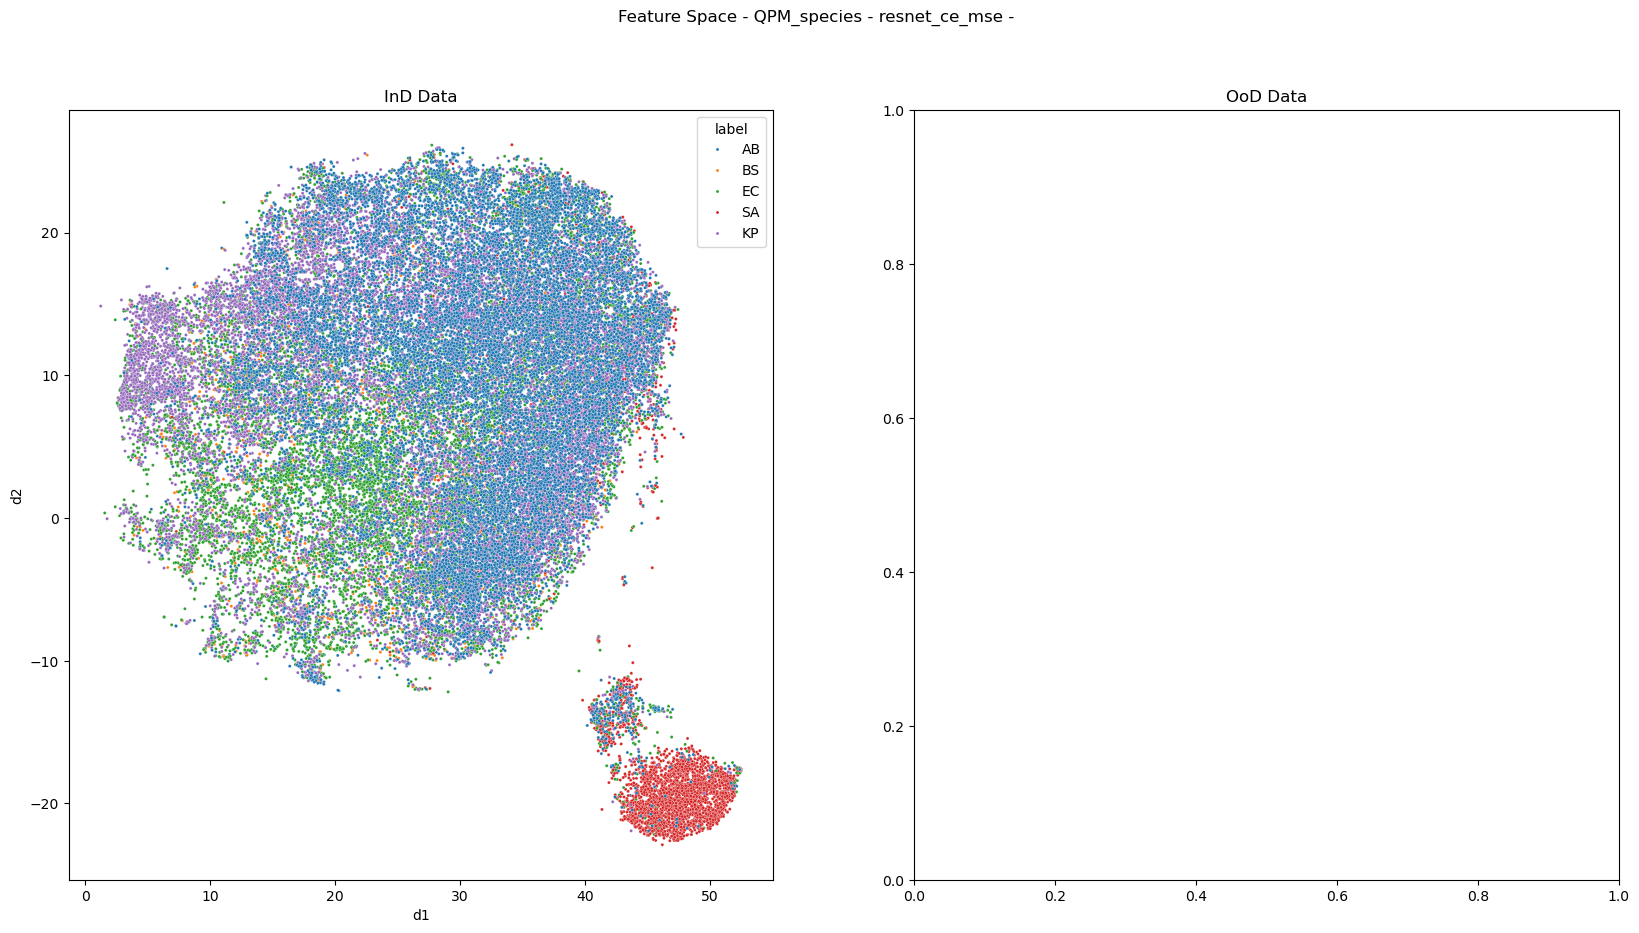

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

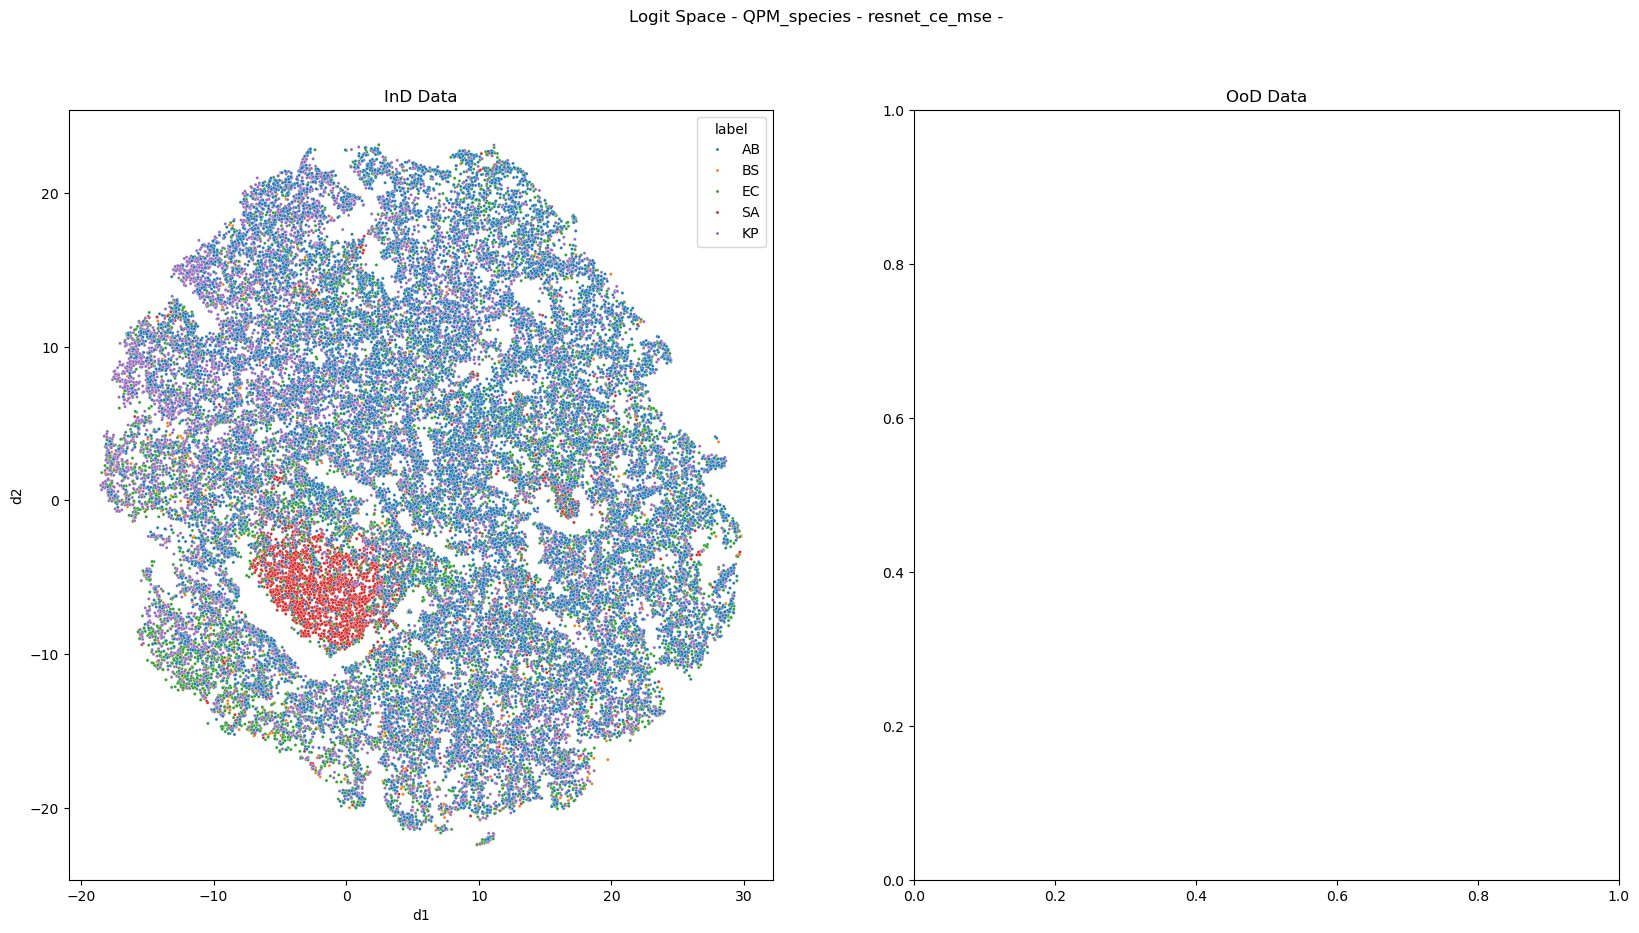

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:16<00:49, 16.55s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:33<00:33, 16.53s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:49<00:16, 16.69s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 17.00s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.86s/it]

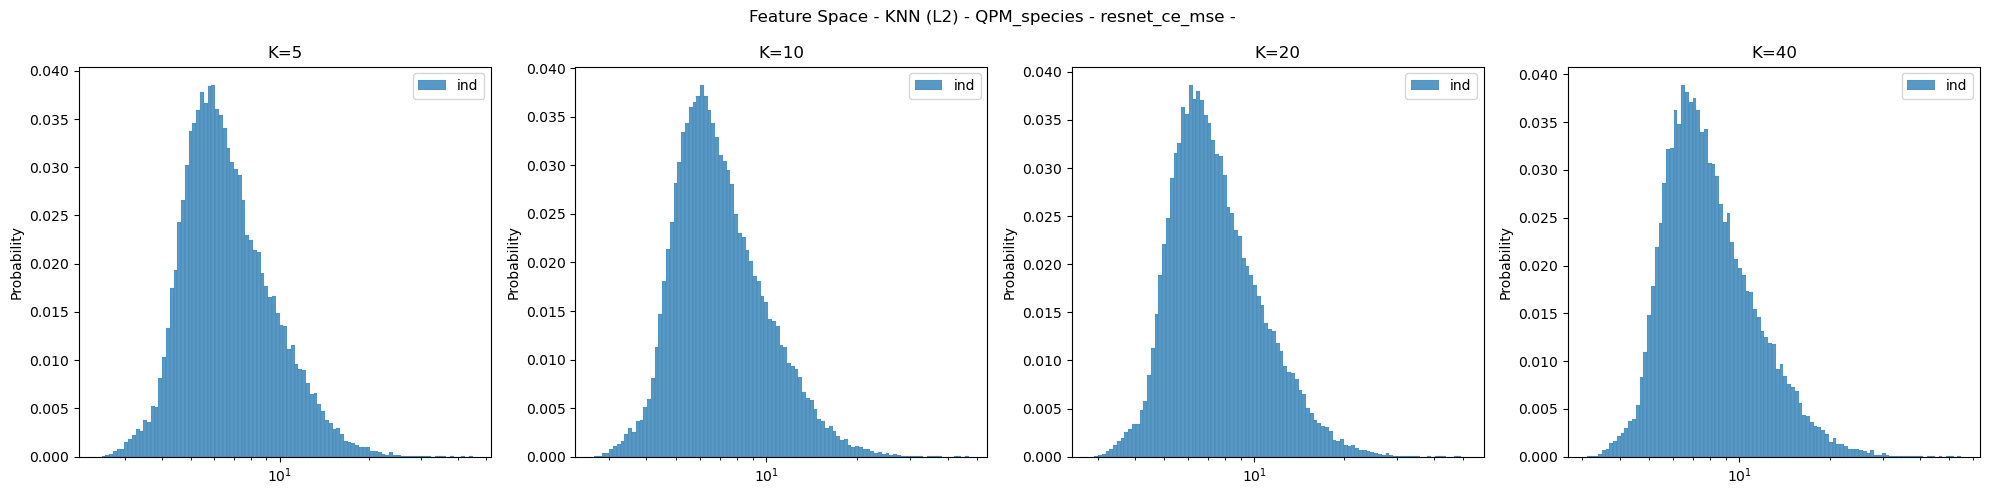

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:16<00:48, 16.16s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:32<00:32, 16.18s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:48<00:16, 16.25s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.54s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.42s/it]

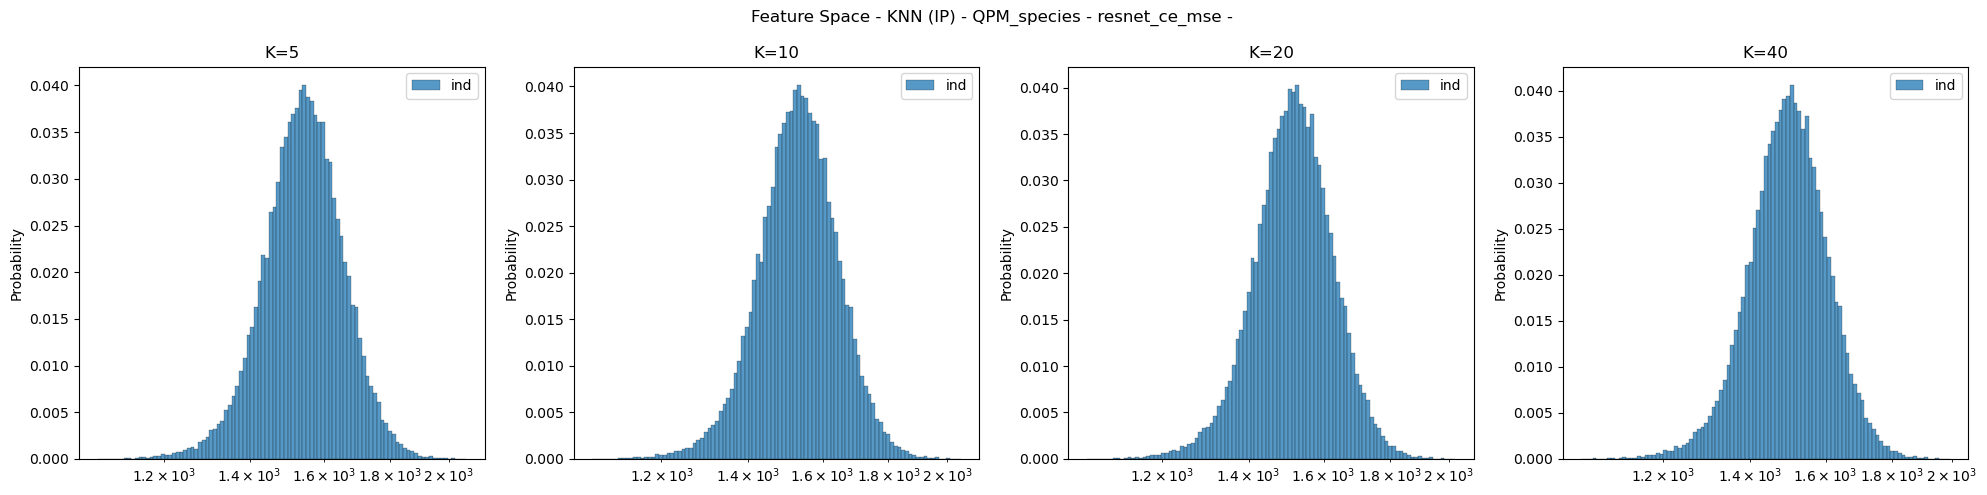

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:07,  2.44s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.37s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.41s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.56s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.50s/it]

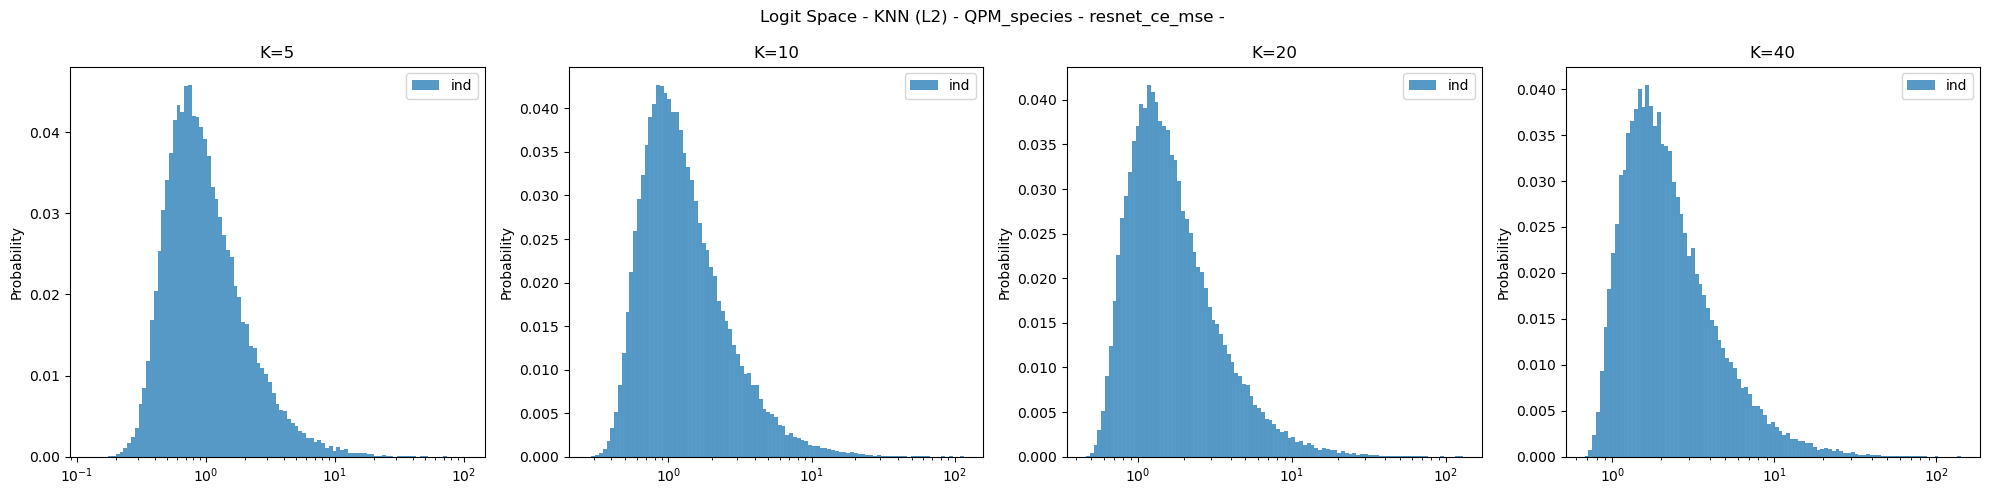

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:05,  1.93s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:03<00:03,  1.97s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.06s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.22s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it]

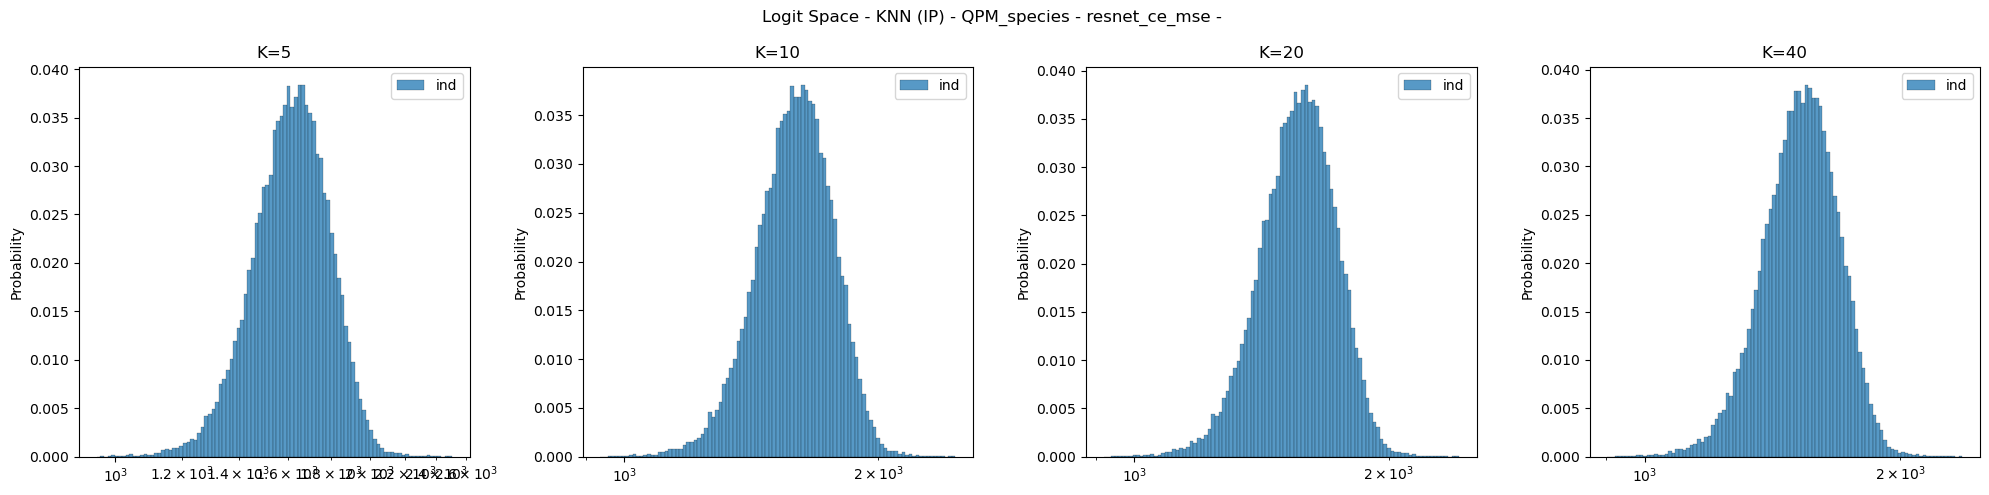

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

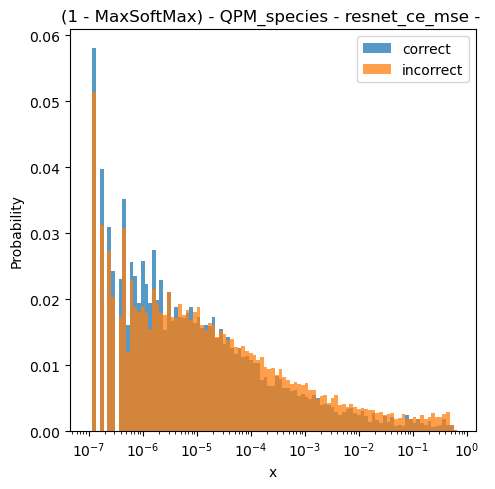

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

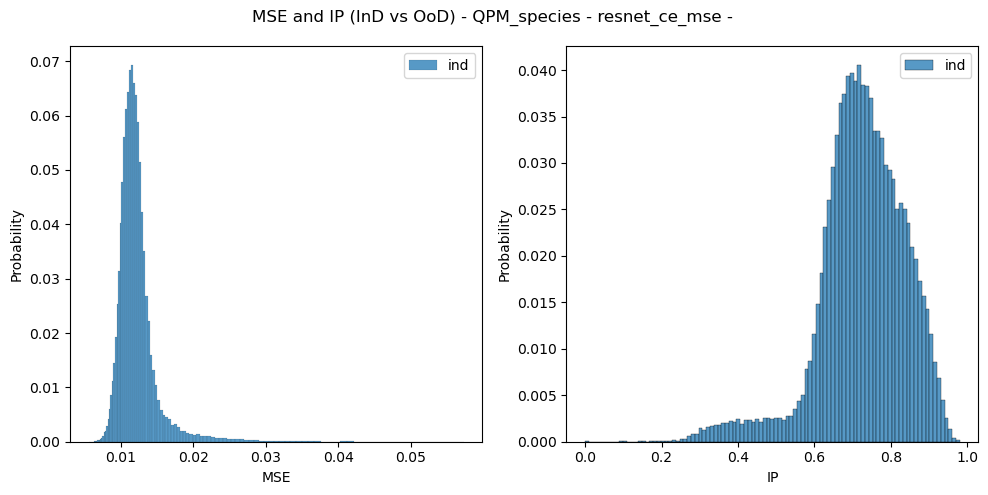

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()